# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2022-spring@googlegroups.com

# Download data
If the Google Drive links below do not work, you can download data from [Kaggle](https://www.kaggle.com/t/a3ebd5b5542f0f55e828d4f00de8e59a), and upload data manually to the workspace.

!gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
!gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# 用于数据分析可视化
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import Ridge


In [2]:
df = pd.read_csv('covid.train.csv',index_col=0)
test_df = pd.read_csv('covid.test.csv',index_col=0)

# Some Utility Functions

You do not need to modify this part.

In [3]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set))
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

# Dataset

Dataset类包装 → 变成PyTorch能理解的格式，提供索引访问
- def __init__(self, x, y=None):     # ✅ 存储数据
- def __getitem__(self, idx):       # ✅ 提供"按索引取数据"的能力  
- def __len__(self):            # ✅ 提供"数据总数"的信息

In [4]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [5]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # 改进的网络结构
        self.net = nn.Sequential(
            #1
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),    
            nn.Dropout(p=0.35),      
            nn.Linear(64, 1)  
            #2
            # nn.Linear(input_dim, 64),
            # nn.LeakyReLU(0.2),
            # nn.BatchNorm1d(64),
            # nn.Dropout(0.2),
            # nn.Linear(64, 16),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.1),
            # nn.Linear(16, 1)
            #3
            # nn.Linear(input_dim, 64),
            # nn.LeakyReLU(),                  
            # nn.Linear(64, 32),        
            # nn.LeakyReLU(), 
            # nn.Linear(32, 1)
        )
        # 将损失函数移到模型内部
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        # 使用RMSE而不是MSE
        return torch.sqrt(self.criterion(pred, target))

# Feature Selection
Choose features you deem useful by modifying the function below.

In [6]:
def select_feat(train_data, valid_data, test_data, select_all=True, use_simple_selection=False, add_auto_features=True):
    
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
        print(f"📊 使用全部特征: {len(feat_idx)} 个")
        
        # 归一化代码 - 位置1 ⭐
        selected_x_train = raw_x_train[:,feat_idx]
        selected_x_valid = raw_x_valid[:,feat_idx]
        selected_x_test = raw_x_test[:,feat_idx]
        
        # 数据归一化
        print("🔄 开始数据归一化...")
        x_min = selected_x_train.min(axis=0)
        x_max = selected_x_train.max(axis=0)
        x_range = x_max - x_min
        x_range[x_range == 0] = 1  # 避免除零
        
        x_train_norm = (selected_x_train - x_min) / x_range
        x_valid_norm = (selected_x_valid - x_min) / x_range  
        x_test_norm = (selected_x_test - x_min) / x_range
        print("✅ 数据归一化完成")
        
        return x_train_norm, x_valid_norm, x_test_norm, y_train, y_valid
    
    elif use_simple_selection:
        print("🎯 开始特征选择...")
        print(f"📊 原始特征总数: {raw_x_train.shape[1]}")
        
        # 手动选择
        feature_positions = []
        for time_period in range(4):
            base_start = 38 + time_period * 16
            period_features = [
                base_start + 15,  # tested_positive
                base_start + 1,   # ili
                base_start + 0,   # cli
                base_start + 2,   # hh_cmnty_cli
            ]
            feature_positions.extend(period_features)
        
        manual_idx = feature_positions
        
        # 自动选择
        if add_auto_features:
            print("🤖 开始自动特征选择...")
            
            all_idx = list(range(raw_x_train.shape[1]))
            remaining_idx = [i for i in all_idx if i not in manual_idx]
            print(f"📊 剩余可选特征: {len(remaining_idx)} 个")
            
            k_auto = 12  # 自动选择特征数量
            
            if len(remaining_idx) >= k_auto:
                remaining_features = raw_x_train[:, remaining_idx]
                print(f"🔍 从 {len(remaining_idx)} 个特征中自动选择 {k_auto} 个最好的")
                
                selector = SelectKBest(score_func=f_regression, k=k_auto)
                selector.fit(remaining_features, y_train)
                
                selected_mask = selector.get_support()
                auto_idx = [remaining_idx[i] for i, selected in enumerate(selected_mask) if selected]
                
                # 显示自动选择的特征得分
                scores = selector.scores_[selected_mask]
                print(f"✅ 自动选择完成: {len(auto_idx)} 个特征")
                print(f"📈 自动选择特征的平均得分: {scores.mean():.2f}")
                
                final_idx = manual_idx + auto_idx
                
            else:
                print(f"⚠️ 剩余特征({len(remaining_idx)})不足{k_auto}个，只使用手动选择")
                final_idx = manual_idx
        
        else:
            print("🚫 跳过自动选择")
            final_idx = manual_idx
        
        print(f"🎉 最终使用特征数: {len(final_idx)} 个")
         # 归一化代码 - 位置2 ⭐
        selected_x_train = raw_x_train[:,final_idx]
        selected_x_valid = raw_x_valid[:,final_idx]
        selected_x_test = raw_x_test[:,final_idx]
        
        # 数据归一化
        print("🔄 开始数据归一化...")
        x_min = selected_x_train.min(axis=0)
        x_max = selected_x_train.max(axis=0)
        x_range = x_max - x_min
        x_range[x_range == 0] = 1  # 避免除零
        
        x_train_norm = (selected_x_train - x_min) / x_range
        x_valid_norm = (selected_x_valid - x_min) / x_range  
        x_test_norm = (selected_x_test - x_min) / x_range
        print("✅ 数据归一化完成")
        print("="*50)
        
        return (raw_x_train[:,final_idx], 
                raw_x_valid[:,final_idx], 
                raw_x_test[:,final_idx], 
                y_train, y_valid)

# Training Loop

In [7]:
def trainer(train_loader, valid_loader, test_loader, model, config, device):
    criterion = nn.MSELoss(reduction='mean')

    # 改用Adam优化器 + L2正则化 ⭐⭐⭐
    optimizer = torch.optim.Adam(model.parameters(), 
                               lr=config['learning_rate'] * 50,  # 提高学习率
                               weight_decay=2e-3 )                # L2正则化1e-3>2e-3 
    
    # 加上学习率调度器 ⭐⭐⭐
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=2, T_mult=2, eta_min=config['learning_rate'])
    
    # optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    writer = SummaryWriter()

    if not os.path.isdir('./models'):
        os.mkdir('./models')
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    train_losses, val_losses = [], [] 

    for epoch in range(n_epochs):
        model.train()
        loss_record = []

        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = model.cal_loss(pred, y)
            loss.backward()
            optimizer.step()
            step += 1
            loss_record.append(loss.detach().item())

            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        # 验证集评估
        model.eval()
        valid_loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = model.cal_loss(pred, y)
            valid_loss_record.append(loss.item())

        mean_valid_loss = sum(valid_loss_record)/len(valid_loss_record)
        writer.add_scalar('Loss/valid', mean_valid_loss, step)
        
        # 测试集评估（每10个epoch评估一次，避免过于频繁）
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            test_loss_record = []
            for x in test_loader:  # 注意：测试集没有标签，这里我们用验证集代替来演示
                pass
            
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        
        train_losses.append(mean_train_loss)
        val_losses.append(mean_valid_loss)  

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path'])
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        # ⭐⭐⭐ 在这里加scheduler.step() ⭐⭐⭐
        scheduler.step()  # 在epoch的最后，所有计算完成后调用

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            break  
            
    return train_losses, val_losses 

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': False,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 3000,     # Number of epochs.3000
    'batch_size': 256,
    'learning_rate': 1e-2,
    'early_stop': 200,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': False,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.3000
    'batch_size': 256,
    'learning_rate': 1e-5,
    'early_stop': 500,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [9]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days)
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('./covid.train.csv').values, pd.read_csv('./covid.test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape}
valid_data size: {valid_data.shape}
test_data size: {test_data.shape}""")

# Select features
#x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, config['select_all'])
# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(
    train_data, valid_data, test_data, 
    select_all=False,           # 改为False，使用特征选择
    use_simple_selection=True,  # 使用手动选择
    add_auto_features=True      # 加上自动选择
)
# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

# test_dataset = COVID19Dataset(x_test)  # x_test的维度必须匹配训练时的维度
train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (2160, 118)
valid_data size: (539, 118)
test_data size: (1078, 117)
🎯 开始特征选择...
📊 原始特征总数: 117
🤖 开始自动特征选择...
📊 剩余可选特征: 101 个
🔍 从 101 个特征中自动选择 12 个最好的
✅ 自动选择完成: 12 个特征
📈 自动选择特征的平均得分: 5349.50
🎉 最终使用特征数: 28 个
🔄 开始数据归一化...
✅ 数据归一化完成
number of features: 28


# Start training!

In [10]:
model = My_Model(input_dim=x_train.shape[1]).to(device)
train_losses, val_losses = trainer(train_loader, valid_loader, test_loader, model, config, device)

  0%|          | 0/9 [00:00<?, ?it/s]/Users/hirano/Downloads/Anaconda/anaconda3/envs/d2l_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [1/5000]: 100%|██████████| 9/9 [00:00<00:00, 145.11it/s, loss=9.02]


Epoch [1/5000]: Train loss: 10.7270, Valid loss: 9.8857
Saving model with loss 9.886...


Epoch [2/5000]: 100%|██████████| 9/9 [00:00<00:00, 306.39it/s, loss=10.5]


Epoch [2/5000]: Train loss: 10.6271, Valid loss: 10.1394


Epoch [3/5000]: 100%|██████████| 9/9 [00:00<00:00, 91.27it/s, loss=9.32]


Epoch [3/5000]: Train loss: 10.3744, Valid loss: 9.8443
Saving model with loss 9.844...


Epoch [4/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.84it/s, loss=8.95]


Epoch [4/5000]: Train loss: 10.1458, Valid loss: 9.7117
Saving model with loss 9.712...


Epoch [5/5000]: 100%|██████████| 9/9 [00:00<00:00, 474.03it/s, loss=10.8]


Epoch [5/5000]: Train loss: 10.1064, Valid loss: 10.5324


Epoch [6/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.58it/s, loss=10.5]


Epoch [6/5000]: Train loss: 10.0419, Valid loss: 10.1134


Epoch [7/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.47it/s, loss=10.1]


Epoch [7/5000]: Train loss: 9.8871, Valid loss: 10.3020


Epoch [8/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.41it/s, loss=8.74]


Epoch [8/5000]: Train loss: 9.6677, Valid loss: 9.5340
Saving model with loss 9.534...


Epoch [9/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.20it/s, loss=8.8]


Epoch [9/5000]: Train loss: 9.4721, Valid loss: 9.3253
Saving model with loss 9.325...


Epoch [10/5000]: 100%|██████████| 9/9 [00:00<00:00, 471.78it/s, loss=9.71]


Epoch [10/5000]: Train loss: 9.4204, Valid loss: 9.7693


Epoch [11/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.02it/s, loss=10.7]


Epoch [11/5000]: Train loss: 9.3568, Valid loss: 9.3489


Epoch [12/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.23it/s, loss=8.13]


Epoch [12/5000]: Train loss: 9.0962, Valid loss: 9.3957


Epoch [13/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.36it/s, loss=8.92]


Epoch [13/5000]: Train loss: 9.1313, Valid loss: 9.4935


Epoch [14/5000]: 100%|██████████| 9/9 [00:00<00:00, 352.14it/s, loss=9.81]


Epoch [14/5000]: Train loss: 9.1666, Valid loss: 9.3892


Epoch [15/5000]: 100%|██████████| 9/9 [00:00<00:00, 345.77it/s, loss=9.68]


Epoch [15/5000]: Train loss: 9.0974, Valid loss: 9.2994
Saving model with loss 9.299...


Epoch [16/5000]: 100%|██████████| 9/9 [00:00<00:00, 291.69it/s, loss=8.96]


Epoch [16/5000]: Train loss: 8.8567, Valid loss: 9.1313
Saving model with loss 9.131...


Epoch [17/5000]: 100%|██████████| 9/9 [00:00<00:00, 289.12it/s, loss=8.88]


Epoch [17/5000]: Train loss: 8.6503, Valid loss: 8.7302
Saving model with loss 8.730...


Epoch [18/5000]: 100%|██████████| 9/9 [00:00<00:00, 324.03it/s, loss=7.82]


Epoch [18/5000]: Train loss: 8.3723, Valid loss: 8.1764
Saving model with loss 8.176...


Epoch [19/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.52it/s, loss=7.78]


Epoch [19/5000]: Train loss: 8.2219, Valid loss: 8.4380


Epoch [20/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.19it/s, loss=8.58]


Epoch [20/5000]: Train loss: 8.1340, Valid loss: 8.3674


Epoch [21/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.18it/s, loss=8.03]


Epoch [21/5000]: Train loss: 7.9721, Valid loss: 7.9416
Saving model with loss 7.942...


Epoch [22/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.62it/s, loss=6.68]


Epoch [22/5000]: Train loss: 7.6785, Valid loss: 7.6348
Saving model with loss 7.635...


Epoch [23/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.64it/s, loss=7.33]


Epoch [23/5000]: Train loss: 7.6555, Valid loss: 7.4005
Saving model with loss 7.400...


Epoch [24/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.44it/s, loss=7.68]


Epoch [24/5000]: Train loss: 7.5414, Valid loss: 7.7345


Epoch [25/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.57it/s, loss=6.81]


Epoch [25/5000]: Train loss: 7.4439, Valid loss: 7.9009


Epoch [26/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.19it/s, loss=9.13]


Epoch [26/5000]: Train loss: 7.5055, Valid loss: 7.5496


Epoch [27/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.05it/s, loss=8.43]


Epoch [27/5000]: Train loss: 7.4229, Valid loss: 7.9032


Epoch [28/5000]: 100%|██████████| 9/9 [00:00<00:00, 287.50it/s, loss=7.62]


Epoch [28/5000]: Train loss: 7.3557, Valid loss: 7.3692
Saving model with loss 7.369...


Epoch [29/5000]: 100%|██████████| 9/9 [00:00<00:00, 334.16it/s, loss=6.73]


Epoch [29/5000]: Train loss: 7.3106, Valid loss: 7.3522
Saving model with loss 7.352...


Epoch [30/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.04it/s, loss=6.16]


Epoch [30/5000]: Train loss: 7.2478, Valid loss: 7.4071


Epoch [31/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.91it/s, loss=7.88]


Epoch [31/5000]: Train loss: 7.2859, Valid loss: 7.2836
Saving model with loss 7.284...


Epoch [32/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.89it/s, loss=7.01]


Epoch [32/5000]: Train loss: 7.0848, Valid loss: 7.2967


Epoch [33/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.24it/s, loss=7.56]


Epoch [33/5000]: Train loss: 6.9128, Valid loss: 6.8439
Saving model with loss 6.844...


Epoch [34/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.94it/s, loss=7.51]


Epoch [34/5000]: Train loss: 6.7556, Valid loss: 7.0055


Epoch [35/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.40it/s, loss=6.44]


Epoch [35/5000]: Train loss: 6.5131, Valid loss: 6.5119
Saving model with loss 6.512...


Epoch [36/5000]: 100%|██████████| 9/9 [00:00<00:00, 363.74it/s, loss=6.66]


Epoch [36/5000]: Train loss: 6.3546, Valid loss: 6.1897
Saving model with loss 6.190...


Epoch [37/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.60it/s, loss=5.84]


Epoch [37/5000]: Train loss: 6.1867, Valid loss: 6.1543
Saving model with loss 6.154...


Epoch [38/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.45it/s, loss=6.2]


Epoch [38/5000]: Train loss: 6.0517, Valid loss: 6.1621


Epoch [39/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.08it/s, loss=5.91]


Epoch [39/5000]: Train loss: 5.8836, Valid loss: 5.6374
Saving model with loss 5.637...


Epoch [40/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.52it/s, loss=5.96]


Epoch [40/5000]: Train loss: 5.7756, Valid loss: 5.7372


Epoch [41/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.31it/s, loss=5.62]


Epoch [41/5000]: Train loss: 5.5990, Valid loss: 5.7369


Epoch [42/5000]: 100%|██████████| 9/9 [00:00<00:00, 342.18it/s, loss=4.87]


Epoch [42/5000]: Train loss: 5.4600, Valid loss: 5.6405


Epoch [43/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.36it/s, loss=5.31]


Epoch [43/5000]: Train loss: 5.3524, Valid loss: 5.5913
Saving model with loss 5.591...


Epoch [44/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.41it/s, loss=5.31]


Epoch [44/5000]: Train loss: 5.2155, Valid loss: 5.1788
Saving model with loss 5.179...


Epoch [45/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.10it/s, loss=5.12]


Epoch [45/5000]: Train loss: 5.1349, Valid loss: 5.0223
Saving model with loss 5.022...


Epoch [46/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.24it/s, loss=4.99]


Epoch [46/5000]: Train loss: 5.0458, Valid loss: 5.0319


Epoch [47/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.56it/s, loss=6.79]


Epoch [47/5000]: Train loss: 5.0732, Valid loss: 5.3068


Epoch [48/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.92it/s, loss=4.32]


Epoch [48/5000]: Train loss: 4.8385, Valid loss: 4.7892
Saving model with loss 4.789...


Epoch [49/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.05it/s, loss=4.67]


Epoch [49/5000]: Train loss: 4.8181, Valid loss: 5.0562


Epoch [50/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.89it/s, loss=5.08]


Epoch [50/5000]: Train loss: 4.7689, Valid loss: 4.6199
Saving model with loss 4.620...


Epoch [51/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.08it/s, loss=4.54]


Epoch [51/5000]: Train loss: 4.6643, Valid loss: 4.7153


Epoch [52/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.98it/s, loss=3.93]


Epoch [52/5000]: Train loss: 4.6183, Valid loss: 4.8677


Epoch [53/5000]: 100%|██████████| 9/9 [00:00<00:00, 347.53it/s, loss=4.98]


Epoch [53/5000]: Train loss: 4.6415, Valid loss: 4.6740


Epoch [54/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.90it/s, loss=4.75]


Epoch [54/5000]: Train loss: 4.6230, Valid loss: 4.4300
Saving model with loss 4.430...


Epoch [55/5000]: 100%|██████████| 9/9 [00:00<00:00, 352.90it/s, loss=6.07]


Epoch [55/5000]: Train loss: 4.6597, Valid loss: 4.5987


Epoch [56/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.91it/s, loss=5.39]


Epoch [56/5000]: Train loss: 4.5781, Valid loss: 4.4987


Epoch [57/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.58it/s, loss=4.34]


Epoch [57/5000]: Train loss: 4.4845, Valid loss: 4.5373


Epoch [58/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.66it/s, loss=4.29]


Epoch [58/5000]: Train loss: 4.4540, Valid loss: 4.3434
Saving model with loss 4.343...


Epoch [59/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.36it/s, loss=4.3]


Epoch [59/5000]: Train loss: 4.4518, Valid loss: 4.4603


Epoch [60/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.12it/s, loss=4.74]


Epoch [60/5000]: Train loss: 4.4935, Valid loss: 4.3999


Epoch [61/5000]: 100%|██████████| 9/9 [00:00<00:00, 371.02it/s, loss=4.78]


Epoch [61/5000]: Train loss: 4.4411, Valid loss: 4.3895


Epoch [62/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.57it/s, loss=5.1]


Epoch [62/5000]: Train loss: 4.4703, Valid loss: 4.3416
Saving model with loss 4.342...


Epoch [63/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.94it/s, loss=4.47]


Epoch [63/5000]: Train loss: 4.3710, Valid loss: 4.3268
Saving model with loss 4.327...


Epoch [64/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.54it/s, loss=3.72]


Epoch [64/5000]: Train loss: 4.2176, Valid loss: 4.2400
Saving model with loss 4.240...


Epoch [65/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.08it/s, loss=4.2]


Epoch [65/5000]: Train loss: 4.0940, Valid loss: 4.3684


Epoch [66/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.26it/s, loss=4.15]


Epoch [66/5000]: Train loss: 3.9379, Valid loss: 4.0695
Saving model with loss 4.070...


Epoch [67/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.24it/s, loss=3.87]


Epoch [67/5000]: Train loss: 3.7594, Valid loss: 3.9955
Saving model with loss 3.996...


Epoch [68/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.90it/s, loss=3.42]


Epoch [68/5000]: Train loss: 3.6657, Valid loss: 2.9498
Saving model with loss 2.950...


Epoch [69/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.43it/s, loss=3.67]


Epoch [69/5000]: Train loss: 3.5743, Valid loss: 3.6287


Epoch [70/5000]: 100%|██████████| 9/9 [00:00<00:00, 133.68it/s, loss=2.97]


Epoch [70/5000]: Train loss: 3.4626, Valid loss: 4.3214


Epoch [71/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.43it/s, loss=2.89]


Epoch [71/5000]: Train loss: 3.2862, Valid loss: 3.1651


Epoch [72/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.47it/s, loss=3.32]


Epoch [72/5000]: Train loss: 3.2280, Valid loss: 2.8980
Saving model with loss 2.898...


Epoch [73/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.29it/s, loss=2.96]


Epoch [73/5000]: Train loss: 3.0681, Valid loss: 2.6396
Saving model with loss 2.640...


Epoch [74/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.64it/s, loss=3.04]


Epoch [74/5000]: Train loss: 3.0063, Valid loss: 2.5233
Saving model with loss 2.523...


Epoch [75/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.67it/s, loss=2.47]


Epoch [75/5000]: Train loss: 2.9407, Valid loss: 2.0745
Saving model with loss 2.074...


Epoch [76/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.55it/s, loss=3.54]


Epoch [76/5000]: Train loss: 2.9420, Valid loss: 2.4198


Epoch [77/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.69it/s, loss=3.21]


Epoch [77/5000]: Train loss: 2.8531, Valid loss: 2.5974


Epoch [78/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.75it/s, loss=2.85]


Epoch [78/5000]: Train loss: 2.8718, Valid loss: 1.8435
Saving model with loss 1.844...


Epoch [79/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.61it/s, loss=2.8]


Epoch [79/5000]: Train loss: 2.8408, Valid loss: 3.3897


Epoch [80/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.96it/s, loss=2.9]


Epoch [80/5000]: Train loss: 2.7971, Valid loss: 2.0363


Epoch [81/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.98it/s, loss=2.49]


Epoch [81/5000]: Train loss: 2.6745, Valid loss: 3.0450


Epoch [82/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.44it/s, loss=2.51]


Epoch [82/5000]: Train loss: 2.6588, Valid loss: 1.9196


Epoch [83/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.54it/s, loss=2.61]


Epoch [83/5000]: Train loss: 2.6691, Valid loss: 2.0608


Epoch [84/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.34it/s, loss=2.83]


Epoch [84/5000]: Train loss: 2.7128, Valid loss: 2.1759


Epoch [85/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.68it/s, loss=2.55]


Epoch [85/5000]: Train loss: 2.6102, Valid loss: 2.2905


Epoch [86/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.36it/s, loss=2.34]


Epoch [86/5000]: Train loss: 2.5455, Valid loss: 2.0987


Epoch [87/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.27it/s, loss=2.38]


Epoch [87/5000]: Train loss: 2.5801, Valid loss: 2.2746


Epoch [88/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.92it/s, loss=2.63]


Epoch [88/5000]: Train loss: 2.5691, Valid loss: 1.9657


Epoch [89/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.03it/s, loss=2.35]


Epoch [89/5000]: Train loss: 2.5461, Valid loss: 2.6078


Epoch [90/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.86it/s, loss=2.65]


Epoch [90/5000]: Train loss: 2.5910, Valid loss: 1.9267


Epoch [91/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.97it/s, loss=2.76]


Epoch [91/5000]: Train loss: 2.5776, Valid loss: 2.1133


Epoch [92/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.47it/s, loss=2.71]


Epoch [92/5000]: Train loss: 2.5465, Valid loss: 1.7986
Saving model with loss 1.799...


Epoch [93/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.26it/s, loss=3.13]


Epoch [93/5000]: Train loss: 2.6066, Valid loss: 2.1529


Epoch [94/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.33it/s, loss=2.58]


Epoch [94/5000]: Train loss: 2.5284, Valid loss: 1.9760


Epoch [95/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.67it/s, loss=2.83]


Epoch [95/5000]: Train loss: 2.5433, Valid loss: 1.9613


Epoch [96/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.79it/s, loss=2.36]


Epoch [96/5000]: Train loss: 2.4722, Valid loss: 2.0337


Epoch [97/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.73it/s, loss=2.58]


Epoch [97/5000]: Train loss: 2.6009, Valid loss: 2.2430


Epoch [98/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.80it/s, loss=2.79]


Epoch [98/5000]: Train loss: 2.5330, Valid loss: 2.0238


Epoch [99/5000]: 100%|██████████| 9/9 [00:00<00:00, 476.82it/s, loss=2.22]


Epoch [99/5000]: Train loss: 2.4743, Valid loss: 1.7992


Epoch [100/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.60it/s, loss=2.56]


Epoch [100/5000]: Train loss: 2.5393, Valid loss: 1.9182


Epoch [101/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.56it/s, loss=2.42]


Epoch [101/5000]: Train loss: 2.4808, Valid loss: 2.0714


Epoch [102/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.04it/s, loss=2.36]


Epoch [102/5000]: Train loss: 2.4715, Valid loss: 1.8972


Epoch [103/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.94it/s, loss=2.47]


Epoch [103/5000]: Train loss: 2.3954, Valid loss: 1.9978


Epoch [104/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.93it/s, loss=2.5]


Epoch [104/5000]: Train loss: 2.4462, Valid loss: 1.8851


Epoch [105/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.29it/s, loss=2.93]


Epoch [105/5000]: Train loss: 2.5295, Valid loss: 1.9148


Epoch [106/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.72it/s, loss=2.45]


Epoch [106/5000]: Train loss: 2.5242, Valid loss: 2.0008


Epoch [107/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.28it/s, loss=2.65]


Epoch [107/5000]: Train loss: 2.5358, Valid loss: 2.0213


Epoch [108/5000]: 100%|██████████| 9/9 [00:00<00:00, 448.41it/s, loss=2.35]


Epoch [108/5000]: Train loss: 2.5087, Valid loss: 1.7623
Saving model with loss 1.762...


Epoch [109/5000]: 100%|██████████| 9/9 [00:00<00:00, 104.07it/s, loss=3.32]


Epoch [109/5000]: Train loss: 2.4639, Valid loss: 1.7230
Saving model with loss 1.723...


Epoch [110/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.59it/s, loss=2.44]


Epoch [110/5000]: Train loss: 2.4575, Valid loss: 1.9280


Epoch [111/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.44it/s, loss=2.26]


Epoch [111/5000]: Train loss: 2.4710, Valid loss: 2.0791


Epoch [112/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.72it/s, loss=2.18]


Epoch [112/5000]: Train loss: 2.4553, Valid loss: 1.9079


Epoch [113/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.25it/s, loss=2.56]


Epoch [113/5000]: Train loss: 2.5150, Valid loss: 1.9979


Epoch [114/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.51it/s, loss=2.45]


Epoch [114/5000]: Train loss: 2.4094, Valid loss: 1.8495


Epoch [115/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.35it/s, loss=2.6]


Epoch [115/5000]: Train loss: 2.4101, Valid loss: 1.9376


Epoch [116/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.63it/s, loss=2.52]


Epoch [116/5000]: Train loss: 2.4556, Valid loss: 1.8139


Epoch [117/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.68it/s, loss=2.3]


Epoch [117/5000]: Train loss: 2.4076, Valid loss: 1.7857


Epoch [118/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.26it/s, loss=2.38]


Epoch [118/5000]: Train loss: 2.4975, Valid loss: 1.9481


Epoch [119/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.76it/s, loss=2.45]


Epoch [119/5000]: Train loss: 2.4589, Valid loss: 1.9739


Epoch [120/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.13it/s, loss=2.49]


Epoch [120/5000]: Train loss: 2.4839, Valid loss: 1.9311


Epoch [121/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.39it/s, loss=3]


Epoch [121/5000]: Train loss: 2.4946, Valid loss: 1.7561


Epoch [122/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.90it/s, loss=2.55]


Epoch [122/5000]: Train loss: 2.4566, Valid loss: 1.8366


Epoch [123/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.52it/s, loss=2.4]


Epoch [123/5000]: Train loss: 2.4265, Valid loss: 1.8996


Epoch [124/5000]: 100%|██████████| 9/9 [00:00<00:00, 471.08it/s, loss=2.44]


Epoch [124/5000]: Train loss: 2.4805, Valid loss: 1.8518


Epoch [125/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.97it/s, loss=2.64]


Epoch [125/5000]: Train loss: 2.5437, Valid loss: 1.8596


Epoch [126/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.72it/s, loss=2.46]


Epoch [126/5000]: Train loss: 2.3527, Valid loss: 2.0550


Epoch [127/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.71it/s, loss=2.19]


Epoch [127/5000]: Train loss: 2.4414, Valid loss: 1.8020


Epoch [128/5000]: 100%|██████████| 9/9 [00:00<00:00, 477.97it/s, loss=2.87]


Epoch [128/5000]: Train loss: 2.5494, Valid loss: 1.8773


Epoch [129/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.83it/s, loss=2.65]


Epoch [129/5000]: Train loss: 2.4606, Valid loss: 2.0410


Epoch [130/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.86it/s, loss=2.45]


Epoch [130/5000]: Train loss: 2.4991, Valid loss: 1.9723


Epoch [131/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.17it/s, loss=2.9]


Epoch [131/5000]: Train loss: 2.5168, Valid loss: 2.2354


Epoch [132/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.28it/s, loss=2.44]


Epoch [132/5000]: Train loss: 2.4884, Valid loss: 1.8569


Epoch [133/5000]: 100%|██████████| 9/9 [00:00<00:00, 448.81it/s, loss=2.18]


Epoch [133/5000]: Train loss: 2.4222, Valid loss: 1.8522


Epoch [134/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.08it/s, loss=2.34]


Epoch [134/5000]: Train loss: 2.4611, Valid loss: 2.0654


Epoch [135/5000]: 100%|██████████| 9/9 [00:00<00:00, 474.64it/s, loss=2.61]


Epoch [135/5000]: Train loss: 2.3937, Valid loss: 1.9838


Epoch [136/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.87it/s, loss=2.34]


Epoch [136/5000]: Train loss: 2.4400, Valid loss: 1.9518


Epoch [137/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.56it/s, loss=2.29]


Epoch [137/5000]: Train loss: 2.4260, Valid loss: 2.0734


Epoch [138/5000]: 100%|██████████| 9/9 [00:00<00:00, 475.54it/s, loss=2.68]


Epoch [138/5000]: Train loss: 2.3972, Valid loss: 2.0584


Epoch [139/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.50it/s, loss=2.64]


Epoch [139/5000]: Train loss: 2.4579, Valid loss: 2.0473


Epoch [140/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.94it/s, loss=2.24]


Epoch [140/5000]: Train loss: 2.3834, Valid loss: 1.7323


Epoch [141/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.29it/s, loss=2.03]


Epoch [141/5000]: Train loss: 2.3881, Valid loss: 1.8287


Epoch [142/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.91it/s, loss=2.23]


Epoch [142/5000]: Train loss: 2.3832, Valid loss: 2.0006


Epoch [143/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.17it/s, loss=2.01]


Epoch [143/5000]: Train loss: 2.3512, Valid loss: 1.9451


Epoch [144/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.18it/s, loss=3.09]


Epoch [144/5000]: Train loss: 2.4623, Valid loss: 1.7541


Epoch [145/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.92it/s, loss=1.99]


Epoch [145/5000]: Train loss: 2.3459, Valid loss: 2.0286


Epoch [146/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.74it/s, loss=2.28]


Epoch [146/5000]: Train loss: 2.3636, Valid loss: 1.8023


Epoch [147/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.48it/s, loss=2.34]


Epoch [147/5000]: Train loss: 2.3363, Valid loss: 2.1155


Epoch [148/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.99it/s, loss=2.19]


Epoch [148/5000]: Train loss: 2.3905, Valid loss: 2.0090


Epoch [149/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.25it/s, loss=2.39]


Epoch [149/5000]: Train loss: 2.4483, Valid loss: 1.7344


Epoch [150/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.38it/s, loss=2.13]


Epoch [150/5000]: Train loss: 2.2901, Valid loss: 2.2440


Epoch [151/5000]: 100%|██████████| 9/9 [00:00<00:00, 300.75it/s, loss=2.34]


Epoch [151/5000]: Train loss: 2.3356, Valid loss: 1.6122
Saving model with loss 1.612...


Epoch [152/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.64it/s, loss=2.33]


Epoch [152/5000]: Train loss: 2.3745, Valid loss: 1.7172


Epoch [153/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.24it/s, loss=2.13]


Epoch [153/5000]: Train loss: 2.3387, Valid loss: 1.7614


Epoch [154/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.68it/s, loss=2.09]


Epoch [154/5000]: Train loss: 2.3843, Valid loss: 1.7618


Epoch [155/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.78it/s, loss=2.24]


Epoch [155/5000]: Train loss: 2.3402, Valid loss: 1.6366


Epoch [156/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.58it/s, loss=2.33]


Epoch [156/5000]: Train loss: 2.4247, Valid loss: 1.7913


Epoch [157/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.92it/s, loss=2.09]


Epoch [157/5000]: Train loss: 2.2774, Valid loss: 1.8681


Epoch [158/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.72it/s, loss=2.61]


Epoch [158/5000]: Train loss: 2.3496, Valid loss: 1.7421


Epoch [159/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.72it/s, loss=2.73]


Epoch [159/5000]: Train loss: 2.3464, Valid loss: 1.7501


Epoch [160/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.45it/s, loss=2.33]


Epoch [160/5000]: Train loss: 2.3251, Valid loss: 1.7881


Epoch [161/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.95it/s, loss=2.94]


Epoch [161/5000]: Train loss: 2.4551, Valid loss: 1.6448


Epoch [162/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.23it/s, loss=2.13]


Epoch [162/5000]: Train loss: 2.2821, Valid loss: 2.3302


Epoch [163/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.89it/s, loss=2.34]


Epoch [163/5000]: Train loss: 2.3302, Valid loss: 1.7001


Epoch [164/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.81it/s, loss=2.25]


Epoch [164/5000]: Train loss: 2.2606, Valid loss: 1.8883


Epoch [165/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.58it/s, loss=2.4]

Epoch [165/5000]: Train loss: 2.3010, Valid loss: 2.0636



Epoch [166/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.66it/s, loss=2.31]


Epoch [166/5000]: Train loss: 2.2742, Valid loss: 1.6605


Epoch [167/5000]: 100%|██████████| 9/9 [00:00<00:00, 471.87it/s, loss=2.31]


Epoch [167/5000]: Train loss: 2.3050, Valid loss: 1.7349


Epoch [168/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.13it/s, loss=2.27]


Epoch [168/5000]: Train loss: 2.3025, Valid loss: 1.7337


Epoch [169/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.01it/s, loss=2.27]


Epoch [169/5000]: Train loss: 2.2500, Valid loss: 1.7020


Epoch [170/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.47it/s, loss=2.23]


Epoch [170/5000]: Train loss: 2.3240, Valid loss: 1.7830


Epoch [171/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.51it/s, loss=2.37]


Epoch [171/5000]: Train loss: 2.3443, Valid loss: 1.8068


Epoch [172/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.47it/s, loss=2.29]


Epoch [172/5000]: Train loss: 2.2730, Valid loss: 1.6541


Epoch [173/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.73it/s, loss=2.45]


Epoch [173/5000]: Train loss: 2.2993, Valid loss: 1.8783


Epoch [174/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.53it/s, loss=2.05]


Epoch [174/5000]: Train loss: 2.2115, Valid loss: 1.7417


Epoch [175/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.74it/s, loss=2.08]


Epoch [175/5000]: Train loss: 2.2294, Valid loss: 1.7320


Epoch [176/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.18it/s, loss=2.29]


Epoch [176/5000]: Train loss: 2.2560, Valid loss: 1.6267


Epoch [177/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.43it/s, loss=2.77]


Epoch [177/5000]: Train loss: 2.3484, Valid loss: 1.6143


Epoch [178/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.72it/s, loss=2.18]


Epoch [178/5000]: Train loss: 2.2606, Valid loss: 1.7930


Epoch [179/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.18it/s, loss=2.28]


Epoch [179/5000]: Train loss: 2.3759, Valid loss: 1.7082


Epoch [180/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.56it/s, loss=2.33]


Epoch [180/5000]: Train loss: 2.1707, Valid loss: 1.8242


Epoch [181/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.85it/s, loss=2.07]


Epoch [181/5000]: Train loss: 2.1828, Valid loss: 1.6590


Epoch [182/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.72it/s, loss=2.25]


Epoch [182/5000]: Train loss: 2.2715, Valid loss: 1.9810


Epoch [183/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.83it/s, loss=2.39]


Epoch [183/5000]: Train loss: 2.2712, Valid loss: 1.7310


Epoch [184/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.01it/s, loss=2.06]


Epoch [184/5000]: Train loss: 2.1987, Valid loss: 1.7068


Epoch [185/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.16it/s, loss=2.64]


Epoch [185/5000]: Train loss: 2.2923, Valid loss: 1.7944


Epoch [186/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.46it/s, loss=2.3]


Epoch [186/5000]: Train loss: 2.2741, Valid loss: 1.8777


Epoch [187/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.00it/s, loss=1.92]


Epoch [187/5000]: Train loss: 2.2005, Valid loss: 1.5598
Saving model with loss 1.560...


Epoch [188/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.12it/s, loss=2.1]


Epoch [188/5000]: Train loss: 2.2373, Valid loss: 1.7664


Epoch [189/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.65it/s, loss=2.48]


Epoch [189/5000]: Train loss: 2.2415, Valid loss: 1.6365


Epoch [190/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.72it/s, loss=2.17]


Epoch [190/5000]: Train loss: 2.2777, Valid loss: 1.6703


Epoch [191/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.00it/s, loss=1.99]


Epoch [191/5000]: Train loss: 2.2564, Valid loss: 1.9477


Epoch [192/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.96it/s, loss=2.37]


Epoch [192/5000]: Train loss: 2.2746, Valid loss: 1.6854


Epoch [193/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.84it/s, loss=2.69]


Epoch [193/5000]: Train loss: 2.2701, Valid loss: 1.7693


Epoch [194/5000]: 100%|██████████| 9/9 [00:00<00:00, 471.48it/s, loss=2.66]


Epoch [194/5000]: Train loss: 2.2411, Valid loss: 1.5825


Epoch [195/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.78it/s, loss=2.46]


Epoch [195/5000]: Train loss: 2.2565, Valid loss: 1.6439


Epoch [196/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.44it/s, loss=2.43]


Epoch [196/5000]: Train loss: 2.2415, Valid loss: 1.6594


Epoch [197/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.10it/s, loss=2.39]


Epoch [197/5000]: Train loss: 2.2686, Valid loss: 1.6647


Epoch [198/5000]: 100%|██████████| 9/9 [00:00<00:00, 336.95it/s, loss=2.25]


Epoch [198/5000]: Train loss: 2.2614, Valid loss: 1.6550


Epoch [199/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.90it/s, loss=1.88]


Epoch [199/5000]: Train loss: 2.1590, Valid loss: 1.8667


Epoch [200/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.97it/s, loss=2.22]


Epoch [200/5000]: Train loss: 2.2424, Valid loss: 1.6956


Epoch [201/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.03it/s, loss=2.21]


Epoch [201/5000]: Train loss: 2.2642, Valid loss: 1.6795


Epoch [202/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.60it/s, loss=2.87]


Epoch [202/5000]: Train loss: 2.3256, Valid loss: 2.0222


Epoch [203/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.13it/s, loss=2.17]


Epoch [203/5000]: Train loss: 2.1391, Valid loss: 1.6251


Epoch [204/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.57it/s, loss=1.98]


Epoch [204/5000]: Train loss: 2.2253, Valid loss: 1.7688


Epoch [205/5000]: 100%|██████████| 9/9 [00:00<00:00, 421.43it/s, loss=2.54]


Epoch [205/5000]: Train loss: 2.2748, Valid loss: 1.6660


Epoch [206/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.25it/s, loss=2.23]


Epoch [206/5000]: Train loss: 2.1901, Valid loss: 1.5202
Saving model with loss 1.520...


Epoch [207/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.03it/s, loss=2.13]


Epoch [207/5000]: Train loss: 2.1739, Valid loss: 1.8219


Epoch [208/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.12it/s, loss=2.09]


Epoch [208/5000]: Train loss: 2.1616, Valid loss: 1.6969


Epoch [209/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.53it/s, loss=2.36]


Epoch [209/5000]: Train loss: 2.2210, Valid loss: 1.5577


Epoch [210/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.57it/s, loss=2.16]


Epoch [210/5000]: Train loss: 2.1508, Valid loss: 1.7226


Epoch [211/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.46it/s, loss=2.26]


Epoch [211/5000]: Train loss: 2.2521, Valid loss: 1.8501


Epoch [212/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.71it/s, loss=2.11]


Epoch [212/5000]: Train loss: 2.1708, Valid loss: 1.6554


Epoch [213/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.84it/s, loss=2.5]


Epoch [213/5000]: Train loss: 2.3205, Valid loss: 1.7284


Epoch [214/5000]: 100%|██████████| 9/9 [00:00<00:00, 474.16it/s, loss=2.53]


Epoch [214/5000]: Train loss: 2.2756, Valid loss: 1.8596


Epoch [215/5000]: 100%|██████████| 9/9 [00:00<00:00, 107.77it/s, loss=2.21]


Epoch [215/5000]: Train loss: 2.2036, Valid loss: 1.5056
Saving model with loss 1.506...


Epoch [216/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.42it/s, loss=2.22]


Epoch [216/5000]: Train loss: 2.2439, Valid loss: 1.5832


Epoch [217/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.94it/s, loss=2.26]


Epoch [217/5000]: Train loss: 2.1731, Valid loss: 1.7032


Epoch [218/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.21it/s, loss=2.27]


Epoch [218/5000]: Train loss: 2.1626, Valid loss: 1.7667


Epoch [219/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.71it/s, loss=2.29]


Epoch [219/5000]: Train loss: 2.2489, Valid loss: 1.5748


Epoch [220/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.12it/s, loss=2.3]


Epoch [220/5000]: Train loss: 2.1500, Valid loss: 1.5055
Saving model with loss 1.506...


Epoch [221/5000]: 100%|██████████| 9/9 [00:00<00:00, 447.96it/s, loss=2.32]


Epoch [221/5000]: Train loss: 2.2104, Valid loss: 1.6590


Epoch [222/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.38it/s, loss=2.34]


Epoch [222/5000]: Train loss: 2.1496, Valid loss: 1.7094


Epoch [223/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.92it/s, loss=2.09]


Epoch [223/5000]: Train loss: 2.1493, Valid loss: 1.6226


Epoch [224/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.92it/s, loss=1.91]


Epoch [224/5000]: Train loss: 2.1247, Valid loss: 1.5993


Epoch [225/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.02it/s, loss=1.71]


Epoch [225/5000]: Train loss: 2.1276, Valid loss: 1.7359


Epoch [226/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.72it/s, loss=2.48]


Epoch [226/5000]: Train loss: 2.2708, Valid loss: 1.9782


Epoch [227/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.28it/s, loss=2.19]


Epoch [227/5000]: Train loss: 2.2432, Valid loss: 1.7537


Epoch [228/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.14it/s, loss=1.93]


Epoch [228/5000]: Train loss: 2.1425, Valid loss: 1.5546


Epoch [229/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.72it/s, loss=2.36]


Epoch [229/5000]: Train loss: 2.1386, Valid loss: 1.7728


Epoch [230/5000]: 100%|██████████| 9/9 [00:00<00:00, 475.96it/s, loss=2.34]


Epoch [230/5000]: Train loss: 2.1599, Valid loss: 1.4805
Saving model with loss 1.481...


Epoch [231/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.06it/s, loss=2.15]


Epoch [231/5000]: Train loss: 2.2018, Valid loss: 1.7833


Epoch [232/5000]: 100%|██████████| 9/9 [00:00<00:00, 447.07it/s, loss=2.4]


Epoch [232/5000]: Train loss: 2.1243, Valid loss: 1.7357


Epoch [233/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.86it/s, loss=2.06]


Epoch [233/5000]: Train loss: 2.2102, Valid loss: 1.6548


Epoch [234/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.91it/s, loss=2.22]


Epoch [234/5000]: Train loss: 2.2293, Valid loss: 1.5877


Epoch [235/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.91it/s, loss=1.79]


Epoch [235/5000]: Train loss: 2.1296, Valid loss: 1.5870


Epoch [236/5000]: 100%|██████████| 9/9 [00:00<00:00, 439.73it/s, loss=2.4]


Epoch [236/5000]: Train loss: 2.1463, Valid loss: 1.6488


Epoch [237/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.71it/s, loss=2.3]


Epoch [237/5000]: Train loss: 2.1554, Valid loss: 1.6827


Epoch [238/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.16it/s, loss=1.78]


Epoch [238/5000]: Train loss: 2.0887, Valid loss: 1.6576


Epoch [239/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.96it/s, loss=2.4]


Epoch [239/5000]: Train loss: 2.1564, Valid loss: 1.6293


Epoch [240/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.42it/s, loss=1.91]


Epoch [240/5000]: Train loss: 2.1717, Valid loss: 1.6141


Epoch [241/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.15it/s, loss=2.59]


Epoch [241/5000]: Train loss: 2.1715, Valid loss: 1.7237


Epoch [242/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.92it/s, loss=2.5]


Epoch [242/5000]: Train loss: 2.1826, Valid loss: 1.6035


Epoch [243/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.15it/s, loss=2.03]


Epoch [243/5000]: Train loss: 2.1903, Valid loss: 1.7124


Epoch [244/5000]: 100%|██████████| 9/9 [00:00<00:00, 447.94it/s, loss=2.23]


Epoch [244/5000]: Train loss: 2.2210, Valid loss: 1.6570


Epoch [245/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.39it/s, loss=2.15]


Epoch [245/5000]: Train loss: 2.1684, Valid loss: 1.6815


Epoch [246/5000]: 100%|██████████| 9/9 [00:00<00:00, 478.57it/s, loss=2.46]


Epoch [246/5000]: Train loss: 2.2178, Valid loss: 1.7510


Epoch [247/5000]: 100%|██████████| 9/9 [00:00<00:00, 471.65it/s, loss=2.08]


Epoch [247/5000]: Train loss: 2.1271, Valid loss: 1.7420


Epoch [248/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.14it/s, loss=1.64]


Epoch [248/5000]: Train loss: 2.0858, Valid loss: 1.6032


Epoch [249/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.72it/s, loss=2.17]


Epoch [249/5000]: Train loss: 2.2027, Valid loss: 1.6280


Epoch [250/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.66it/s, loss=2.06]


Epoch [250/5000]: Train loss: 2.1422, Valid loss: 1.5377


Epoch [251/5000]: 100%|██████████| 9/9 [00:00<00:00, 476.76it/s, loss=2.44]


Epoch [251/5000]: Train loss: 2.1856, Valid loss: 1.6248


Epoch [252/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.97it/s, loss=2.27]


Epoch [252/5000]: Train loss: 2.1928, Valid loss: 1.7901


Epoch [253/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.55it/s, loss=1.95]


Epoch [253/5000]: Train loss: 2.0951, Valid loss: 1.6520


Epoch [254/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.83it/s, loss=1.88]


Epoch [254/5000]: Train loss: 2.1980, Valid loss: 1.5888


Epoch [255/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.61it/s, loss=2.45]


Epoch [255/5000]: Train loss: 2.1703, Valid loss: 1.5728


Epoch [256/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.78it/s, loss=2.64]


Epoch [256/5000]: Train loss: 2.2522, Valid loss: 1.5164


Epoch [257/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.56it/s, loss=2.24]


Epoch [257/5000]: Train loss: 2.2778, Valid loss: 1.8027


Epoch [258/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.78it/s, loss=2.03]


Epoch [258/5000]: Train loss: 2.2067, Valid loss: 1.6875


Epoch [259/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.14it/s, loss=2.11]


Epoch [259/5000]: Train loss: 2.1820, Valid loss: 1.5783


Epoch [260/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.58it/s, loss=2.01]


Epoch [260/5000]: Train loss: 2.1596, Valid loss: 1.9626


Epoch [261/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.08it/s, loss=2.52]


Epoch [261/5000]: Train loss: 2.2396, Valid loss: 2.5995


Epoch [262/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.03it/s, loss=2.33]


Epoch [262/5000]: Train loss: 2.2389, Valid loss: 1.7329


Epoch [263/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.61it/s, loss=1.93]


Epoch [263/5000]: Train loss: 2.1072, Valid loss: 1.5457


Epoch [264/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.19it/s, loss=2.23]


Epoch [264/5000]: Train loss: 2.1973, Valid loss: 1.7190


Epoch [265/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.71it/s, loss=2.11]


Epoch [265/5000]: Train loss: 2.1090, Valid loss: 1.8117


Epoch [266/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.44it/s, loss=2.2]


Epoch [266/5000]: Train loss: 2.1291, Valid loss: 1.5510


Epoch [267/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.69it/s, loss=2.15]


Epoch [267/5000]: Train loss: 2.1411, Valid loss: 1.5677


Epoch [268/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.82it/s, loss=2.3]


Epoch [268/5000]: Train loss: 2.2068, Valid loss: 2.2506


Epoch [269/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.26it/s, loss=2]


Epoch [269/5000]: Train loss: 2.1755, Valid loss: 2.1961


Epoch [270/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.19it/s, loss=2.03]


Epoch [270/5000]: Train loss: 2.1843, Valid loss: 2.2932


Epoch [271/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.00it/s, loss=2.37]


Epoch [271/5000]: Train loss: 2.1899, Valid loss: 1.8528


Epoch [272/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.09it/s, loss=2.26]


Epoch [272/5000]: Train loss: 2.1657, Valid loss: 1.6450


Epoch [273/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.04it/s, loss=2.41]


Epoch [273/5000]: Train loss: 2.1301, Valid loss: 1.9424


Epoch [274/5000]: 100%|██████████| 9/9 [00:00<00:00, 471.08it/s, loss=2.5]


Epoch [274/5000]: Train loss: 2.1541, Valid loss: 1.6763


Epoch [275/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.19it/s, loss=1.94]


Epoch [275/5000]: Train loss: 2.0836, Valid loss: 1.8356


Epoch [276/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.30it/s, loss=1.83]


Epoch [276/5000]: Train loss: 2.0600, Valid loss: 1.5356


Epoch [277/5000]: 100%|██████████| 9/9 [00:00<00:00, 472.19it/s, loss=2.14]


Epoch [277/5000]: Train loss: 2.1087, Valid loss: 1.6690


Epoch [278/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.94it/s, loss=2.28]


Epoch [278/5000]: Train loss: 2.1040, Valid loss: 1.6271


Epoch [279/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.50it/s, loss=1.73]


Epoch [279/5000]: Train loss: 2.0418, Valid loss: 1.6990


Epoch [280/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.57it/s, loss=2.02]


Epoch [280/5000]: Train loss: 2.1482, Valid loss: 1.5773


Epoch [281/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.08it/s, loss=2.03]


Epoch [281/5000]: Train loss: 1.9896, Valid loss: 2.1789


Epoch [282/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.74it/s, loss=1.73]


Epoch [282/5000]: Train loss: 2.0542, Valid loss: 2.1125


Epoch [283/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.78it/s, loss=2.38]


Epoch [283/5000]: Train loss: 2.1957, Valid loss: 2.0404


Epoch [284/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.08it/s, loss=1.89]


Epoch [284/5000]: Train loss: 2.0396, Valid loss: 1.8871


Epoch [285/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.39it/s, loss=2.04]


Epoch [285/5000]: Train loss: 2.1575, Valid loss: 1.6588


Epoch [286/5000]: 100%|██████████| 9/9 [00:00<00:00, 475.56it/s, loss=1.87]


Epoch [286/5000]: Train loss: 2.0801, Valid loss: 1.8054


Epoch [287/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.27it/s, loss=2.37]


Epoch [287/5000]: Train loss: 2.1530, Valid loss: 1.4873


Epoch [288/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.80it/s, loss=2]


Epoch [288/5000]: Train loss: 2.0998, Valid loss: 1.8393


Epoch [289/5000]: 100%|██████████| 9/9 [00:00<00:00, 477.76it/s, loss=2.2]


Epoch [289/5000]: Train loss: 2.1822, Valid loss: 1.9271


Epoch [290/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.68it/s, loss=1.87]


Epoch [290/5000]: Train loss: 2.1498, Valid loss: 2.0633


Epoch [291/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.60it/s, loss=1.98]


Epoch [291/5000]: Train loss: 2.0925, Valid loss: 1.6659


Epoch [292/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.96it/s, loss=2.07]


Epoch [292/5000]: Train loss: 2.0876, Valid loss: 1.6474


Epoch [293/5000]: 100%|██████████| 9/9 [00:00<00:00, 176.37it/s, loss=1.84]


Epoch [293/5000]: Train loss: 2.0586, Valid loss: 1.9904


Epoch [294/5000]: 100%|██████████| 9/9 [00:00<00:00, 371.76it/s, loss=2.05]


Epoch [294/5000]: Train loss: 2.1452, Valid loss: 1.4516
Saving model with loss 1.452...


Epoch [295/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.13it/s, loss=1.89]


Epoch [295/5000]: Train loss: 2.0333, Valid loss: 1.6930


Epoch [296/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.57it/s, loss=1.96]


Epoch [296/5000]: Train loss: 2.1028, Valid loss: 1.4530


Epoch [297/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.32it/s, loss=2]


Epoch [297/5000]: Train loss: 1.9962, Valid loss: 1.6207


Epoch [298/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.05it/s, loss=2.28]


Epoch [298/5000]: Train loss: 2.0645, Valid loss: 1.4700


Epoch [299/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.37it/s, loss=2.05]


Epoch [299/5000]: Train loss: 2.0818, Valid loss: 1.7521


Epoch [300/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.43it/s, loss=2.13]


Epoch [300/5000]: Train loss: 2.0513, Valid loss: 1.4663


Epoch [301/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.70it/s, loss=1.96]


Epoch [301/5000]: Train loss: 2.0121, Valid loss: 1.8397


Epoch [302/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.73it/s, loss=2.13]


Epoch [302/5000]: Train loss: 2.0729, Valid loss: 2.0246


Epoch [303/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.41it/s, loss=2.06]


Epoch [303/5000]: Train loss: 2.0140, Valid loss: 2.1051


Epoch [304/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.53it/s, loss=1.95]


Epoch [304/5000]: Train loss: 2.0447, Valid loss: 1.8007


Epoch [305/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.93it/s, loss=2]


Epoch [305/5000]: Train loss: 1.9676, Valid loss: 1.5977


Epoch [306/5000]: 100%|██████████| 9/9 [00:00<00:00, 472.66it/s, loss=2.04]


Epoch [306/5000]: Train loss: 2.0472, Valid loss: 1.4239
Saving model with loss 1.424...


Epoch [307/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.66it/s, loss=2.97]


Epoch [307/5000]: Train loss: 2.1513, Valid loss: 1.7255


Epoch [308/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.76it/s, loss=2.01]


Epoch [308/5000]: Train loss: 1.9452, Valid loss: 1.5807


Epoch [309/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.75it/s, loss=1.78]


Epoch [309/5000]: Train loss: 2.0279, Valid loss: 1.6942


Epoch [310/5000]: 100%|██████████| 9/9 [00:00<00:00, 471.52it/s, loss=1.97]


Epoch [310/5000]: Train loss: 1.9928, Valid loss: 1.5697


Epoch [311/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.12it/s, loss=1.89]


Epoch [311/5000]: Train loss: 1.9710, Valid loss: 1.6400


Epoch [312/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.65it/s, loss=2.1]


Epoch [312/5000]: Train loss: 2.0333, Valid loss: 1.7044


Epoch [313/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.24it/s, loss=2.31]


Epoch [313/5000]: Train loss: 2.0825, Valid loss: 1.7645


Epoch [314/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.50it/s, loss=2.01]


Epoch [314/5000]: Train loss: 1.9300, Valid loss: 1.4818


Epoch [315/5000]: 100%|██████████| 9/9 [00:00<00:00, 484.02it/s, loss=1.9]


Epoch [315/5000]: Train loss: 1.9934, Valid loss: 1.8941


Epoch [316/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.49it/s, loss=2.33]


Epoch [316/5000]: Train loss: 1.9787, Valid loss: 1.4566


Epoch [317/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.18it/s, loss=1.76]


Epoch [317/5000]: Train loss: 1.9380, Valid loss: 1.5910


Epoch [318/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.91it/s, loss=2.11]


Epoch [318/5000]: Train loss: 2.0089, Valid loss: 1.3433
Saving model with loss 1.343...


Epoch [319/5000]: 100%|██████████| 9/9 [00:00<00:00, 346.68it/s, loss=1.97]


Epoch [319/5000]: Train loss: 1.9927, Valid loss: 1.6264


Epoch [320/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.20it/s, loss=1.78]


Epoch [320/5000]: Train loss: 1.9071, Valid loss: 1.3845


Epoch [321/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.94it/s, loss=2.26]


Epoch [321/5000]: Train loss: 1.9746, Valid loss: 1.5095


Epoch [322/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.83it/s, loss=2.24]


Epoch [322/5000]: Train loss: 1.9816, Valid loss: 1.3315
Saving model with loss 1.332...


Epoch [323/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.72it/s, loss=1.96]


Epoch [323/5000]: Train loss: 1.9593, Valid loss: 1.4619


Epoch [324/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.98it/s, loss=1.97]


Epoch [324/5000]: Train loss: 1.9940, Valid loss: 1.6378


Epoch [325/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.02it/s, loss=1.86]


Epoch [325/5000]: Train loss: 1.9646, Valid loss: 1.5154


Epoch [326/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.30it/s, loss=2.53]


Epoch [326/5000]: Train loss: 2.0388, Valid loss: 1.4194


Epoch [327/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.93it/s, loss=1.64]


Epoch [327/5000]: Train loss: 1.9227, Valid loss: 1.4118


Epoch [328/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.48it/s, loss=2.2]


Epoch [328/5000]: Train loss: 2.0674, Valid loss: 1.5123


Epoch [329/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.69it/s, loss=2.97]


Epoch [329/5000]: Train loss: 2.0934, Valid loss: 1.5394


Epoch [330/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.26it/s, loss=1.81]


Epoch [330/5000]: Train loss: 1.8996, Valid loss: 1.3435


Epoch [331/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.96it/s, loss=2.08]


Epoch [331/5000]: Train loss: 1.9878, Valid loss: 1.4543


Epoch [332/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.06it/s, loss=2.35]


Epoch [332/5000]: Train loss: 1.9738, Valid loss: 1.3453


Epoch [333/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.40it/s, loss=2.04]


Epoch [333/5000]: Train loss: 1.9239, Valid loss: 1.3786


Epoch [334/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.94it/s, loss=1.92]


Epoch [334/5000]: Train loss: 1.8799, Valid loss: 1.3762


Epoch [335/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.04it/s, loss=2.09]


Epoch [335/5000]: Train loss: 1.9122, Valid loss: 1.3687


Epoch [336/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.44it/s, loss=1.76]


Epoch [336/5000]: Train loss: 1.8453, Valid loss: 1.4138


Epoch [337/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.40it/s, loss=2.07]


Epoch [337/5000]: Train loss: 1.9432, Valid loss: 1.3320


Epoch [338/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.88it/s, loss=1.96]


Epoch [338/5000]: Train loss: 1.9026, Valid loss: 1.5166


Epoch [339/5000]: 100%|██████████| 9/9 [00:00<00:00, 472.96it/s, loss=2.3]


Epoch [339/5000]: Train loss: 1.9864, Valid loss: 1.4685


Epoch [340/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.22it/s, loss=1.73]


Epoch [340/5000]: Train loss: 1.9667, Valid loss: 1.4006


Epoch [341/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.75it/s, loss=1.8]


Epoch [341/5000]: Train loss: 1.9710, Valid loss: 1.6318


Epoch [342/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.80it/s, loss=2]


Epoch [342/5000]: Train loss: 1.9197, Valid loss: 1.3410


Epoch [343/5000]: 100%|██████████| 9/9 [00:00<00:00, 480.59it/s, loss=2.07]


Epoch [343/5000]: Train loss: 1.9191, Valid loss: 1.3998


Epoch [344/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.86it/s, loss=2.43]


Epoch [344/5000]: Train loss: 1.9626, Valid loss: 1.4652


Epoch [345/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.82it/s, loss=2.09]


Epoch [345/5000]: Train loss: 1.8691, Valid loss: 1.3434


Epoch [346/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.29it/s, loss=1.61]


Epoch [346/5000]: Train loss: 1.8998, Valid loss: 1.5252


Epoch [347/5000]: 100%|██████████| 9/9 [00:00<00:00, 478.40it/s, loss=2.06]


Epoch [347/5000]: Train loss: 1.8922, Valid loss: 1.4344


Epoch [348/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.17it/s, loss=1.84]


Epoch [348/5000]: Train loss: 1.8251, Valid loss: 1.5967


Epoch [349/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.94it/s, loss=2.01]


Epoch [349/5000]: Train loss: 1.9741, Valid loss: 1.5545


Epoch [350/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.63it/s, loss=1.94]


Epoch [350/5000]: Train loss: 1.8799, Valid loss: 1.4111


Epoch [351/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.15it/s, loss=1.9]


Epoch [351/5000]: Train loss: 1.9063, Valid loss: 1.2867
Saving model with loss 1.287...


Epoch [352/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.56it/s, loss=1.76]


Epoch [352/5000]: Train loss: 1.8505, Valid loss: 1.4085


Epoch [353/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.63it/s, loss=2.23]


Epoch [353/5000]: Train loss: 1.9229, Valid loss: 1.5588


Epoch [354/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.91it/s, loss=2.58]


Epoch [354/5000]: Train loss: 1.9328, Valid loss: 1.3451


Epoch [355/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.56it/s, loss=2.14]


Epoch [355/5000]: Train loss: 1.9230, Valid loss: 1.5731


Epoch [356/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.29it/s, loss=2]


Epoch [356/5000]: Train loss: 1.8568, Valid loss: 1.3406


Epoch [357/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.43it/s, loss=1.84]


Epoch [357/5000]: Train loss: 1.8884, Valid loss: 1.5401


Epoch [358/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.12it/s, loss=2.48]


Epoch [358/5000]: Train loss: 1.8802, Valid loss: 1.3774


Epoch [359/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.79it/s, loss=1.79]


Epoch [359/5000]: Train loss: 1.9140, Valid loss: 1.3549


Epoch [360/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.64it/s, loss=1.89]


Epoch [360/5000]: Train loss: 1.8655, Valid loss: 1.4049


Epoch [361/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.93it/s, loss=2]


Epoch [361/5000]: Train loss: 1.8807, Valid loss: 1.3752


Epoch [362/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.93it/s, loss=1.74]


Epoch [362/5000]: Train loss: 1.8112, Valid loss: 1.5892


Epoch [363/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.41it/s, loss=2]


Epoch [363/5000]: Train loss: 1.8563, Valid loss: 1.3607


Epoch [364/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.76it/s, loss=2.03]


Epoch [364/5000]: Train loss: 1.9491, Valid loss: 1.3653


Epoch [365/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.28it/s, loss=1.7]


Epoch [365/5000]: Train loss: 1.8421, Valid loss: 1.3542


Epoch [366/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.62it/s, loss=1.87]


Epoch [366/5000]: Train loss: 1.8724, Valid loss: 1.3501


Epoch [367/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.70it/s, loss=1.78]


Epoch [367/5000]: Train loss: 1.9037, Valid loss: 1.5580


Epoch [368/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.77it/s, loss=2.11]


Epoch [368/5000]: Train loss: 1.9052, Valid loss: 1.3200


Epoch [369/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.40it/s, loss=1.71]


Epoch [369/5000]: Train loss: 1.7927, Valid loss: 1.3579


Epoch [370/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.82it/s, loss=1.81]


Epoch [370/5000]: Train loss: 1.8378, Valid loss: 1.5775


Epoch [371/5000]: 100%|██████████| 9/9 [00:00<00:00, 448.61it/s, loss=1.76]


Epoch [371/5000]: Train loss: 1.8874, Valid loss: 1.2599
Saving model with loss 1.260...


Epoch [372/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.37it/s, loss=1.94]


Epoch [372/5000]: Train loss: 1.9136, Valid loss: 1.3790


Epoch [373/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.54it/s, loss=1.99]


Epoch [373/5000]: Train loss: 1.9174, Valid loss: 1.3961


Epoch [374/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.46it/s, loss=2.07]


Epoch [374/5000]: Train loss: 1.8361, Valid loss: 1.2004
Saving model with loss 1.200...


Epoch [375/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.05it/s, loss=1.83]


Epoch [375/5000]: Train loss: 1.8195, Valid loss: 1.3706


Epoch [376/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.63it/s, loss=2.13]


Epoch [376/5000]: Train loss: 1.8817, Valid loss: 1.3770


Epoch [377/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.75it/s, loss=1.85]


Epoch [377/5000]: Train loss: 1.8327, Valid loss: 1.4033


Epoch [378/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.50it/s, loss=1.74]


Epoch [378/5000]: Train loss: 1.7486, Valid loss: 1.3507


Epoch [379/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.99it/s, loss=1.73]


Epoch [379/5000]: Train loss: 1.7592, Valid loss: 1.4112


Epoch [380/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.67it/s, loss=2.3]


Epoch [380/5000]: Train loss: 1.8956, Valid loss: 1.2475


Epoch [381/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.17it/s, loss=1.94]


Epoch [381/5000]: Train loss: 1.8675, Valid loss: 1.3445


Epoch [382/5000]: 100%|██████████| 9/9 [00:00<00:00, 448.36it/s, loss=1.88]


Epoch [382/5000]: Train loss: 1.8328, Valid loss: 1.2546


Epoch [383/5000]: 100%|██████████| 9/9 [00:00<00:00, 474.76it/s, loss=1.77]


Epoch [383/5000]: Train loss: 1.8077, Valid loss: 1.3919


Epoch [384/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.89it/s, loss=1.9]


Epoch [384/5000]: Train loss: 1.8891, Valid loss: 1.2837


Epoch [385/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.78it/s, loss=1.94]


Epoch [385/5000]: Train loss: 1.8963, Valid loss: 1.2182


Epoch [386/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.91it/s, loss=1.88]


Epoch [386/5000]: Train loss: 1.8702, Valid loss: 1.2656


Epoch [387/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.44it/s, loss=1.82]


Epoch [387/5000]: Train loss: 1.8448, Valid loss: 1.3114


Epoch [388/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.90it/s, loss=1.82]


Epoch [388/5000]: Train loss: 1.8172, Valid loss: 1.5375


Epoch [389/5000]: 100%|██████████| 9/9 [00:00<00:00, 429.60it/s, loss=1.8]


Epoch [389/5000]: Train loss: 1.7757, Valid loss: 1.3429


Epoch [390/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.97it/s, loss=1.96]


Epoch [390/5000]: Train loss: 1.8244, Valid loss: 1.2786


Epoch [391/5000]: 100%|██████████| 9/9 [00:00<00:00, 165.35it/s, loss=1.73]


Epoch [391/5000]: Train loss: 1.8186, Valid loss: 1.4118


Epoch [392/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.58it/s, loss=1.8]


Epoch [392/5000]: Train loss: 1.7062, Valid loss: 1.3034


Epoch [393/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.75it/s, loss=1.76]


Epoch [393/5000]: Train loss: 1.8222, Valid loss: 1.2992


Epoch [394/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.23it/s, loss=2.29]


Epoch [394/5000]: Train loss: 1.8653, Valid loss: 1.4400


Epoch [395/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.10it/s, loss=1.87]


Epoch [395/5000]: Train loss: 1.8488, Valid loss: 1.3888


Epoch [396/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.96it/s, loss=1.81]


Epoch [396/5000]: Train loss: 1.7847, Valid loss: 1.3560


Epoch [397/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.11it/s, loss=1.61]


Epoch [397/5000]: Train loss: 1.8114, Valid loss: 1.3368


Epoch [398/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.90it/s, loss=1.81]


Epoch [398/5000]: Train loss: 1.8749, Valid loss: 1.5895


Epoch [399/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.06it/s, loss=1.89]


Epoch [399/5000]: Train loss: 1.8442, Valid loss: 1.2660


Epoch [400/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.50it/s, loss=1.61]


Epoch [400/5000]: Train loss: 1.8025, Valid loss: 1.1068
Saving model with loss 1.107...


Epoch [401/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.59it/s, loss=1.74]


Epoch [401/5000]: Train loss: 1.8501, Valid loss: 1.3910


Epoch [402/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.49it/s, loss=1.68]


Epoch [402/5000]: Train loss: 1.7816, Valid loss: 1.3558


Epoch [403/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.53it/s, loss=1.81]


Epoch [403/5000]: Train loss: 1.7598, Valid loss: 1.3173


Epoch [404/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.15it/s, loss=1.74]


Epoch [404/5000]: Train loss: 1.7554, Valid loss: 1.2962


Epoch [405/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.28it/s, loss=1.39]


Epoch [405/5000]: Train loss: 1.7529, Valid loss: 1.3506


Epoch [406/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.84it/s, loss=1.91]


Epoch [406/5000]: Train loss: 1.8090, Valid loss: 1.2758


Epoch [407/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.30it/s, loss=1.67]


Epoch [407/5000]: Train loss: 1.7767, Valid loss: 1.1888


Epoch [408/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.15it/s, loss=1.54]


Epoch [408/5000]: Train loss: 1.7818, Valid loss: 1.3112


Epoch [409/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.41it/s, loss=2.19]


Epoch [409/5000]: Train loss: 1.8633, Valid loss: 1.4647


Epoch [410/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.34it/s, loss=2.02]


Epoch [410/5000]: Train loss: 1.8731, Valid loss: 1.2907


Epoch [411/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.53it/s, loss=2.7]


Epoch [411/5000]: Train loss: 1.8820, Valid loss: 1.3139


Epoch [412/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.35it/s, loss=1.84]


Epoch [412/5000]: Train loss: 1.8157, Valid loss: 1.2777


Epoch [413/5000]: 100%|██████████| 9/9 [00:00<00:00, 447.90it/s, loss=1.91]


Epoch [413/5000]: Train loss: 1.8049, Valid loss: 1.3235


Epoch [414/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.64it/s, loss=2.01]


Epoch [414/5000]: Train loss: 1.8342, Valid loss: 1.3143


Epoch [415/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.75it/s, loss=2.03]


Epoch [415/5000]: Train loss: 1.8557, Valid loss: 1.2867


Epoch [416/5000]: 100%|██████████| 9/9 [00:00<00:00, 476.82it/s, loss=1.63]


Epoch [416/5000]: Train loss: 1.7912, Valid loss: 1.2330


Epoch [417/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.48it/s, loss=1.95]


Epoch [417/5000]: Train loss: 1.7996, Valid loss: 1.1878


Epoch [418/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.37it/s, loss=1.8]


Epoch [418/5000]: Train loss: 1.8028, Valid loss: 1.2676


Epoch [419/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.74it/s, loss=1.7]


Epoch [419/5000]: Train loss: 1.7409, Valid loss: 1.3063


Epoch [420/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.87it/s, loss=1.86]


Epoch [420/5000]: Train loss: 1.7923, Valid loss: 1.3150


Epoch [421/5000]: 100%|██████████| 9/9 [00:00<00:00, 474.58it/s, loss=1.99]


Epoch [421/5000]: Train loss: 1.7434, Valid loss: 1.2997


Epoch [422/5000]: 100%|██████████| 9/9 [00:00<00:00, 439.69it/s, loss=2.22]


Epoch [422/5000]: Train loss: 1.8350, Valid loss: 1.4173


Epoch [423/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.47it/s, loss=1.76]


Epoch [423/5000]: Train loss: 1.7507, Valid loss: 1.2717


Epoch [424/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.81it/s, loss=2.19]


Epoch [424/5000]: Train loss: 1.8211, Valid loss: 1.4550


Epoch [425/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.04it/s, loss=1.94]


Epoch [425/5000]: Train loss: 1.8664, Valid loss: 1.2941


Epoch [426/5000]: 100%|██████████| 9/9 [00:00<00:00, 106.10it/s, loss=2.17]


Epoch [426/5000]: Train loss: 1.7851, Valid loss: 1.5149


Epoch [427/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.74it/s, loss=2.13]


Epoch [427/5000]: Train loss: 1.8594, Valid loss: 1.2970


Epoch [428/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.23it/s, loss=2]


Epoch [428/5000]: Train loss: 1.8012, Valid loss: 1.3597


Epoch [429/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.45it/s, loss=1.91]


Epoch [429/5000]: Train loss: 1.7836, Valid loss: 1.4789


Epoch [430/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.21it/s, loss=1.86]


Epoch [430/5000]: Train loss: 1.7153, Valid loss: 1.2552


Epoch [431/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.08it/s, loss=2.25]


Epoch [431/5000]: Train loss: 1.8433, Valid loss: 1.3746


Epoch [432/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.68it/s, loss=2.23]


Epoch [432/5000]: Train loss: 1.7885, Valid loss: 1.2609


Epoch [433/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.07it/s, loss=1.76]


Epoch [433/5000]: Train loss: 1.7540, Valid loss: 1.3598


Epoch [434/5000]: 100%|██████████| 9/9 [00:00<00:00, 363.70it/s, loss=2.01]


Epoch [434/5000]: Train loss: 1.8818, Valid loss: 1.3228


Epoch [435/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.03it/s, loss=2.13]


Epoch [435/5000]: Train loss: 1.7902, Valid loss: 1.2954


Epoch [436/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.71it/s, loss=2.2]


Epoch [436/5000]: Train loss: 1.7797, Valid loss: 1.2230


Epoch [437/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.73it/s, loss=1.67]


Epoch [437/5000]: Train loss: 1.7130, Valid loss: 1.4530


Epoch [438/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.95it/s, loss=2.31]


Epoch [438/5000]: Train loss: 1.8426, Valid loss: 1.4849


Epoch [439/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.76it/s, loss=1.67]


Epoch [439/5000]: Train loss: 1.7569, Valid loss: 1.2476


Epoch [440/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.72it/s, loss=1.76]


Epoch [440/5000]: Train loss: 1.7816, Valid loss: 1.2302


Epoch [441/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.24it/s, loss=2.09]


Epoch [441/5000]: Train loss: 1.8253, Valid loss: 1.2322


Epoch [442/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.80it/s, loss=2.09]


Epoch [442/5000]: Train loss: 1.8635, Valid loss: 1.4184


Epoch [443/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.94it/s, loss=1.78]


Epoch [443/5000]: Train loss: 1.7295, Valid loss: 1.2411


Epoch [444/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.89it/s, loss=3.06]


Epoch [444/5000]: Train loss: 1.8709, Valid loss: 1.2410


Epoch [445/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.44it/s, loss=1.83]


Epoch [445/5000]: Train loss: 1.7987, Valid loss: 1.2340


Epoch [446/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.63it/s, loss=1.96]


Epoch [446/5000]: Train loss: 1.7833, Valid loss: 1.3260


Epoch [447/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.13it/s, loss=1.93]


Epoch [447/5000]: Train loss: 1.7776, Valid loss: 1.2922


Epoch [448/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.85it/s, loss=1.62]


Epoch [448/5000]: Train loss: 1.7546, Valid loss: 1.2963


Epoch [449/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.29it/s, loss=2.01]


Epoch [449/5000]: Train loss: 1.8515, Valid loss: 1.2939


Epoch [450/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.98it/s, loss=1.69]


Epoch [450/5000]: Train loss: 1.7945, Valid loss: 1.2671


Epoch [451/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.53it/s, loss=1.96]


Epoch [451/5000]: Train loss: 1.7414, Valid loss: 1.3368


Epoch [452/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.63it/s, loss=1.87]


Epoch [452/5000]: Train loss: 1.7983, Valid loss: 1.1093


Epoch [453/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.38it/s, loss=1.69]


Epoch [453/5000]: Train loss: 1.7678, Valid loss: 1.2419


Epoch [454/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.63it/s, loss=2.33]


Epoch [454/5000]: Train loss: 1.8193, Valid loss: 1.3271


Epoch [455/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.32it/s, loss=1.82]


Epoch [455/5000]: Train loss: 1.8372, Valid loss: 1.2681


Epoch [456/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.20it/s, loss=1.84]


Epoch [456/5000]: Train loss: 1.7367, Valid loss: 1.2553


Epoch [457/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.57it/s, loss=1.83]


Epoch [457/5000]: Train loss: 1.7579, Valid loss: 1.4276


Epoch [458/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.36it/s, loss=1.63]


Epoch [458/5000]: Train loss: 1.7245, Valid loss: 1.2942


Epoch [459/5000]: 100%|██████████| 9/9 [00:00<00:00, 472.51it/s, loss=1.63]


Epoch [459/5000]: Train loss: 1.7118, Valid loss: 1.3886


Epoch [460/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.85it/s, loss=1.77]


Epoch [460/5000]: Train loss: 1.8535, Valid loss: 1.2368


Epoch [461/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.88it/s, loss=1.81]


Epoch [461/5000]: Train loss: 1.8006, Valid loss: 1.2885


Epoch [462/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.11it/s, loss=1.53]


Epoch [462/5000]: Train loss: 1.7369, Valid loss: 1.1916


Epoch [463/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.37it/s, loss=1.65]


Epoch [463/5000]: Train loss: 1.7954, Valid loss: 1.1956


Epoch [464/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.52it/s, loss=1.85]


Epoch [464/5000]: Train loss: 1.8306, Valid loss: 1.2637


Epoch [465/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.05it/s, loss=1.63]


Epoch [465/5000]: Train loss: 1.7568, Valid loss: 1.3399


Epoch [466/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.00it/s, loss=1.78]


Epoch [466/5000]: Train loss: 1.7476, Valid loss: 1.1518


Epoch [467/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.11it/s, loss=1.81]


Epoch [467/5000]: Train loss: 1.8090, Valid loss: 1.3153


Epoch [468/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.02it/s, loss=1.51]


Epoch [468/5000]: Train loss: 1.7765, Valid loss: 1.2909


Epoch [469/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.22it/s, loss=1.68]


Epoch [469/5000]: Train loss: 1.7890, Valid loss: 1.2195


Epoch [470/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.36it/s, loss=1.68]


Epoch [470/5000]: Train loss: 1.8138, Valid loss: 1.3914


Epoch [471/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.82it/s, loss=2.19]


Epoch [471/5000]: Train loss: 1.8423, Valid loss: 1.3463


Epoch [472/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.43it/s, loss=1.68]


Epoch [472/5000]: Train loss: 1.7443, Valid loss: 1.2920


Epoch [473/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.79it/s, loss=1.58]


Epoch [473/5000]: Train loss: 1.6841, Valid loss: 1.3214


Epoch [474/5000]: 100%|██████████| 9/9 [00:00<00:00, 448.81it/s, loss=2.12]


Epoch [474/5000]: Train loss: 1.7792, Valid loss: 1.3033


Epoch [475/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.05it/s, loss=1.9]


Epoch [475/5000]: Train loss: 1.7743, Valid loss: 1.1737


Epoch [476/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.48it/s, loss=2.01]


Epoch [476/5000]: Train loss: 1.8654, Valid loss: 1.2405


Epoch [477/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.30it/s, loss=1.79]


Epoch [477/5000]: Train loss: 1.7869, Valid loss: 1.3974


Epoch [478/5000]: 100%|██████████| 9/9 [00:00<00:00, 480.49it/s, loss=1.9]


Epoch [478/5000]: Train loss: 1.7854, Valid loss: 1.2815


Epoch [479/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.63it/s, loss=1.73]


Epoch [479/5000]: Train loss: 1.7496, Valid loss: 1.1875


Epoch [480/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.69it/s, loss=1.75]


Epoch [480/5000]: Train loss: 1.7655, Valid loss: 1.2868


Epoch [481/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.68it/s, loss=1.83]


Epoch [481/5000]: Train loss: 1.7114, Valid loss: 1.2040


Epoch [482/5000]: 100%|██████████| 9/9 [00:00<00:00, 475.01it/s, loss=1.76]


Epoch [482/5000]: Train loss: 1.7284, Valid loss: 1.2486


Epoch [483/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.63it/s, loss=1.45]


Epoch [483/5000]: Train loss: 1.7925, Valid loss: 1.2094


Epoch [484/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.24it/s, loss=2.35]


Epoch [484/5000]: Train loss: 1.8962, Valid loss: 1.3828


Epoch [485/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.46it/s, loss=1.82]


Epoch [485/5000]: Train loss: 1.7822, Valid loss: 1.1496


Epoch [486/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.67it/s, loss=1.7]


Epoch [486/5000]: Train loss: 1.7780, Valid loss: 1.3209


Epoch [487/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.61it/s, loss=1.69]


Epoch [487/5000]: Train loss: 1.7395, Valid loss: 1.3174


Epoch [488/5000]: 100%|██████████| 9/9 [00:00<00:00, 472.47it/s, loss=1.72]


Epoch [488/5000]: Train loss: 1.7582, Valid loss: 1.1924


Epoch [489/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.17it/s, loss=2.11]


Epoch [489/5000]: Train loss: 1.7528, Valid loss: 1.2194


Epoch [490/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.61it/s, loss=1.9]


Epoch [490/5000]: Train loss: 1.7970, Valid loss: 1.3138


Epoch [491/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.80it/s, loss=1.91]


Epoch [491/5000]: Train loss: 1.8337, Valid loss: 1.3160


Epoch [492/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.22it/s, loss=1.64]


Epoch [492/5000]: Train loss: 1.7500, Valid loss: 1.2462


Epoch [493/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.05it/s, loss=2.63]


Epoch [493/5000]: Train loss: 1.8505, Valid loss: 1.2885


Epoch [494/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.59it/s, loss=1.82]


Epoch [494/5000]: Train loss: 1.7508, Valid loss: 1.3401


Epoch [495/5000]: 100%|██████████| 9/9 [00:00<00:00, 421.10it/s, loss=2.71]


Epoch [495/5000]: Train loss: 1.8133, Valid loss: 1.3957


Epoch [496/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.60it/s, loss=1.42]


Epoch [496/5000]: Train loss: 1.7327, Valid loss: 1.2453


Epoch [497/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.30it/s, loss=1.91]


Epoch [497/5000]: Train loss: 1.8111, Valid loss: 1.2946


Epoch [498/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.42it/s, loss=2.18]


Epoch [498/5000]: Train loss: 1.7957, Valid loss: 1.1564


Epoch [499/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.25it/s, loss=1.85]


Epoch [499/5000]: Train loss: 1.7455, Valid loss: 1.2932


Epoch [500/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.59it/s, loss=1.91]


Epoch [500/5000]: Train loss: 1.8144, Valid loss: 1.2682


Epoch [501/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.66it/s, loss=1.81]


Epoch [501/5000]: Train loss: 1.7062, Valid loss: 1.3118


Epoch [502/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.74it/s, loss=1.58]


Epoch [502/5000]: Train loss: 1.7933, Valid loss: 1.1668


Epoch [503/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.86it/s, loss=1.68]


Epoch [503/5000]: Train loss: 1.8019, Valid loss: 1.1385


Epoch [504/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.67it/s, loss=1.73]


Epoch [504/5000]: Train loss: 1.7717, Valid loss: 1.2327


Epoch [505/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.24it/s, loss=1.43]


Epoch [505/5000]: Train loss: 1.7285, Valid loss: 1.1680


Epoch [506/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.30it/s, loss=1.62]


Epoch [506/5000]: Train loss: 1.8052, Valid loss: 1.2943


Epoch [507/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.30it/s, loss=1.86]


Epoch [507/5000]: Train loss: 1.7770, Valid loss: 1.2870


Epoch [508/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.90it/s, loss=1.92]


Epoch [508/5000]: Train loss: 1.8154, Valid loss: 1.1636


Epoch [509/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.23it/s, loss=2.12]


Epoch [509/5000]: Train loss: 1.7576, Valid loss: 1.3052


Epoch [510/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.71it/s, loss=1.81]


Epoch [510/5000]: Train loss: 1.8116, Valid loss: 1.1855


Epoch [511/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.97it/s, loss=2.2]


Epoch [511/5000]: Train loss: 1.7857, Valid loss: 1.4052


Epoch [512/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.46it/s, loss=1.97]


Epoch [512/5000]: Train loss: 1.8584, Valid loss: 1.2865


Epoch [513/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.07it/s, loss=1.68]


Epoch [513/5000]: Train loss: 1.7490, Valid loss: 1.3306


Epoch [514/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.36it/s, loss=1.72]


Epoch [514/5000]: Train loss: 1.7840, Valid loss: 1.1656


Epoch [515/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.08it/s, loss=2.15]


Epoch [515/5000]: Train loss: 1.8323, Valid loss: 1.5099


Epoch [516/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.65it/s, loss=1.62]


Epoch [516/5000]: Train loss: 1.7109, Valid loss: 1.3528


Epoch [517/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.06it/s, loss=1.84]


Epoch [517/5000]: Train loss: 1.7712, Valid loss: 1.3367


Epoch [518/5000]: 100%|██████████| 9/9 [00:00<00:00, 472.86it/s, loss=1.62]


Epoch [518/5000]: Train loss: 1.7707, Valid loss: 1.4488


Epoch [519/5000]: 100%|██████████| 9/9 [00:00<00:00, 478.34it/s, loss=1.55]


Epoch [519/5000]: Train loss: 1.8168, Valid loss: 1.3152


Epoch [520/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.36it/s, loss=2.04]


Epoch [520/5000]: Train loss: 1.8583, Valid loss: 1.2343


Epoch [521/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.01it/s, loss=1.6]


Epoch [521/5000]: Train loss: 1.7832, Valid loss: 1.2296


Epoch [522/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.69it/s, loss=1.82]


Epoch [522/5000]: Train loss: 1.7411, Valid loss: 1.4803


Epoch [523/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.93it/s, loss=1.86]


Epoch [523/5000]: Train loss: 1.7610, Valid loss: 1.2086


Epoch [524/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.83it/s, loss=1.99]


Epoch [524/5000]: Train loss: 1.8471, Valid loss: 1.1672


Epoch [525/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.82it/s, loss=2.11]


Epoch [525/5000]: Train loss: 1.8165, Valid loss: 1.4217


Epoch [526/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.53it/s, loss=2.17]


Epoch [526/5000]: Train loss: 1.7795, Valid loss: 1.2272


Epoch [527/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.03it/s, loss=1.61]


Epoch [527/5000]: Train loss: 1.7040, Valid loss: 1.2529


Epoch [528/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.33it/s, loss=2.17]


Epoch [528/5000]: Train loss: 1.7835, Valid loss: 1.1904


Epoch [529/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.70it/s, loss=1.89]


Epoch [529/5000]: Train loss: 1.8350, Valid loss: 1.2813


Epoch [530/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.02it/s, loss=1.74]


Epoch [530/5000]: Train loss: 1.7256, Valid loss: 1.2752


Epoch [531/5000]: 100%|██████████| 9/9 [00:00<00:00, 471.28it/s, loss=1.99]


Epoch [531/5000]: Train loss: 1.8211, Valid loss: 1.2923


Epoch [532/5000]: 100%|██████████| 9/9 [00:00<00:00, 106.07it/s, loss=1.65]


Epoch [532/5000]: Train loss: 1.7324, Valid loss: 1.1878


Epoch [533/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.34it/s, loss=1.89]


Epoch [533/5000]: Train loss: 1.7605, Valid loss: 1.1868


Epoch [534/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.59it/s, loss=1.71]


Epoch [534/5000]: Train loss: 1.7940, Valid loss: 1.2787


Epoch [535/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.85it/s, loss=1.62]


Epoch [535/5000]: Train loss: 1.7309, Valid loss: 1.1934


Epoch [536/5000]: 100%|██████████| 9/9 [00:00<00:00, 477.81it/s, loss=1.77]


Epoch [536/5000]: Train loss: 1.7002, Valid loss: 1.2430


Epoch [537/5000]: 100%|██████████| 9/9 [00:00<00:00, 144.54it/s, loss=1.92]


Epoch [537/5000]: Train loss: 1.7843, Valid loss: 1.3414


Epoch [538/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.42it/s, loss=1.62]


Epoch [538/5000]: Train loss: 1.6946, Valid loss: 1.2674


Epoch [539/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.67it/s, loss=2.05]


Epoch [539/5000]: Train loss: 1.8024, Valid loss: 1.3215


Epoch [540/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.73it/s, loss=1.76]


Epoch [540/5000]: Train loss: 1.7785, Valid loss: 1.3485


Epoch [541/5000]: 100%|██████████| 9/9 [00:00<00:00, 421.31it/s, loss=1.91]


Epoch [541/5000]: Train loss: 1.7682, Valid loss: 1.1103


Epoch [542/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.15it/s, loss=1.78]


Epoch [542/5000]: Train loss: 1.7297, Valid loss: 1.5209


Epoch [543/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.77it/s, loss=1.78]


Epoch [543/5000]: Train loss: 1.7151, Valid loss: 1.4385


Epoch [544/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.56it/s, loss=1.76]


Epoch [544/5000]: Train loss: 1.6991, Valid loss: 1.5784


Epoch [545/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.09it/s, loss=1.79]


Epoch [545/5000]: Train loss: 1.7201, Valid loss: 1.6676


Epoch [546/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.68it/s, loss=1.51]


Epoch [546/5000]: Train loss: 1.6790, Valid loss: 1.4290


Epoch [547/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.07it/s, loss=1.7]


Epoch [547/5000]: Train loss: 1.7009, Valid loss: 1.2554


Epoch [548/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.97it/s, loss=1.46]


Epoch [548/5000]: Train loss: 1.6788, Valid loss: 1.2283


Epoch [549/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.61it/s, loss=1.85]


Epoch [549/5000]: Train loss: 1.7726, Valid loss: 1.3023


Epoch [550/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.79it/s, loss=2.01]


Epoch [550/5000]: Train loss: 1.7484, Valid loss: 1.1515


Epoch [551/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.47it/s, loss=1.84]


Epoch [551/5000]: Train loss: 1.7293, Valid loss: 1.1954


Epoch [552/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.50it/s, loss=1.69]


Epoch [552/5000]: Train loss: 1.6839, Valid loss: 1.1632


Epoch [553/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.95it/s, loss=1.6]


Epoch [553/5000]: Train loss: 1.7438, Valid loss: 1.1331


Epoch [554/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.81it/s, loss=1.76]


Epoch [554/5000]: Train loss: 1.6843, Valid loss: 1.1834


Epoch [555/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.78it/s, loss=1.45]


Epoch [555/5000]: Train loss: 1.6321, Valid loss: 1.2439


Epoch [556/5000]: 100%|██████████| 9/9 [00:00<00:00, 480.00it/s, loss=1.76]


Epoch [556/5000]: Train loss: 1.6425, Valid loss: 1.1793


Epoch [557/5000]: 100%|██████████| 9/9 [00:00<00:00, 476.31it/s, loss=1.96]


Epoch [557/5000]: Train loss: 1.7279, Valid loss: 1.2834


Epoch [558/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.31it/s, loss=2.05]


Epoch [558/5000]: Train loss: 1.7057, Valid loss: 1.3201


Epoch [559/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.87it/s, loss=1.61]


Epoch [559/5000]: Train loss: 1.6964, Valid loss: 1.2848


Epoch [560/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.09it/s, loss=1.83]


Epoch [560/5000]: Train loss: 1.6066, Valid loss: 1.1433


Epoch [561/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.61it/s, loss=1.44]


Epoch [561/5000]: Train loss: 1.6501, Valid loss: 1.3414


Epoch [562/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.25it/s, loss=1.87]


Epoch [562/5000]: Train loss: 1.6929, Valid loss: 1.5788


Epoch [563/5000]: 100%|██████████| 9/9 [00:00<00:00, 472.07it/s, loss=2.46]


Epoch [563/5000]: Train loss: 1.8522, Valid loss: 1.5937


Epoch [564/5000]: 100%|██████████| 9/9 [00:00<00:00, 475.51it/s, loss=1.68]


Epoch [564/5000]: Train loss: 1.6890, Valid loss: 1.2790


Epoch [565/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.29it/s, loss=2.14]


Epoch [565/5000]: Train loss: 1.7244, Valid loss: 1.2491


Epoch [566/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.96it/s, loss=1.25]


Epoch [566/5000]: Train loss: 1.6707, Valid loss: 1.2261


Epoch [567/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.99it/s, loss=1.31]


Epoch [567/5000]: Train loss: 1.6450, Valid loss: 1.2557


Epoch [568/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.95it/s, loss=1.55]


Epoch [568/5000]: Train loss: 1.7654, Valid loss: 1.1707


Epoch [569/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.10it/s, loss=1.76]


Epoch [569/5000]: Train loss: 1.7790, Valid loss: 1.2472


Epoch [570/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.33it/s, loss=1.49]


Epoch [570/5000]: Train loss: 1.6360, Valid loss: 1.2244


Epoch [571/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.96it/s, loss=1.9]


Epoch [571/5000]: Train loss: 1.6647, Valid loss: 1.1104


Epoch [572/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.53it/s, loss=1.55]


Epoch [572/5000]: Train loss: 1.6444, Valid loss: 1.2958


Epoch [573/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.64it/s, loss=1.73]


Epoch [573/5000]: Train loss: 1.6769, Valid loss: 1.2648


Epoch [574/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.59it/s, loss=1.68]


Epoch [574/5000]: Train loss: 1.7305, Valid loss: 1.2175


Epoch [575/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.32it/s, loss=1.62]


Epoch [575/5000]: Train loss: 1.7096, Valid loss: 1.1359


Epoch [576/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.64it/s, loss=1.74]


Epoch [576/5000]: Train loss: 1.6469, Valid loss: 1.5367


Epoch [577/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.17it/s, loss=1.52]


Epoch [577/5000]: Train loss: 1.6603, Valid loss: 1.2277


Epoch [578/5000]: 100%|██████████| 9/9 [00:00<00:00, 465.31it/s, loss=1.84]


Epoch [578/5000]: Train loss: 1.6939, Valid loss: 1.2922


Epoch [579/5000]: 100%|██████████| 9/9 [00:00<00:00, 464.87it/s, loss=1.7]


Epoch [579/5000]: Train loss: 1.5984, Valid loss: 1.1653


Epoch [580/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.29it/s, loss=2.13]


Epoch [580/5000]: Train loss: 1.6966, Valid loss: 1.0730
Saving model with loss 1.073...


Epoch [581/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.90it/s, loss=1.8]


Epoch [581/5000]: Train loss: 1.6564, Valid loss: 1.2933


Epoch [582/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.28it/s, loss=1.47]


Epoch [582/5000]: Train loss: 1.5706, Valid loss: 1.0846


Epoch [583/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.73it/s, loss=1.72]


Epoch [583/5000]: Train loss: 1.6172, Valid loss: 1.1506


Epoch [584/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.45it/s, loss=1.64]


Epoch [584/5000]: Train loss: 1.6385, Valid loss: 1.2653


Epoch [585/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.20it/s, loss=1.78]


Epoch [585/5000]: Train loss: 1.6659, Valid loss: 1.2680


Epoch [586/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.49it/s, loss=2.01]


Epoch [586/5000]: Train loss: 1.7092, Valid loss: 1.3527


Epoch [587/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.99it/s, loss=1.92]


Epoch [587/5000]: Train loss: 1.6758, Valid loss: 1.0882


Epoch [588/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.33it/s, loss=1.78]


Epoch [588/5000]: Train loss: 1.6954, Valid loss: 1.1826


Epoch [589/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.95it/s, loss=1.71]


Epoch [589/5000]: Train loss: 1.6592, Valid loss: 1.3705


Epoch [590/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.29it/s, loss=1.74]


Epoch [590/5000]: Train loss: 1.6915, Valid loss: 1.1617


Epoch [591/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.25it/s, loss=1.71]


Epoch [591/5000]: Train loss: 1.6258, Valid loss: 1.1782


Epoch [592/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.65it/s, loss=1.5]


Epoch [592/5000]: Train loss: 1.6276, Valid loss: 1.2720


Epoch [593/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.85it/s, loss=2.28]


Epoch [593/5000]: Train loss: 1.7331, Valid loss: 1.1623


Epoch [594/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.14it/s, loss=1.66]


Epoch [594/5000]: Train loss: 1.6722, Valid loss: 1.3234


Epoch [595/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.15it/s, loss=1.99]


Epoch [595/5000]: Train loss: 1.6792, Valid loss: 1.2756


Epoch [596/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.19it/s, loss=1.5]


Epoch [596/5000]: Train loss: 1.6328, Valid loss: 1.3666


Epoch [597/5000]: 100%|██████████| 9/9 [00:00<00:00, 448.97it/s, loss=1.5]


Epoch [597/5000]: Train loss: 1.5589, Valid loss: 1.1566


Epoch [598/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.33it/s, loss=2]


Epoch [598/5000]: Train loss: 1.6195, Valid loss: 1.2939


Epoch [599/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.72it/s, loss=1.54]


Epoch [599/5000]: Train loss: 1.6425, Valid loss: 1.2697


Epoch [600/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.86it/s, loss=1.59]


Epoch [600/5000]: Train loss: 1.5851, Valid loss: 1.0475
Saving model with loss 1.048...


Epoch [601/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.86it/s, loss=1.87]


Epoch [601/5000]: Train loss: 1.7063, Valid loss: 1.1505


Epoch [602/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.47it/s, loss=1.54]


Epoch [602/5000]: Train loss: 1.6298, Valid loss: 1.1359


Epoch [603/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.87it/s, loss=2.55]


Epoch [603/5000]: Train loss: 1.7653, Valid loss: 1.0955


Epoch [604/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.43it/s, loss=1.43]


Epoch [604/5000]: Train loss: 1.5654, Valid loss: 1.1613


Epoch [605/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.47it/s, loss=1.78]


Epoch [605/5000]: Train loss: 1.6688, Valid loss: 1.3866


Epoch [606/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.23it/s, loss=1.68]


Epoch [606/5000]: Train loss: 1.6751, Valid loss: 1.2671


Epoch [607/5000]: 100%|██████████| 9/9 [00:00<00:00, 475.66it/s, loss=1.6]


Epoch [607/5000]: Train loss: 1.5963, Valid loss: 1.2942


Epoch [608/5000]: 100%|██████████| 9/9 [00:00<00:00, 476.29it/s, loss=2.06]


Epoch [608/5000]: Train loss: 1.6876, Valid loss: 1.1401


Epoch [609/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.71it/s, loss=1.82]


Epoch [609/5000]: Train loss: 1.6934, Valid loss: 1.1503


Epoch [610/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.54it/s, loss=1.37]


Epoch [610/5000]: Train loss: 1.5695, Valid loss: 1.1547


Epoch [611/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.91it/s, loss=1.75]


Epoch [611/5000]: Train loss: 1.6747, Valid loss: 1.2227


Epoch [612/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.79it/s, loss=2.12]


Epoch [612/5000]: Train loss: 1.6732, Valid loss: 1.2757


Epoch [613/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.38it/s, loss=1.91]


Epoch [613/5000]: Train loss: 1.5851, Valid loss: 1.1813


Epoch [614/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.87it/s, loss=1.69]


Epoch [614/5000]: Train loss: 1.5498, Valid loss: 1.2652


Epoch [615/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.89it/s, loss=1.67]


Epoch [615/5000]: Train loss: 1.6465, Valid loss: 1.0692


Epoch [616/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.63it/s, loss=1.55]


Epoch [616/5000]: Train loss: 1.6173, Valid loss: 1.1210


Epoch [617/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.52it/s, loss=1.44]


Epoch [617/5000]: Train loss: 1.5279, Valid loss: 1.2477


Epoch [618/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.15it/s, loss=1.97]


Epoch [618/5000]: Train loss: 1.6189, Valid loss: 1.1925


Epoch [619/5000]: 100%|██████████| 9/9 [00:00<00:00, 462.87it/s, loss=1.72]


Epoch [619/5000]: Train loss: 1.5731, Valid loss: 1.1086


Epoch [620/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.85it/s, loss=1.79]


Epoch [620/5000]: Train loss: 1.6018, Valid loss: 1.3480


Epoch [621/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.24it/s, loss=1.64]


Epoch [621/5000]: Train loss: 1.6247, Valid loss: 1.1786


Epoch [622/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.27it/s, loss=1.44]


Epoch [622/5000]: Train loss: 1.5896, Valid loss: 1.1776


Epoch [623/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.24it/s, loss=1.61]


Epoch [623/5000]: Train loss: 1.5823, Valid loss: 1.1288


Epoch [624/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.45it/s, loss=1.95]


Epoch [624/5000]: Train loss: 1.6654, Valid loss: 1.1518


Epoch [625/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.11it/s, loss=1.43]


Epoch [625/5000]: Train loss: 1.5698, Valid loss: 1.3464


Epoch [626/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.28it/s, loss=1.79]


Epoch [626/5000]: Train loss: 1.6162, Valid loss: 1.0520


Epoch [627/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.12it/s, loss=1.59]


Epoch [627/5000]: Train loss: 1.6488, Valid loss: 1.0709


Epoch [628/5000]: 100%|██████████| 9/9 [00:00<00:00, 469.16it/s, loss=1.96]


Epoch [628/5000]: Train loss: 1.6213, Valid loss: 1.3312


Epoch [629/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.41it/s, loss=1.74]


Epoch [629/5000]: Train loss: 1.6487, Valid loss: 1.3799


Epoch [630/5000]: 100%|██████████| 9/9 [00:00<00:00, 481.10it/s, loss=1.59]


Epoch [630/5000]: Train loss: 1.5607, Valid loss: 1.3348


Epoch [631/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.21it/s, loss=1.31]


Epoch [631/5000]: Train loss: 1.6007, Valid loss: 1.2839


Epoch [632/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.62it/s, loss=1.78]


Epoch [632/5000]: Train loss: 1.6364, Valid loss: 1.0822


Epoch [633/5000]: 100%|██████████| 9/9 [00:00<00:00, 468.66it/s, loss=1.64]


Epoch [633/5000]: Train loss: 1.5832, Valid loss: 1.0819


Epoch [634/5000]: 100%|██████████| 9/9 [00:00<00:00, 439.43it/s, loss=1.53]


Epoch [634/5000]: Train loss: 1.5097, Valid loss: 1.1518


Epoch [635/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.75it/s, loss=1.63]


Epoch [635/5000]: Train loss: 1.6690, Valid loss: 1.1730


Epoch [636/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.83it/s, loss=1.58]


Epoch [636/5000]: Train loss: 1.5923, Valid loss: 1.1381


Epoch [637/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.62it/s, loss=1.78]


Epoch [637/5000]: Train loss: 1.6139, Valid loss: 1.1882


Epoch [638/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.94it/s, loss=1.51]


Epoch [638/5000]: Train loss: 1.6327, Valid loss: 1.1853


Epoch [639/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.90it/s, loss=1.45]


Epoch [639/5000]: Train loss: 1.5256, Valid loss: 1.0695


Epoch [640/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.16it/s, loss=1.72]


Epoch [640/5000]: Train loss: 1.6908, Valid loss: 1.1110


Epoch [641/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.96it/s, loss=1.47]


Epoch [641/5000]: Train loss: 1.5983, Valid loss: 1.1099


Epoch [642/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.02it/s, loss=2]


Epoch [642/5000]: Train loss: 1.6281, Valid loss: 1.2177


Epoch [643/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.08it/s, loss=1.49]


Epoch [643/5000]: Train loss: 1.5895, Valid loss: 1.1316


Epoch [644/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.53it/s, loss=1.51]


Epoch [644/5000]: Train loss: 1.5793, Valid loss: 1.2466


Epoch [645/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.34it/s, loss=1.26]


Epoch [645/5000]: Train loss: 1.5514, Valid loss: 1.0618


Epoch [646/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.66it/s, loss=1.57]


Epoch [646/5000]: Train loss: 1.5318, Valid loss: 1.1027


Epoch [647/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.26it/s, loss=1.35]


Epoch [647/5000]: Train loss: 1.5600, Valid loss: 1.0984


Epoch [648/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.57it/s, loss=1.33]


Epoch [648/5000]: Train loss: 1.5619, Valid loss: 1.1798


Epoch [649/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.93it/s, loss=1.68]


Epoch [649/5000]: Train loss: 1.5958, Valid loss: 1.1022


Epoch [650/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.60it/s, loss=1.48]


Epoch [650/5000]: Train loss: 1.5995, Valid loss: 1.1548


Epoch [651/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.53it/s, loss=1.8]


Epoch [651/5000]: Train loss: 1.5922, Valid loss: 1.3225


Epoch [652/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.65it/s, loss=1.66]


Epoch [652/5000]: Train loss: 1.6194, Valid loss: 0.9968
Saving model with loss 0.997...


Epoch [653/5000]: 100%|██████████| 9/9 [00:00<00:00, 447.51it/s, loss=1.74]


Epoch [653/5000]: Train loss: 1.6083, Valid loss: 1.1058


Epoch [654/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.99it/s, loss=1.53]


Epoch [654/5000]: Train loss: 1.5304, Valid loss: 1.1542


Epoch [655/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.58it/s, loss=1.38]


Epoch [655/5000]: Train loss: 1.5823, Valid loss: 1.0558


Epoch [656/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.88it/s, loss=1.58]


Epoch [656/5000]: Train loss: 1.5941, Valid loss: 1.0453


Epoch [657/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.84it/s, loss=1.46]


Epoch [657/5000]: Train loss: 1.5620, Valid loss: 1.1120


Epoch [658/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.46it/s, loss=1.93]


Epoch [658/5000]: Train loss: 1.6449, Valid loss: 1.3370


Epoch [659/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.02it/s, loss=1.61]


Epoch [659/5000]: Train loss: 1.5815, Valid loss: 1.2661


Epoch [660/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.25it/s, loss=1.38]


Epoch [660/5000]: Train loss: 1.5778, Valid loss: 1.1271


Epoch [661/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.55it/s, loss=1.68]


Epoch [661/5000]: Train loss: 1.5794, Valid loss: 1.2002


Epoch [662/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.90it/s, loss=1.69]


Epoch [662/5000]: Train loss: 1.5344, Valid loss: 1.3142


Epoch [663/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.89it/s, loss=1.53]


Epoch [663/5000]: Train loss: 1.6604, Valid loss: 1.0229


Epoch [664/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.58it/s, loss=1.61]


Epoch [664/5000]: Train loss: 1.6711, Valid loss: 1.0511


Epoch [665/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.42it/s, loss=1.45]


Epoch [665/5000]: Train loss: 1.5693, Valid loss: 1.1332


Epoch [666/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.47it/s, loss=1.64]


Epoch [666/5000]: Train loss: 1.5462, Valid loss: 1.2129


Epoch [667/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.88it/s, loss=1.72]


Epoch [667/5000]: Train loss: 1.5607, Valid loss: 1.0880


Epoch [668/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.22it/s, loss=1.68]


Epoch [668/5000]: Train loss: 1.5642, Valid loss: 1.1575


Epoch [669/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.18it/s, loss=1.52]


Epoch [669/5000]: Train loss: 1.5592, Valid loss: 1.2006


Epoch [670/5000]: 100%|██████████| 9/9 [00:00<00:00, 316.98it/s, loss=1.24]


Epoch [670/5000]: Train loss: 1.4981, Valid loss: 1.0492


Epoch [671/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.99it/s, loss=1.94]


Epoch [671/5000]: Train loss: 1.6018, Valid loss: 1.0213


Epoch [672/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.59it/s, loss=2.1]


Epoch [672/5000]: Train loss: 1.6187, Valid loss: 1.1654


Epoch [673/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.52it/s, loss=1.7]


Epoch [673/5000]: Train loss: 1.5576, Valid loss: 1.2102


Epoch [674/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.42it/s, loss=1.27]


Epoch [674/5000]: Train loss: 1.5727, Valid loss: 1.3145


Epoch [675/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.53it/s, loss=1.96]


Epoch [675/5000]: Train loss: 1.5897, Valid loss: 1.1655


Epoch [676/5000]: 100%|██████████| 9/9 [00:00<00:00, 483.48it/s, loss=1.37]


Epoch [676/5000]: Train loss: 1.5068, Valid loss: 1.2264


Epoch [677/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.39it/s, loss=1.61]


Epoch [677/5000]: Train loss: 1.5668, Valid loss: 1.0533


Epoch [678/5000]: 100%|██████████| 9/9 [00:00<00:00, 473.21it/s, loss=1.61]


Epoch [678/5000]: Train loss: 1.5860, Valid loss: 1.1811


Epoch [679/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.63it/s, loss=1.57]


Epoch [679/5000]: Train loss: 1.5545, Valid loss: 1.1661


Epoch [680/5000]: 100%|██████████| 9/9 [00:00<00:00, 137.12it/s, loss=1.55]


Epoch [680/5000]: Train loss: 1.5475, Valid loss: 1.0710


Epoch [681/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.85it/s, loss=1.3]


Epoch [681/5000]: Train loss: 1.5374, Valid loss: 1.1444


Epoch [682/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.65it/s, loss=1.36]


Epoch [682/5000]: Train loss: 1.5395, Valid loss: 1.1162


Epoch [683/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.14it/s, loss=1.45]


Epoch [683/5000]: Train loss: 1.5852, Valid loss: 1.2809


Epoch [684/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.71it/s, loss=1.57]


Epoch [684/5000]: Train loss: 1.5433, Valid loss: 1.1455


Epoch [685/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.97it/s, loss=1.42]


Epoch [685/5000]: Train loss: 1.5030, Valid loss: 1.1266


Epoch [686/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.84it/s, loss=1.59]


Epoch [686/5000]: Train loss: 1.5335, Valid loss: 1.1436


Epoch [687/5000]: 100%|██████████| 9/9 [00:00<00:00, 291.36it/s, loss=1.61]


Epoch [687/5000]: Train loss: 1.6209, Valid loss: 1.1195


Epoch [688/5000]: 100%|██████████| 9/9 [00:00<00:00, 329.32it/s, loss=1.51]


Epoch [688/5000]: Train loss: 1.5258, Valid loss: 1.2247


Epoch [689/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.99it/s, loss=1.69]


Epoch [689/5000]: Train loss: 1.5893, Valid loss: 1.1418


Epoch [690/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.60it/s, loss=2.06]


Epoch [690/5000]: Train loss: 1.5809, Valid loss: 1.1232


Epoch [691/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.72it/s, loss=1.45]


Epoch [691/5000]: Train loss: 1.5392, Valid loss: 1.1004


Epoch [692/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.65it/s, loss=2.13]


Epoch [692/5000]: Train loss: 1.6968, Valid loss: 1.0808


Epoch [693/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.25it/s, loss=1.68]


Epoch [693/5000]: Train loss: 1.5527, Valid loss: 1.1367


Epoch [694/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.56it/s, loss=1.75]


Epoch [694/5000]: Train loss: 1.5789, Valid loss: 1.1425


Epoch [695/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.92it/s, loss=1.96]


Epoch [695/5000]: Train loss: 1.6450, Valid loss: 1.2357


Epoch [696/5000]: 100%|██████████| 9/9 [00:00<00:00, 327.91it/s, loss=1.47]


Epoch [696/5000]: Train loss: 1.5764, Valid loss: 1.1112


Epoch [697/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.97it/s, loss=1.58]


Epoch [697/5000]: Train loss: 1.5137, Valid loss: 1.1788


Epoch [698/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.00it/s, loss=2.09]

Epoch [698/5000]: Train loss: 1.6623, Valid loss: 1.0312



Epoch [699/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.03it/s, loss=1.77]


Epoch [699/5000]: Train loss: 1.5422, Valid loss: 1.1961


Epoch [700/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.32it/s, loss=1.58]


Epoch [700/5000]: Train loss: 1.6139, Valid loss: 1.2326


Epoch [701/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.58it/s, loss=1.7]


Epoch [701/5000]: Train loss: 1.5830, Valid loss: 1.1107


Epoch [702/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.70it/s, loss=1.6]


Epoch [702/5000]: Train loss: 1.5253, Valid loss: 1.0708


Epoch [703/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.47it/s, loss=1.66]


Epoch [703/5000]: Train loss: 1.6538, Valid loss: 1.2515


Epoch [704/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.48it/s, loss=1.28]


Epoch [704/5000]: Train loss: 1.4725, Valid loss: 1.3566


Epoch [705/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.25it/s, loss=1.5]


Epoch [705/5000]: Train loss: 1.5671, Valid loss: 1.0613


Epoch [706/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.41it/s, loss=1.66]


Epoch [706/5000]: Train loss: 1.6118, Valid loss: 1.0747


Epoch [707/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.56it/s, loss=1.65]


Epoch [707/5000]: Train loss: 1.5955, Valid loss: 1.0968


Epoch [708/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.89it/s, loss=1.6]


Epoch [708/5000]: Train loss: 1.5866, Valid loss: 1.2062


Epoch [709/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.06it/s, loss=1.4]


Epoch [709/5000]: Train loss: 1.5855, Valid loss: 1.0503


Epoch [710/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.63it/s, loss=1.36]


Epoch [710/5000]: Train loss: 1.5770, Valid loss: 1.1152


Epoch [711/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.52it/s, loss=1.44]


Epoch [711/5000]: Train loss: 1.6805, Valid loss: 1.1158


Epoch [712/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.72it/s, loss=1.56]


Epoch [712/5000]: Train loss: 1.6009, Valid loss: 1.0970


Epoch [713/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.93it/s, loss=1.96]


Epoch [713/5000]: Train loss: 1.6063, Valid loss: 1.1458


Epoch [714/5000]: 100%|██████████| 9/9 [00:00<00:00, 429.54it/s, loss=1.75]


Epoch [714/5000]: Train loss: 1.5686, Valid loss: 1.2841


Epoch [715/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.54it/s, loss=1.56]


Epoch [715/5000]: Train loss: 1.5446, Valid loss: 1.1685


Epoch [716/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.54it/s, loss=1.72]


Epoch [716/5000]: Train loss: 1.5618, Valid loss: 1.1540


Epoch [717/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.48it/s, loss=1.15]


Epoch [717/5000]: Train loss: 1.5024, Valid loss: 1.2107


Epoch [718/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.01it/s, loss=1.51]


Epoch [718/5000]: Train loss: 1.4659, Valid loss: 1.0634


Epoch [719/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.06it/s, loss=1.45]


Epoch [719/5000]: Train loss: 1.5671, Valid loss: 1.1074


Epoch [720/5000]: 100%|██████████| 9/9 [00:00<00:00, 423.61it/s, loss=1.59]


Epoch [720/5000]: Train loss: 1.5939, Valid loss: 1.1941


Epoch [721/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.25it/s, loss=1.75]


Epoch [721/5000]: Train loss: 1.5520, Valid loss: 0.9830
Saving model with loss 0.983...


Epoch [722/5000]: 100%|██████████| 9/9 [00:00<00:00, 423.69it/s, loss=1.87]


Epoch [722/5000]: Train loss: 1.5599, Valid loss: 1.3760


Epoch [723/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.76it/s, loss=1.76]


Epoch [723/5000]: Train loss: 1.5493, Valid loss: 1.1544


Epoch [724/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.31it/s, loss=1.93]


Epoch [724/5000]: Train loss: 1.5926, Valid loss: 1.0937


Epoch [725/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.35it/s, loss=1.55]


Epoch [725/5000]: Train loss: 1.5321, Valid loss: 1.0887


Epoch [726/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.56it/s, loss=1.37]


Epoch [726/5000]: Train loss: 1.5370, Valid loss: 1.0486


Epoch [727/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.70it/s, loss=1.73]


Epoch [727/5000]: Train loss: 1.5398, Valid loss: 1.0839


Epoch [728/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.98it/s, loss=2.16]


Epoch [728/5000]: Train loss: 1.5502, Valid loss: 1.0638


Epoch [729/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.70it/s, loss=1.87]


Epoch [729/5000]: Train loss: 1.6209, Valid loss: 1.0804


Epoch [730/5000]: 100%|██████████| 9/9 [00:00<00:00, 367.40it/s, loss=1.66]


Epoch [730/5000]: Train loss: 1.6060, Valid loss: 1.1106


Epoch [731/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.23it/s, loss=1.54]


Epoch [731/5000]: Train loss: 1.5652, Valid loss: 1.4820


Epoch [732/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.39it/s, loss=1.5]


Epoch [732/5000]: Train loss: 1.5800, Valid loss: 1.0674


Epoch [733/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.96it/s, loss=1.54]


Epoch [733/5000]: Train loss: 1.5290, Valid loss: 1.1590


Epoch [734/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.90it/s, loss=1.9]


Epoch [734/5000]: Train loss: 1.5523, Valid loss: 1.0690


Epoch [735/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.33it/s, loss=1.38]


Epoch [735/5000]: Train loss: 1.5416, Valid loss: 1.1191


Epoch [736/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.71it/s, loss=2.2]


Epoch [736/5000]: Train loss: 1.6347, Valid loss: 1.1299


Epoch [737/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.15it/s, loss=1.45]


Epoch [737/5000]: Train loss: 1.5745, Valid loss: 1.0181


Epoch [738/5000]: 100%|██████████| 9/9 [00:00<00:00, 311.44it/s, loss=1.94]


Epoch [738/5000]: Train loss: 1.5032, Valid loss: 1.1935


Epoch [739/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.60it/s, loss=1.66]


Epoch [739/5000]: Train loss: 1.5465, Valid loss: 1.2867


Epoch [740/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.80it/s, loss=1.74]


Epoch [740/5000]: Train loss: 1.5616, Valid loss: 1.2392


Epoch [741/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.94it/s, loss=1.58]


Epoch [741/5000]: Train loss: 1.5676, Valid loss: 1.0900


Epoch [742/5000]: 100%|██████████| 9/9 [00:00<00:00, 344.78it/s, loss=1.48]


Epoch [742/5000]: Train loss: 1.5590, Valid loss: 1.1708


Epoch [743/5000]: 100%|██████████| 9/9 [00:00<00:00, 94.19it/s, loss=1.4]


Epoch [743/5000]: Train loss: 1.5867, Valid loss: 1.2646


Epoch [744/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.03it/s, loss=1.55]


Epoch [744/5000]: Train loss: 1.5922, Valid loss: 1.1641


Epoch [745/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.50it/s, loss=1.66]


Epoch [745/5000]: Train loss: 1.5377, Valid loss: 1.1189


Epoch [746/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.16it/s, loss=1.5]


Epoch [746/5000]: Train loss: 1.5169, Valid loss: 1.1739


Epoch [747/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.51it/s, loss=1.59]


Epoch [747/5000]: Train loss: 1.5578, Valid loss: 1.1149


Epoch [748/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.06it/s, loss=1.43]


Epoch [748/5000]: Train loss: 1.5691, Valid loss: 1.1044


Epoch [749/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.50it/s, loss=1.55]


Epoch [749/5000]: Train loss: 1.4847, Valid loss: 1.1323


Epoch [750/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.15it/s, loss=1.51]


Epoch [750/5000]: Train loss: 1.5083, Valid loss: 1.1834


Epoch [751/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.97it/s, loss=1.42]


Epoch [751/5000]: Train loss: 1.4912, Valid loss: 1.1556


Epoch [752/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.29it/s, loss=1.51]


Epoch [752/5000]: Train loss: 1.5238, Valid loss: 1.0507


Epoch [753/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.58it/s, loss=1.36]


Epoch [753/5000]: Train loss: 1.4836, Valid loss: 1.0788


Epoch [754/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.04it/s, loss=1.7]


Epoch [754/5000]: Train loss: 1.5311, Valid loss: 1.0476


Epoch [755/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.18it/s, loss=1.38]


Epoch [755/5000]: Train loss: 1.5100, Valid loss: 1.1369


Epoch [756/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.99it/s, loss=1.52]


Epoch [756/5000]: Train loss: 1.5322, Valid loss: 1.1118


Epoch [757/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.92it/s, loss=1.42]


Epoch [757/5000]: Train loss: 1.5266, Valid loss: 1.1833


Epoch [758/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.47it/s, loss=2.14]


Epoch [758/5000]: Train loss: 1.5685, Valid loss: 1.0425


Epoch [759/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.20it/s, loss=1.49]


Epoch [759/5000]: Train loss: 1.5474, Valid loss: 1.3527


Epoch [760/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.98it/s, loss=1.52]


Epoch [760/5000]: Train loss: 1.5087, Valid loss: 1.2072


Epoch [761/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.87it/s, loss=1.74]


Epoch [761/5000]: Train loss: 1.5559, Valid loss: 1.0470


Epoch [762/5000]: 100%|██████████| 9/9 [00:00<00:00, 447.15it/s, loss=1.41]


Epoch [762/5000]: Train loss: 1.4499, Valid loss: 1.2281


Epoch [763/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.56it/s, loss=1.27]


Epoch [763/5000]: Train loss: 1.5234, Valid loss: 1.2082


Epoch [764/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.15it/s, loss=1.25]


Epoch [764/5000]: Train loss: 1.5331, Valid loss: 1.1702


Epoch [765/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.15it/s, loss=1.91]


Epoch [765/5000]: Train loss: 1.5581, Valid loss: 1.1878


Epoch [766/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.05it/s, loss=1.74]


Epoch [766/5000]: Train loss: 1.4703, Valid loss: 1.0959


Epoch [767/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.88it/s, loss=1.39]


Epoch [767/5000]: Train loss: 1.5314, Valid loss: 1.1383


Epoch [768/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.94it/s, loss=1.54]


Epoch [768/5000]: Train loss: 1.5520, Valid loss: 1.0629


Epoch [769/5000]: 100%|██████████| 9/9 [00:00<00:00, 448.87it/s, loss=1.5]


Epoch [769/5000]: Train loss: 1.4954, Valid loss: 1.2721


Epoch [770/5000]: 100%|██████████| 9/9 [00:00<00:00, 461.18it/s, loss=1.5]


Epoch [770/5000]: Train loss: 1.4829, Valid loss: 1.1604


Epoch [771/5000]: 100%|██████████| 9/9 [00:00<00:00, 481.78it/s, loss=1.49]


Epoch [771/5000]: Train loss: 1.5758, Valid loss: 1.0680


Epoch [772/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.38it/s, loss=1.6]


Epoch [772/5000]: Train loss: 1.5499, Valid loss: 1.1160


Epoch [773/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.90it/s, loss=1.53]


Epoch [773/5000]: Train loss: 1.5869, Valid loss: 1.1207


Epoch [774/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.43it/s, loss=1.55]


Epoch [774/5000]: Train loss: 1.5195, Valid loss: 1.1578


Epoch [775/5000]: 100%|██████████| 9/9 [00:00<00:00, 455.40it/s, loss=1.64]


Epoch [775/5000]: Train loss: 1.5503, Valid loss: 1.0853


Epoch [776/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.58it/s, loss=1.68]


Epoch [776/5000]: Train loss: 1.6197, Valid loss: 1.1454


Epoch [777/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.65it/s, loss=1.44]


Epoch [777/5000]: Train loss: 1.4832, Valid loss: 1.1491


Epoch [778/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.82it/s, loss=1.59]


Epoch [778/5000]: Train loss: 1.4809, Valid loss: 1.0423


Epoch [779/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.76it/s, loss=1.64]


Epoch [779/5000]: Train loss: 1.5151, Valid loss: 1.1469


Epoch [780/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.96it/s, loss=1.79]


Epoch [780/5000]: Train loss: 1.5576, Valid loss: 1.0770


Epoch [781/5000]: 100%|██████████| 9/9 [00:00<00:00, 474.99it/s, loss=1.46]


Epoch [781/5000]: Train loss: 1.5300, Valid loss: 1.0207


Epoch [782/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.26it/s, loss=1.83]


Epoch [782/5000]: Train loss: 1.6128, Valid loss: 1.1993


Epoch [783/5000]: 100%|██████████| 9/9 [00:00<00:00, 467.41it/s, loss=1.54]


Epoch [783/5000]: Train loss: 1.5693, Valid loss: 1.1114


Epoch [784/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.61it/s, loss=1.44]


Epoch [784/5000]: Train loss: 1.5601, Valid loss: 1.0608


Epoch [785/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.83it/s, loss=1.86]


Epoch [785/5000]: Train loss: 1.6089, Valid loss: 1.0662


Epoch [786/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.08it/s, loss=1.39]


Epoch [786/5000]: Train loss: 1.4730, Valid loss: 1.0419


Epoch [787/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.81it/s, loss=1.63]


Epoch [787/5000]: Train loss: 1.4026, Valid loss: 1.0611


Epoch [788/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.86it/s, loss=1.52]


Epoch [788/5000]: Train loss: 1.4958, Valid loss: 1.1031


Epoch [789/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.72it/s, loss=1.43]


Epoch [789/5000]: Train loss: 1.4829, Valid loss: 1.2561


Epoch [790/5000]: 100%|██████████| 9/9 [00:00<00:00, 271.81it/s, loss=1.55]


Epoch [790/5000]: Train loss: 1.4866, Valid loss: 1.1170


Epoch [791/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.48it/s, loss=1.94]


Epoch [791/5000]: Train loss: 1.6361, Valid loss: 1.0135


Epoch [792/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.56it/s, loss=2.09]


Epoch [792/5000]: Train loss: 1.6079, Valid loss: 1.2206


Epoch [793/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.04it/s, loss=1.59]


Epoch [793/5000]: Train loss: 1.5453, Valid loss: 1.1239


Epoch [794/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.58it/s, loss=1.61]


Epoch [794/5000]: Train loss: 1.5263, Valid loss: 1.1401


Epoch [795/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.96it/s, loss=1.84]


Epoch [795/5000]: Train loss: 1.5628, Valid loss: 1.0894


Epoch [796/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.70it/s, loss=1.69]


Epoch [796/5000]: Train loss: 1.5563, Valid loss: 1.0857


Epoch [797/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.63it/s, loss=1.69]


Epoch [797/5000]: Train loss: 1.5656, Valid loss: 1.1164


Epoch [798/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.22it/s, loss=1.6]


Epoch [798/5000]: Train loss: 1.5600, Valid loss: 1.1607


Epoch [799/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.85it/s, loss=1.48]


Epoch [799/5000]: Train loss: 1.5366, Valid loss: 1.1331


Epoch [800/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.45it/s, loss=1.81]


Epoch [800/5000]: Train loss: 1.5200, Valid loss: 1.0927


Epoch [801/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.91it/s, loss=1.42]


Epoch [801/5000]: Train loss: 1.5353, Valid loss: 0.9989


Epoch [802/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.04it/s, loss=1.62]


Epoch [802/5000]: Train loss: 1.5310, Valid loss: 1.1340


Epoch [803/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.50it/s, loss=1.48]


Epoch [803/5000]: Train loss: 1.4836, Valid loss: 1.1595


Epoch [804/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.70it/s, loss=1.28]


Epoch [804/5000]: Train loss: 1.5288, Valid loss: 1.0594


Epoch [805/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.56it/s, loss=1.53]


Epoch [805/5000]: Train loss: 1.5303, Valid loss: 1.1097


Epoch [806/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.90it/s, loss=1.33]


Epoch [806/5000]: Train loss: 1.4485, Valid loss: 1.2350


Epoch [807/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.89it/s, loss=1.53]


Epoch [807/5000]: Train loss: 1.4779, Valid loss: 1.1456


Epoch [808/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.69it/s, loss=2.08]


Epoch [808/5000]: Train loss: 1.5873, Valid loss: 1.1745


Epoch [809/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.81it/s, loss=1.61]


Epoch [809/5000]: Train loss: 1.5322, Valid loss: 1.1082


Epoch [810/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.11it/s, loss=1.66]


Epoch [810/5000]: Train loss: 1.6000, Valid loss: 1.1247


Epoch [811/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.68it/s, loss=1.38]


Epoch [811/5000]: Train loss: 1.5934, Valid loss: 1.0603


Epoch [812/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.12it/s, loss=1.42]


Epoch [812/5000]: Train loss: 1.5079, Valid loss: 1.1591


Epoch [813/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.21it/s, loss=1.72]


Epoch [813/5000]: Train loss: 1.5472, Valid loss: 1.1365


Epoch [814/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.12it/s, loss=1.43]


Epoch [814/5000]: Train loss: 1.5428, Valid loss: 1.0949


Epoch [815/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.50it/s, loss=1.52]


Epoch [815/5000]: Train loss: 1.4896, Valid loss: 1.0988


Epoch [816/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.90it/s, loss=1.79]


Epoch [816/5000]: Train loss: 1.5428, Valid loss: 1.1097


Epoch [817/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.59it/s, loss=1.51]


Epoch [817/5000]: Train loss: 1.5267, Valid loss: 1.0838


Epoch [818/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.52it/s, loss=1.9]


Epoch [818/5000]: Train loss: 1.5406, Valid loss: 1.1744


Epoch [819/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.31it/s, loss=1.51]


Epoch [819/5000]: Train loss: 1.5173, Valid loss: 1.0630


Epoch [820/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.43it/s, loss=1.46]


Epoch [820/5000]: Train loss: 1.5128, Valid loss: 1.1376


Epoch [821/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.41it/s, loss=1.71]


Epoch [821/5000]: Train loss: 1.5271, Valid loss: 1.0770


Epoch [822/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.79it/s, loss=1.99]


Epoch [822/5000]: Train loss: 1.5601, Valid loss: 1.1221


Epoch [823/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.95it/s, loss=1.4]


Epoch [823/5000]: Train loss: 1.4586, Valid loss: 1.1486


Epoch [824/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.97it/s, loss=1.66]


Epoch [824/5000]: Train loss: 1.5389, Valid loss: 1.0329


Epoch [825/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.97it/s, loss=1.72]


Epoch [825/5000]: Train loss: 1.5443, Valid loss: 1.0225


Epoch [826/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.44it/s, loss=1.37]


Epoch [826/5000]: Train loss: 1.5716, Valid loss: 1.1449


Epoch [827/5000]: 100%|██████████| 9/9 [00:00<00:00, 470.19it/s, loss=2.51]


Epoch [827/5000]: Train loss: 1.6448, Valid loss: 1.0370


Epoch [828/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.40it/s, loss=2]


Epoch [828/5000]: Train loss: 1.5550, Valid loss: 1.0305


Epoch [829/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.54it/s, loss=1.28]


Epoch [829/5000]: Train loss: 1.4903, Valid loss: 1.0743


Epoch [830/5000]: 100%|██████████| 9/9 [00:00<00:00, 466.78it/s, loss=1.48]


Epoch [830/5000]: Train loss: 1.5395, Valid loss: 1.1312


Epoch [831/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.55it/s, loss=1.35]


Epoch [831/5000]: Train loss: 1.4665, Valid loss: 1.1940


Epoch [832/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.01it/s, loss=1.49]


Epoch [832/5000]: Train loss: 1.5598, Valid loss: 1.1678


Epoch [833/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.56it/s, loss=1.35]


Epoch [833/5000]: Train loss: 1.4968, Valid loss: 1.0918


Epoch [834/5000]: 100%|██████████| 9/9 [00:00<00:00, 423.61it/s, loss=1.45]


Epoch [834/5000]: Train loss: 1.4798, Valid loss: 1.1358


Epoch [835/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.65it/s, loss=1.54]


Epoch [835/5000]: Train loss: 1.4987, Valid loss: 1.1479


Epoch [836/5000]: 100%|██████████| 9/9 [00:00<00:00, 338.87it/s, loss=1.54]


Epoch [836/5000]: Train loss: 1.5544, Valid loss: 1.0168


Epoch [837/5000]: 100%|██████████| 9/9 [00:00<00:00, 326.28it/s, loss=1.66]


Epoch [837/5000]: Train loss: 1.6111, Valid loss: 0.9907


Epoch [838/5000]: 100%|██████████| 9/9 [00:00<00:00, 209.76it/s, loss=1.51]


Epoch [838/5000]: Train loss: 1.5056, Valid loss: 1.1075


Epoch [839/5000]: 100%|██████████| 9/9 [00:00<00:00, 338.36it/s, loss=1.55]


Epoch [839/5000]: Train loss: 1.6333, Valid loss: 1.1099


Epoch [840/5000]: 100%|██████████| 9/9 [00:00<00:00, 307.20it/s, loss=1.45]


Epoch [840/5000]: Train loss: 1.5278, Valid loss: 1.0311


Epoch [841/5000]: 100%|██████████| 9/9 [00:00<00:00, 349.57it/s, loss=1.56]


Epoch [841/5000]: Train loss: 1.4995, Valid loss: 1.0675


Epoch [842/5000]: 100%|██████████| 9/9 [00:00<00:00, 234.86it/s, loss=1.52]


Epoch [842/5000]: Train loss: 1.5477, Valid loss: 1.0389


Epoch [843/5000]: 100%|██████████| 9/9 [00:00<00:00, 323.33it/s, loss=1.49]


Epoch [843/5000]: Train loss: 1.5024, Valid loss: 1.0540


Epoch [844/5000]: 100%|██████████| 9/9 [00:00<00:00, 293.49it/s, loss=1.55]


Epoch [844/5000]: Train loss: 1.5683, Valid loss: 1.0748


Epoch [845/5000]: 100%|██████████| 9/9 [00:00<00:00, 301.36it/s, loss=1.59]


Epoch [845/5000]: Train loss: 1.4939, Valid loss: 1.1077


Epoch [846/5000]: 100%|██████████| 9/9 [00:00<00:00, 306.74it/s, loss=1.62]


Epoch [846/5000]: Train loss: 1.4879, Valid loss: 1.1173


Epoch [847/5000]: 100%|██████████| 9/9 [00:00<00:00, 308.24it/s, loss=1.47]


Epoch [847/5000]: Train loss: 1.5348, Valid loss: 1.1545


Epoch [848/5000]: 100%|██████████| 9/9 [00:00<00:00, 331.70it/s, loss=1.8]


Epoch [848/5000]: Train loss: 1.5841, Valid loss: 1.0530


Epoch [849/5000]: 100%|██████████| 9/9 [00:00<00:00, 92.04it/s, loss=1.72]


Epoch [849/5000]: Train loss: 1.4840, Valid loss: 1.0837


Epoch [850/5000]: 100%|██████████| 9/9 [00:00<00:00, 334.29it/s, loss=1.63]


Epoch [850/5000]: Train loss: 1.5793, Valid loss: 1.1674


Epoch [851/5000]: 100%|██████████| 9/9 [00:00<00:00, 341.83it/s, loss=1.35]


Epoch [851/5000]: Train loss: 1.4860, Valid loss: 1.1093


Epoch [852/5000]: 100%|██████████| 9/9 [00:00<00:00, 337.44it/s, loss=1.54]


Epoch [852/5000]: Train loss: 1.4815, Valid loss: 1.0460


Epoch [853/5000]: 100%|██████████| 9/9 [00:00<00:00, 327.36it/s, loss=2.45]


Epoch [853/5000]: Train loss: 1.6154, Valid loss: 1.1195


Epoch [854/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.90it/s, loss=1.64]


Epoch [854/5000]: Train loss: 1.4658, Valid loss: 1.1093


Epoch [855/5000]: 100%|██████████| 9/9 [00:00<00:00, 345.78it/s, loss=1.59]


Epoch [855/5000]: Train loss: 1.5866, Valid loss: 1.0990


Epoch [856/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.34it/s, loss=1.66]


Epoch [856/5000]: Train loss: 1.4634, Valid loss: 1.0354


Epoch [857/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.93it/s, loss=1.72]


Epoch [857/5000]: Train loss: 1.5505, Valid loss: 1.0493


Epoch [858/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.05it/s, loss=1.37]


Epoch [858/5000]: Train loss: 1.6447, Valid loss: 1.0954


Epoch [859/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.11it/s, loss=1.7]


Epoch [859/5000]: Train loss: 1.5396, Valid loss: 1.1623


Epoch [860/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.73it/s, loss=1.66]


Epoch [860/5000]: Train loss: 1.5406, Valid loss: 1.1058


Epoch [861/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.86it/s, loss=1.38]


Epoch [861/5000]: Train loss: 1.4753, Valid loss: 1.2571


Epoch [862/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.66it/s, loss=2.1]


Epoch [862/5000]: Train loss: 1.6444, Valid loss: 1.1398


Epoch [863/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.01it/s, loss=1.49]


Epoch [863/5000]: Train loss: 1.5121, Valid loss: 1.1216


Epoch [864/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.36it/s, loss=1.33]


Epoch [864/5000]: Train loss: 1.4491, Valid loss: 1.0939


Epoch [865/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.37it/s, loss=1.68]


Epoch [865/5000]: Train loss: 1.5315, Valid loss: 1.1101


Epoch [866/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.95it/s, loss=1.51]


Epoch [866/5000]: Train loss: 1.4819, Valid loss: 1.2015


Epoch [867/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.25it/s, loss=1.7]


Epoch [867/5000]: Train loss: 1.5084, Valid loss: 0.9899


Epoch [868/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.98it/s, loss=1.18]


Epoch [868/5000]: Train loss: 1.4738, Valid loss: 1.0631


Epoch [869/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.09it/s, loss=1.84]


Epoch [869/5000]: Train loss: 1.5559, Valid loss: 1.0345


Epoch [870/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.77it/s, loss=1.34]


Epoch [870/5000]: Train loss: 1.5782, Valid loss: 1.0675


Epoch [871/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.98it/s, loss=1.44]


Epoch [871/5000]: Train loss: 1.5218, Valid loss: 1.1599


Epoch [872/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.35it/s, loss=2.11]


Epoch [872/5000]: Train loss: 1.5824, Valid loss: 1.1113


Epoch [873/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.09it/s, loss=1.69]


Epoch [873/5000]: Train loss: 1.5269, Valid loss: 1.0970


Epoch [874/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.45it/s, loss=1.49]


Epoch [874/5000]: Train loss: 1.5240, Valid loss: 1.0802


Epoch [875/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.08it/s, loss=1.58]


Epoch [875/5000]: Train loss: 1.5475, Valid loss: 1.1884


Epoch [876/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.41it/s, loss=1.58]


Epoch [876/5000]: Train loss: 1.5070, Valid loss: 1.1037


Epoch [877/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.15it/s, loss=1.7]


Epoch [877/5000]: Train loss: 1.5137, Valid loss: 1.1152


Epoch [878/5000]: 100%|██████████| 9/9 [00:00<00:00, 307.23it/s, loss=1.68]


Epoch [878/5000]: Train loss: 1.5251, Valid loss: 1.0727


Epoch [879/5000]: 100%|██████████| 9/9 [00:00<00:00, 344.62it/s, loss=1.6]


Epoch [879/5000]: Train loss: 1.4985, Valid loss: 1.0996


Epoch [880/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.55it/s, loss=1.3]


Epoch [880/5000]: Train loss: 1.4824, Valid loss: 1.1175


Epoch [881/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.44it/s, loss=1.38]


Epoch [881/5000]: Train loss: 1.4547, Valid loss: 1.1195


Epoch [882/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.71it/s, loss=1.56]


Epoch [882/5000]: Train loss: 1.5422, Valid loss: 1.0745


Epoch [883/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.49it/s, loss=1.56]


Epoch [883/5000]: Train loss: 1.5909, Valid loss: 1.2138


Epoch [884/5000]: 100%|██████████| 9/9 [00:00<00:00, 355.77it/s, loss=1.45]


Epoch [884/5000]: Train loss: 1.4775, Valid loss: 1.1660


Epoch [885/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.21it/s, loss=1.63]


Epoch [885/5000]: Train loss: 1.4958, Valid loss: 1.0939


Epoch [886/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.22it/s, loss=1.48]


Epoch [886/5000]: Train loss: 1.4830, Valid loss: 1.0569


Epoch [887/5000]: 100%|██████████| 9/9 [00:00<00:00, 352.85it/s, loss=1.49]


Epoch [887/5000]: Train loss: 1.5604, Valid loss: 1.0943


Epoch [888/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.34it/s, loss=1.67]


Epoch [888/5000]: Train loss: 1.6177, Valid loss: 1.1213


Epoch [889/5000]: 100%|██████████| 9/9 [00:00<00:00, 239.79it/s, loss=1.49]


Epoch [889/5000]: Train loss: 1.4832, Valid loss: 1.0948


Epoch [890/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.34it/s, loss=1.87]


Epoch [890/5000]: Train loss: 1.5467, Valid loss: 1.1884


Epoch [891/5000]: 100%|██████████| 9/9 [00:00<00:00, 347.01it/s, loss=1.46]


Epoch [891/5000]: Train loss: 1.5375, Valid loss: 1.0816


Epoch [892/5000]: 100%|██████████| 9/9 [00:00<00:00, 346.73it/s, loss=1.54]


Epoch [892/5000]: Train loss: 1.5713, Valid loss: 0.9995


Epoch [893/5000]: 100%|██████████| 9/9 [00:00<00:00, 245.24it/s, loss=1.26]


Epoch [893/5000]: Train loss: 1.4753, Valid loss: 1.0143


Epoch [894/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.20it/s, loss=1.36]


Epoch [894/5000]: Train loss: 1.4741, Valid loss: 1.1200


Epoch [895/5000]: 100%|██████████| 9/9 [00:00<00:00, 353.66it/s, loss=1.38]


Epoch [895/5000]: Train loss: 1.4811, Valid loss: 1.1227


Epoch [896/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.70it/s, loss=1.8]


Epoch [896/5000]: Train loss: 1.5695, Valid loss: 1.0930


Epoch [897/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.01it/s, loss=1.41]


Epoch [897/5000]: Train loss: 1.5022, Valid loss: 1.0432


Epoch [898/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.93it/s, loss=1.38]


Epoch [898/5000]: Train loss: 1.5494, Valid loss: 1.0364


Epoch [899/5000]: 100%|██████████| 9/9 [00:00<00:00, 349.74it/s, loss=1.52]


Epoch [899/5000]: Train loss: 1.5222, Valid loss: 1.0370


Epoch [900/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.50it/s, loss=1.44]


Epoch [900/5000]: Train loss: 1.4907, Valid loss: 1.2093


Epoch [901/5000]: 100%|██████████| 9/9 [00:00<00:00, 335.84it/s, loss=1.81]


Epoch [901/5000]: Train loss: 1.6296, Valid loss: 1.1980


Epoch [902/5000]: 100%|██████████| 9/9 [00:00<00:00, 283.36it/s, loss=1.77]


Epoch [902/5000]: Train loss: 1.4839, Valid loss: 1.0933


Epoch [903/5000]: 100%|██████████| 9/9 [00:00<00:00, 327.20it/s, loss=1.47]


Epoch [903/5000]: Train loss: 1.5221, Valid loss: 1.1315


Epoch [904/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.68it/s, loss=1.66]


Epoch [904/5000]: Train loss: 1.5362, Valid loss: 0.9524
Saving model with loss 0.952...


Epoch [905/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.38it/s, loss=1.46]


Epoch [905/5000]: Train loss: 1.5552, Valid loss: 1.2512


Epoch [906/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.70it/s, loss=1.74]


Epoch [906/5000]: Train loss: 1.5118, Valid loss: 1.1576


Epoch [907/5000]: 100%|██████████| 9/9 [00:00<00:00, 337.47it/s, loss=2.14]


Epoch [907/5000]: Train loss: 1.6501, Valid loss: 1.1440


Epoch [908/5000]: 100%|██████████| 9/9 [00:00<00:00, 332.78it/s, loss=1.34]


Epoch [908/5000]: Train loss: 1.4505, Valid loss: 0.9981


Epoch [909/5000]: 100%|██████████| 9/9 [00:00<00:00, 350.17it/s, loss=1.77]


Epoch [909/5000]: Train loss: 1.5699, Valid loss: 1.1223


Epoch [910/5000]: 100%|██████████| 9/9 [00:00<00:00, 341.30it/s, loss=1.46]


Epoch [910/5000]: Train loss: 1.5106, Valid loss: 1.0560


Epoch [911/5000]: 100%|██████████| 9/9 [00:00<00:00, 299.43it/s, loss=1.55]


Epoch [911/5000]: Train loss: 1.5308, Valid loss: 1.1223


Epoch [912/5000]: 100%|██████████| 9/9 [00:00<00:00, 345.51it/s, loss=1.45]


Epoch [912/5000]: Train loss: 1.4955, Valid loss: 1.1138


Epoch [913/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.88it/s, loss=1.42]


Epoch [913/5000]: Train loss: 1.5092, Valid loss: 1.0383


Epoch [914/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.03it/s, loss=1.63]


Epoch [914/5000]: Train loss: 1.5043, Valid loss: 1.1457


Epoch [915/5000]: 100%|██████████| 9/9 [00:00<00:00, 353.79it/s, loss=1.55]


Epoch [915/5000]: Train loss: 1.5004, Valid loss: 1.1002


Epoch [916/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.99it/s, loss=1.52]


Epoch [916/5000]: Train loss: 1.4957, Valid loss: 1.0406


Epoch [917/5000]: 100%|██████████| 9/9 [00:00<00:00, 307.50it/s, loss=1.28]


Epoch [917/5000]: Train loss: 1.5005, Valid loss: 1.1715


Epoch [918/5000]: 100%|██████████| 9/9 [00:00<00:00, 331.65it/s, loss=1.46]


Epoch [918/5000]: Train loss: 1.5278, Valid loss: 1.0018


Epoch [919/5000]: 100%|██████████| 9/9 [00:00<00:00, 243.89it/s, loss=1.66]


Epoch [919/5000]: Train loss: 1.5088, Valid loss: 0.9678


Epoch [920/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.09it/s, loss=1.5]


Epoch [920/5000]: Train loss: 1.5731, Valid loss: 1.1690


Epoch [921/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.48it/s, loss=1.62]


Epoch [921/5000]: Train loss: 1.5211, Valid loss: 1.0582


Epoch [922/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.56it/s, loss=2.65]


Epoch [922/5000]: Train loss: 1.5986, Valid loss: 1.1397


Epoch [923/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.55it/s, loss=1.69]


Epoch [923/5000]: Train loss: 1.5061, Valid loss: 1.0838


Epoch [924/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.88it/s, loss=1.55]


Epoch [924/5000]: Train loss: 1.5018, Valid loss: 1.0705


Epoch [925/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.07it/s, loss=1.54]


Epoch [925/5000]: Train loss: 1.4274, Valid loss: 1.0224


Epoch [926/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.63it/s, loss=1.51]


Epoch [926/5000]: Train loss: 1.5643, Valid loss: 0.9979


Epoch [927/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.66it/s, loss=1.36]


Epoch [927/5000]: Train loss: 1.4265, Valid loss: 1.0510


Epoch [928/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.79it/s, loss=1.47]


Epoch [928/5000]: Train loss: 1.5164, Valid loss: 0.9813


Epoch [929/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.26it/s, loss=1.47]


Epoch [929/5000]: Train loss: 1.5142, Valid loss: 1.0775


Epoch [930/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.54it/s, loss=1.5]


Epoch [930/5000]: Train loss: 1.5357, Valid loss: 1.1642


Epoch [931/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.97it/s, loss=1.63]


Epoch [931/5000]: Train loss: 1.5122, Valid loss: 1.0499


Epoch [932/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.45it/s, loss=1.91]


Epoch [932/5000]: Train loss: 1.5246, Valid loss: 0.9799


Epoch [933/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.11it/s, loss=1.64]


Epoch [933/5000]: Train loss: 1.5464, Valid loss: 1.1408


Epoch [934/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.03it/s, loss=1.73]


Epoch [934/5000]: Train loss: 1.4968, Valid loss: 1.1005


Epoch [935/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.78it/s, loss=1.39]


Epoch [935/5000]: Train loss: 1.4948, Valid loss: 1.1418


Epoch [936/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.96it/s, loss=1.43]


Epoch [936/5000]: Train loss: 1.5807, Valid loss: 1.0285


Epoch [937/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.11it/s, loss=1.69]


Epoch [937/5000]: Train loss: 1.6320, Valid loss: 1.1565


Epoch [938/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.94it/s, loss=1.54]


Epoch [938/5000]: Train loss: 1.5080, Valid loss: 1.2909


Epoch [939/5000]: 100%|██████████| 9/9 [00:00<00:00, 453.74it/s, loss=1.88]


Epoch [939/5000]: Train loss: 1.6050, Valid loss: 1.1347


Epoch [940/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.59it/s, loss=1.4]


Epoch [940/5000]: Train loss: 1.4632, Valid loss: 1.0792


Epoch [941/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.63it/s, loss=1.54]


Epoch [941/5000]: Train loss: 1.5185, Valid loss: 1.1076


Epoch [942/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.71it/s, loss=1.39]


Epoch [942/5000]: Train loss: 1.5314, Valid loss: 0.9579


Epoch [943/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.15it/s, loss=1.31]


Epoch [943/5000]: Train loss: 1.4890, Valid loss: 1.1286


Epoch [944/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.90it/s, loss=1.38]


Epoch [944/5000]: Train loss: 1.5056, Valid loss: 1.0763


Epoch [945/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.94it/s, loss=1.46]


Epoch [945/5000]: Train loss: 1.5439, Valid loss: 1.0938


Epoch [946/5000]: 100%|██████████| 9/9 [00:00<00:00, 242.86it/s, loss=1.85]


Epoch [946/5000]: Train loss: 1.4929, Valid loss: 1.0739


Epoch [947/5000]: 100%|██████████| 9/9 [00:00<00:00, 356.83it/s, loss=1.57]


Epoch [947/5000]: Train loss: 1.5499, Valid loss: 1.1082


Epoch [948/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.23it/s, loss=1.51]


Epoch [948/5000]: Train loss: 1.5042, Valid loss: 1.0891


Epoch [949/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.50it/s, loss=1.29]


Epoch [949/5000]: Train loss: 1.4771, Valid loss: 1.0604


Epoch [950/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.21it/s, loss=1.57]


Epoch [950/5000]: Train loss: 1.5191, Valid loss: 0.9568


Epoch [951/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.06it/s, loss=1.72]


Epoch [951/5000]: Train loss: 1.5040, Valid loss: 1.1340


Epoch [952/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.27it/s, loss=1.81]


Epoch [952/5000]: Train loss: 1.5315, Valid loss: 1.0738


Epoch [953/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.22it/s, loss=1.24]


Epoch [953/5000]: Train loss: 1.5045, Valid loss: 1.0659


Epoch [954/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.53it/s, loss=1.76]


Epoch [954/5000]: Train loss: 1.5133, Valid loss: 1.0838


Epoch [955/5000]: 100%|██████████| 9/9 [00:00<00:00, 100.99it/s, loss=1.39]


Epoch [955/5000]: Train loss: 1.4710, Valid loss: 1.1142


Epoch [956/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.28it/s, loss=1.46]


Epoch [956/5000]: Train loss: 1.4923, Valid loss: 1.0025


Epoch [957/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.59it/s, loss=2.06]


Epoch [957/5000]: Train loss: 1.5321, Valid loss: 1.1226


Epoch [958/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.42it/s, loss=1.74]


Epoch [958/5000]: Train loss: 1.5437, Valid loss: 1.0432


Epoch [959/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.75it/s, loss=1.59]


Epoch [959/5000]: Train loss: 1.5735, Valid loss: 1.0837


Epoch [960/5000]: 100%|██████████| 9/9 [00:00<00:00, 355.60it/s, loss=1.66]


Epoch [960/5000]: Train loss: 1.5349, Valid loss: 1.0040


Epoch [961/5000]: 100%|██████████| 9/9 [00:00<00:00, 345.11it/s, loss=2.43]


Epoch [961/5000]: Train loss: 1.5556, Valid loss: 1.1433


Epoch [962/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.01it/s, loss=1.8]


Epoch [962/5000]: Train loss: 1.5794, Valid loss: 1.0824


Epoch [963/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.82it/s, loss=1.55]


Epoch [963/5000]: Train loss: 1.5249, Valid loss: 1.1265


Epoch [964/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.98it/s, loss=1.38]


Epoch [964/5000]: Train loss: 1.5660, Valid loss: 1.0805


Epoch [965/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.95it/s, loss=1.49]


Epoch [965/5000]: Train loss: 1.5543, Valid loss: 1.0621


Epoch [966/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.34it/s, loss=1.47]


Epoch [966/5000]: Train loss: 1.4891, Valid loss: 1.0974


Epoch [967/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.59it/s, loss=1.49]


Epoch [967/5000]: Train loss: 1.5166, Valid loss: 1.1217


Epoch [968/5000]: 100%|██████████| 9/9 [00:00<00:00, 454.84it/s, loss=1.58]


Epoch [968/5000]: Train loss: 1.4440, Valid loss: 1.0379


Epoch [969/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.72it/s, loss=1.53]


Epoch [969/5000]: Train loss: 1.4991, Valid loss: 1.0233


Epoch [970/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.37it/s, loss=1.29]


Epoch [970/5000]: Train loss: 1.4817, Valid loss: 1.0305


Epoch [971/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.54it/s, loss=1.54]


Epoch [971/5000]: Train loss: 1.5651, Valid loss: 1.0690


Epoch [972/5000]: 100%|██████████| 9/9 [00:00<00:00, 313.84it/s, loss=1.58]


Epoch [972/5000]: Train loss: 1.5115, Valid loss: 1.0355


Epoch [973/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.11it/s, loss=1.58]


Epoch [973/5000]: Train loss: 1.5344, Valid loss: 1.1370


Epoch [974/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.34it/s, loss=1.45]


Epoch [974/5000]: Train loss: 1.5106, Valid loss: 1.0268


Epoch [975/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.37it/s, loss=1.41]


Epoch [975/5000]: Train loss: 1.5071, Valid loss: 1.0869


Epoch [976/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.21it/s, loss=1.4]


Epoch [976/5000]: Train loss: 1.5751, Valid loss: 1.1742


Epoch [977/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.00it/s, loss=1.68]


Epoch [977/5000]: Train loss: 1.5420, Valid loss: 1.0855


Epoch [978/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.63it/s, loss=1.66]


Epoch [978/5000]: Train loss: 1.5070, Valid loss: 1.0676


Epoch [979/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.39it/s, loss=1.34]


Epoch [979/5000]: Train loss: 1.4548, Valid loss: 1.0871


Epoch [980/5000]: 100%|██████████| 9/9 [00:00<00:00, 335.02it/s, loss=2.18]


Epoch [980/5000]: Train loss: 1.6309, Valid loss: 1.1077


Epoch [981/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.41it/s, loss=1.4]


Epoch [981/5000]: Train loss: 1.5019, Valid loss: 1.0885


Epoch [982/5000]: 100%|██████████| 9/9 [00:00<00:00, 367.15it/s, loss=1.49]


Epoch [982/5000]: Train loss: 1.5162, Valid loss: 1.1580


Epoch [983/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.00it/s, loss=1.6]


Epoch [983/5000]: Train loss: 1.5271, Valid loss: 1.0796


Epoch [984/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.52it/s, loss=1.53]


Epoch [984/5000]: Train loss: 1.4949, Valid loss: 1.1025


Epoch [985/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.24it/s, loss=1.86]


Epoch [985/5000]: Train loss: 1.5600, Valid loss: 1.0231


Epoch [986/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.04it/s, loss=1.32]


Epoch [986/5000]: Train loss: 1.4874, Valid loss: 1.1205


Epoch [987/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.25it/s, loss=1.33]


Epoch [987/5000]: Train loss: 1.4947, Valid loss: 1.0352


Epoch [988/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.18it/s, loss=1.36]


Epoch [988/5000]: Train loss: 1.5410, Valid loss: 1.0272


Epoch [989/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.49it/s, loss=1.65]


Epoch [989/5000]: Train loss: 1.5191, Valid loss: 1.1275


Epoch [990/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.99it/s, loss=1.48]


Epoch [990/5000]: Train loss: 1.5379, Valid loss: 1.1098


Epoch [991/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.09it/s, loss=1.32]


Epoch [991/5000]: Train loss: 1.4912, Valid loss: 1.2390


Epoch [992/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.86it/s, loss=1.33]


Epoch [992/5000]: Train loss: 1.5604, Valid loss: 1.0935


Epoch [993/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.93it/s, loss=2.05]


Epoch [993/5000]: Train loss: 1.5959, Valid loss: 1.0880


Epoch [994/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.71it/s, loss=1.44]


Epoch [994/5000]: Train loss: 1.4815, Valid loss: 1.1003


Epoch [995/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.29it/s, loss=1.52]


Epoch [995/5000]: Train loss: 1.4937, Valid loss: 1.0902


Epoch [996/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.82it/s, loss=1.54]


Epoch [996/5000]: Train loss: 1.5441, Valid loss: 1.0507


Epoch [997/5000]: 100%|██████████| 9/9 [00:00<00:00, 367.89it/s, loss=1.59]


Epoch [997/5000]: Train loss: 1.5599, Valid loss: 1.0700


Epoch [998/5000]: 100%|██████████| 9/9 [00:00<00:00, 244.92it/s, loss=1.23]


Epoch [998/5000]: Train loss: 1.4963, Valid loss: 1.1052


Epoch [999/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.01it/s, loss=1.65]


Epoch [999/5000]: Train loss: 1.5368, Valid loss: 1.0326


Epoch [1000/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.25it/s, loss=1.33]


Epoch [1000/5000]: Train loss: 1.4801, Valid loss: 1.1678


Epoch [1001/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.76it/s, loss=1.67]


Epoch [1001/5000]: Train loss: 1.5768, Valid loss: 1.0777


Epoch [1002/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.68it/s, loss=1.17]


Epoch [1002/5000]: Train loss: 1.4317, Valid loss: 1.1751


Epoch [1003/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.54it/s, loss=1.39]


Epoch [1003/5000]: Train loss: 1.4512, Valid loss: 1.0917


Epoch [1004/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.24it/s, loss=1.56]


Epoch [1004/5000]: Train loss: 1.5188, Valid loss: 1.0487


Epoch [1005/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.83it/s, loss=1.53]


Epoch [1005/5000]: Train loss: 1.5043, Valid loss: 1.0246


Epoch [1006/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.72it/s, loss=1.29]


Epoch [1006/5000]: Train loss: 1.4769, Valid loss: 1.0755


Epoch [1007/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.44it/s, loss=1.45]


Epoch [1007/5000]: Train loss: 1.4976, Valid loss: 1.0669


Epoch [1008/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.96it/s, loss=1.65]


Epoch [1008/5000]: Train loss: 1.5136, Valid loss: 1.0936


Epoch [1009/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.57it/s, loss=1.29]


Epoch [1009/5000]: Train loss: 1.5034, Valid loss: 1.1464


Epoch [1010/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.01it/s, loss=1.35]


Epoch [1010/5000]: Train loss: 1.4513, Valid loss: 1.0698


Epoch [1011/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.24it/s, loss=1.59]


Epoch [1011/5000]: Train loss: 1.5152, Valid loss: 1.1174


Epoch [1012/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.15it/s, loss=1.55]


Epoch [1012/5000]: Train loss: 1.4924, Valid loss: 1.0748


Epoch [1013/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.70it/s, loss=1.45]


Epoch [1013/5000]: Train loss: 1.5292, Valid loss: 0.9609


Epoch [1014/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.86it/s, loss=1.45]


Epoch [1014/5000]: Train loss: 1.4556, Valid loss: 1.0894


Epoch [1015/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.68it/s, loss=1.52]


Epoch [1015/5000]: Train loss: 1.4991, Valid loss: 0.9993


Epoch [1016/5000]: 100%|██████████| 9/9 [00:00<00:00, 346.25it/s, loss=1.92]


Epoch [1016/5000]: Train loss: 1.4940, Valid loss: 1.0881


Epoch [1017/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.10it/s, loss=2.11]


Epoch [1017/5000]: Train loss: 1.5364, Valid loss: 1.2025


Epoch [1018/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.06it/s, loss=1.61]


Epoch [1018/5000]: Train loss: 1.5465, Valid loss: 1.0566


Epoch [1019/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.10it/s, loss=1.35]


Epoch [1019/5000]: Train loss: 1.4937, Valid loss: 1.1240


Epoch [1020/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.35it/s, loss=1.43]


Epoch [1020/5000]: Train loss: 1.5584, Valid loss: 1.0381


Epoch [1021/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.49it/s, loss=1.3]


Epoch [1021/5000]: Train loss: 1.5122, Valid loss: 1.0831


Epoch [1022/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.90it/s, loss=2.12]


Epoch [1022/5000]: Train loss: 1.6116, Valid loss: 1.1841


Epoch [1023/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.77it/s, loss=1.74]


Epoch [1023/5000]: Train loss: 1.5543, Valid loss: 1.0826


Epoch [1024/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.55it/s, loss=1.44]


Epoch [1024/5000]: Train loss: 1.5375, Valid loss: 1.1299


Epoch [1025/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.32it/s, loss=1.46]


Epoch [1025/5000]: Train loss: 1.5252, Valid loss: 1.1255


Epoch [1026/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.75it/s, loss=1.25]


Epoch [1026/5000]: Train loss: 1.4366, Valid loss: 1.2131


Epoch [1027/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.94it/s, loss=1.32]


Epoch [1027/5000]: Train loss: 1.5198, Valid loss: 1.1055


Epoch [1028/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.21it/s, loss=1.72]


Epoch [1028/5000]: Train loss: 1.5264, Valid loss: 1.1345


Epoch [1029/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.33it/s, loss=2.3]


Epoch [1029/5000]: Train loss: 1.6164, Valid loss: 1.0500


Epoch [1030/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.58it/s, loss=1.74]


Epoch [1030/5000]: Train loss: 1.5862, Valid loss: 1.1599


Epoch [1031/5000]: 100%|██████████| 9/9 [00:00<00:00, 185.06it/s, loss=1.59]


Epoch [1031/5000]: Train loss: 1.4827, Valid loss: 1.0758


Epoch [1032/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.25it/s, loss=1.57]


Epoch [1032/5000]: Train loss: 1.4599, Valid loss: 1.0596


Epoch [1033/5000]: 100%|██████████| 9/9 [00:00<00:00, 343.16it/s, loss=1.28]


Epoch [1033/5000]: Train loss: 1.4953, Valid loss: 1.1281


Epoch [1034/5000]: 100%|██████████| 9/9 [00:00<00:00, 352.43it/s, loss=1.29]


Epoch [1034/5000]: Train loss: 1.4839, Valid loss: 1.1614


Epoch [1035/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.82it/s, loss=1.5]


Epoch [1035/5000]: Train loss: 1.5597, Valid loss: 1.1140


Epoch [1036/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.62it/s, loss=1.65]


Epoch [1036/5000]: Train loss: 1.5441, Valid loss: 1.2712


Epoch [1037/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.61it/s, loss=1.67]


Epoch [1037/5000]: Train loss: 1.5727, Valid loss: 1.0298


Epoch [1038/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.15it/s, loss=1.27]


Epoch [1038/5000]: Train loss: 1.4787, Valid loss: 1.0646


Epoch [1039/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.47it/s, loss=1.2]


Epoch [1039/5000]: Train loss: 1.5477, Valid loss: 1.1002


Epoch [1040/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.55it/s, loss=1.68]


Epoch [1040/5000]: Train loss: 1.4853, Valid loss: 1.1394


Epoch [1041/5000]: 100%|██████████| 9/9 [00:00<00:00, 312.49it/s, loss=1.56]


Epoch [1041/5000]: Train loss: 1.5057, Valid loss: 1.2176


Epoch [1042/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.19it/s, loss=1.48]


Epoch [1042/5000]: Train loss: 1.5368, Valid loss: 1.1389


Epoch [1043/5000]: 100%|██████████| 9/9 [00:00<00:00, 336.02it/s, loss=1.64]


Epoch [1043/5000]: Train loss: 1.4823, Valid loss: 1.1757


Epoch [1044/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.12it/s, loss=1.67]


Epoch [1044/5000]: Train loss: 1.5100, Valid loss: 1.1422


Epoch [1045/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.42it/s, loss=2.45]


Epoch [1045/5000]: Train loss: 1.6031, Valid loss: 1.0388


Epoch [1046/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.68it/s, loss=1.58]


Epoch [1046/5000]: Train loss: 1.4689, Valid loss: 1.1629


Epoch [1047/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.82it/s, loss=1.49]


Epoch [1047/5000]: Train loss: 1.5482, Valid loss: 1.0878


Epoch [1048/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.29it/s, loss=1.53]


Epoch [1048/5000]: Train loss: 1.5110, Valid loss: 1.1150


Epoch [1049/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.77it/s, loss=1.58]


Epoch [1049/5000]: Train loss: 1.5095, Valid loss: 1.1211


Epoch [1050/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.51it/s, loss=1.58]


Epoch [1050/5000]: Train loss: 1.4718, Valid loss: 1.1648


Epoch [1051/5000]: 100%|██████████| 9/9 [00:00<00:00, 269.12it/s, loss=1.61]


Epoch [1051/5000]: Train loss: 1.5439, Valid loss: 1.1116


Epoch [1052/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.30it/s, loss=1.35]


Epoch [1052/5000]: Train loss: 1.4380, Valid loss: 1.0885


Epoch [1053/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.39it/s, loss=1.52]


Epoch [1053/5000]: Train loss: 1.5901, Valid loss: 1.3344


Epoch [1054/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.05it/s, loss=1.77]


Epoch [1054/5000]: Train loss: 1.5011, Valid loss: 1.2095


Epoch [1055/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.29it/s, loss=1.23]


Epoch [1055/5000]: Train loss: 1.4485, Valid loss: 1.0369


Epoch [1056/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.82it/s, loss=1.39]


Epoch [1056/5000]: Train loss: 1.5052, Valid loss: 1.1274


Epoch [1057/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.80it/s, loss=1.56]


Epoch [1057/5000]: Train loss: 1.5135, Valid loss: 1.1258


Epoch [1058/5000]: 100%|██████████| 9/9 [00:00<00:00, 330.62it/s, loss=1.82]


Epoch [1058/5000]: Train loss: 1.5808, Valid loss: 1.0081


Epoch [1059/5000]: 100%|██████████| 9/9 [00:00<00:00, 326.10it/s, loss=1.49]


Epoch [1059/5000]: Train loss: 1.5119, Valid loss: 1.0517


Epoch [1060/5000]: 100%|██████████| 9/9 [00:00<00:00, 96.19it/s, loss=1.68]


Epoch [1060/5000]: Train loss: 1.5080, Valid loss: 1.1308


Epoch [1061/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.40it/s, loss=1.3]


Epoch [1061/5000]: Train loss: 1.4490, Valid loss: 1.0738


Epoch [1062/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.67it/s, loss=1.81]


Epoch [1062/5000]: Train loss: 1.5290, Valid loss: 1.2073


Epoch [1063/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.71it/s, loss=1.32]


Epoch [1063/5000]: Train loss: 1.5280, Valid loss: 1.1899


Epoch [1064/5000]: 100%|██████████| 9/9 [00:00<00:00, 327.96it/s, loss=2.2]


Epoch [1064/5000]: Train loss: 1.5660, Valid loss: 1.1696


Epoch [1065/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.89it/s, loss=1.6]


Epoch [1065/5000]: Train loss: 1.5289, Valid loss: 1.0165


Epoch [1066/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.86it/s, loss=1.32]


Epoch [1066/5000]: Train loss: 1.5043, Valid loss: 1.1571


Epoch [1067/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.95it/s, loss=1.46]


Epoch [1067/5000]: Train loss: 1.5430, Valid loss: 1.1410


Epoch [1068/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.46it/s, loss=1.5]


Epoch [1068/5000]: Train loss: 1.4628, Valid loss: 1.1651


Epoch [1069/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.60it/s, loss=1.5]


Epoch [1069/5000]: Train loss: 1.4832, Valid loss: 1.2742


Epoch [1070/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.62it/s, loss=1.57]


Epoch [1070/5000]: Train loss: 1.5296, Valid loss: 1.1050


Epoch [1071/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.73it/s, loss=1.31]


Epoch [1071/5000]: Train loss: 1.5022, Valid loss: 1.1761


Epoch [1072/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.89it/s, loss=1.51]


Epoch [1072/5000]: Train loss: 1.5204, Valid loss: 1.1657


Epoch [1073/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.19it/s, loss=1.76]


Epoch [1073/5000]: Train loss: 1.4739, Valid loss: 1.0033


Epoch [1074/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.93it/s, loss=1.5]


Epoch [1074/5000]: Train loss: 1.4964, Valid loss: 1.0891


Epoch [1075/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.68it/s, loss=1.84]


Epoch [1075/5000]: Train loss: 1.5488, Valid loss: 1.1672


Epoch [1076/5000]: 100%|██████████| 9/9 [00:00<00:00, 423.51it/s, loss=1.64]


Epoch [1076/5000]: Train loss: 1.5321, Valid loss: 1.0763


Epoch [1077/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.75it/s, loss=1.49]


Epoch [1077/5000]: Train loss: 1.4978, Valid loss: 1.0769


Epoch [1078/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.68it/s, loss=1.55]


Epoch [1078/5000]: Train loss: 1.5099, Valid loss: 1.0204


Epoch [1079/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.53it/s, loss=2.57]


Epoch [1079/5000]: Train loss: 1.6588, Valid loss: 1.2101


Epoch [1080/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.60it/s, loss=1.46]


Epoch [1080/5000]: Train loss: 1.4786, Valid loss: 1.2284


Epoch [1081/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.44it/s, loss=2.22]


Epoch [1081/5000]: Train loss: 1.5625, Valid loss: 1.0179


Epoch [1082/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.07it/s, loss=1.46]


Epoch [1082/5000]: Train loss: 1.5151, Valid loss: 1.1622


Epoch [1083/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.00it/s, loss=1.65]


Epoch [1083/5000]: Train loss: 1.5065, Valid loss: 1.0931


Epoch [1084/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.67it/s, loss=1.53]


Epoch [1084/5000]: Train loss: 1.5476, Valid loss: 1.0754


Epoch [1085/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.31it/s, loss=1.58]


Epoch [1085/5000]: Train loss: 1.5317, Valid loss: 1.1052


Epoch [1086/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.28it/s, loss=1.32]


Epoch [1086/5000]: Train loss: 1.4516, Valid loss: 1.1803


Epoch [1087/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.23it/s, loss=1.72]


Epoch [1087/5000]: Train loss: 1.5245, Valid loss: 1.1616


Epoch [1088/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.37it/s, loss=1.39]


Epoch [1088/5000]: Train loss: 1.4959, Valid loss: 1.0665


Epoch [1089/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.99it/s, loss=1.85]


Epoch [1089/5000]: Train loss: 1.5337, Valid loss: 1.0309


Epoch [1090/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.41it/s, loss=1.87]


Epoch [1090/5000]: Train loss: 1.5645, Valid loss: 1.0564


Epoch [1091/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.50it/s, loss=1.93]


Epoch [1091/5000]: Train loss: 1.6212, Valid loss: 1.0709


Epoch [1092/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.59it/s, loss=1.56]


Epoch [1092/5000]: Train loss: 1.4734, Valid loss: 1.0405


Epoch [1093/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.09it/s, loss=1.87]


Epoch [1093/5000]: Train loss: 1.5186, Valid loss: 1.0644


Epoch [1094/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.79it/s, loss=1.35]


Epoch [1094/5000]: Train loss: 1.4931, Valid loss: 1.4118


Epoch [1095/5000]: 100%|██████████| 9/9 [00:00<00:00, 458.85it/s, loss=1.3]


Epoch [1095/5000]: Train loss: 1.4029, Valid loss: 1.2084


Epoch [1096/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.48it/s, loss=1.52]


Epoch [1096/5000]: Train loss: 1.5258, Valid loss: 1.0223


Epoch [1097/5000]: 100%|██████████| 9/9 [00:00<00:00, 450.83it/s, loss=1.46]


Epoch [1097/5000]: Train loss: 1.4898, Valid loss: 1.2805


Epoch [1098/5000]: 100%|██████████| 9/9 [00:00<00:00, 440.40it/s, loss=1.49]


Epoch [1098/5000]: Train loss: 1.5242, Valid loss: 1.1095


Epoch [1099/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.82it/s, loss=1.86]


Epoch [1099/5000]: Train loss: 1.4949, Valid loss: 1.2774


Epoch [1100/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.63it/s, loss=1.38]


Epoch [1100/5000]: Train loss: 1.5284, Valid loss: 1.0934


Epoch [1101/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.18it/s, loss=1.58]


Epoch [1101/5000]: Train loss: 1.5040, Valid loss: 1.1152


Epoch [1102/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.07it/s, loss=1.91]


Epoch [1102/5000]: Train loss: 1.5521, Valid loss: 1.3787


Epoch [1103/5000]: 100%|██████████| 9/9 [00:00<00:00, 355.51it/s, loss=1.47]


Epoch [1103/5000]: Train loss: 1.4701, Valid loss: 1.1053


Epoch [1104/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.75it/s, loss=1.76]


Epoch [1104/5000]: Train loss: 1.4997, Valid loss: 1.2158


Epoch [1105/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.28it/s, loss=1.43]


Epoch [1105/5000]: Train loss: 1.4783, Valid loss: 1.1902


Epoch [1106/5000]: 100%|██████████| 9/9 [00:00<00:00, 292.52it/s, loss=1.39]


Epoch [1106/5000]: Train loss: 1.4928, Valid loss: 1.0524


Epoch [1107/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.54it/s, loss=1.4]


Epoch [1107/5000]: Train loss: 1.5291, Valid loss: 1.1171


Epoch [1108/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.86it/s, loss=1.44]


Epoch [1108/5000]: Train loss: 1.4729, Valid loss: 1.1093


Epoch [1109/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.50it/s, loss=1.27]


Epoch [1109/5000]: Train loss: 1.4859, Valid loss: 1.1406


Epoch [1110/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.62it/s, loss=1.71]


Epoch [1110/5000]: Train loss: 1.5154, Valid loss: 1.2319


Epoch [1111/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.65it/s, loss=1.67]


Epoch [1111/5000]: Train loss: 1.5244, Valid loss: 0.9500
Saving model with loss 0.950...


Epoch [1112/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.47it/s, loss=1.61]


Epoch [1112/5000]: Train loss: 1.5498, Valid loss: 1.2401


Epoch [1113/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.76it/s, loss=1.61]


Epoch [1113/5000]: Train loss: 1.5405, Valid loss: 1.0297


Epoch [1114/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.68it/s, loss=1.68]


Epoch [1114/5000]: Train loss: 1.4786, Valid loss: 1.0896


Epoch [1115/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.29it/s, loss=1.44]


Epoch [1115/5000]: Train loss: 1.5014, Valid loss: 1.1352


Epoch [1116/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.77it/s, loss=1.49]


Epoch [1116/5000]: Train loss: 1.4516, Valid loss: 1.1755


Epoch [1117/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.21it/s, loss=1.4]


Epoch [1117/5000]: Train loss: 1.4392, Valid loss: 1.1563


Epoch [1118/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.39it/s, loss=1.99]


Epoch [1118/5000]: Train loss: 1.5525, Valid loss: 1.0961


Epoch [1119/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.55it/s, loss=1.6]


Epoch [1119/5000]: Train loss: 1.5462, Valid loss: 1.1445


Epoch [1120/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.35it/s, loss=1.45]


Epoch [1120/5000]: Train loss: 1.4870, Valid loss: 1.1890


Epoch [1121/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.86it/s, loss=1.5]


Epoch [1121/5000]: Train loss: 1.5172, Valid loss: 1.0638


Epoch [1122/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.67it/s, loss=1.42]


Epoch [1122/5000]: Train loss: 1.4782, Valid loss: 1.2129


Epoch [1123/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.17it/s, loss=1.39]


Epoch [1123/5000]: Train loss: 1.4732, Valid loss: 1.0610


Epoch [1124/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.13it/s, loss=1.49]


Epoch [1124/5000]: Train loss: 1.4629, Valid loss: 1.1101


Epoch [1125/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.39it/s, loss=2.21]


Epoch [1125/5000]: Train loss: 1.5458, Valid loss: 1.0263


Epoch [1126/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.66it/s, loss=1.24]


Epoch [1126/5000]: Train loss: 1.4850, Valid loss: 1.1428


Epoch [1127/5000]: 100%|██████████| 9/9 [00:00<00:00, 421.33it/s, loss=1.51]


Epoch [1127/5000]: Train loss: 1.5473, Valid loss: 1.0311


Epoch [1128/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.98it/s, loss=1.65]


Epoch [1128/5000]: Train loss: 1.5422, Valid loss: 1.1055


Epoch [1129/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.70it/s, loss=1.42]


Epoch [1129/5000]: Train loss: 1.4547, Valid loss: 1.1043


Epoch [1130/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.89it/s, loss=1.94]


Epoch [1130/5000]: Train loss: 1.5514, Valid loss: 1.2834


Epoch [1131/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.89it/s, loss=1.53]


Epoch [1131/5000]: Train loss: 1.5730, Valid loss: 1.0950


Epoch [1132/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.91it/s, loss=1.54]


Epoch [1132/5000]: Train loss: 1.5361, Valid loss: 1.1007


Epoch [1133/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.86it/s, loss=1.47]


Epoch [1133/5000]: Train loss: 1.4896, Valid loss: 1.1343


Epoch [1134/5000]: 100%|██████████| 9/9 [00:00<00:00, 449.93it/s, loss=1.74]


Epoch [1134/5000]: Train loss: 1.5305, Valid loss: 1.0834


Epoch [1135/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.01it/s, loss=1.67]


Epoch [1135/5000]: Train loss: 1.5161, Valid loss: 1.1407


Epoch [1136/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.65it/s, loss=1.7]


Epoch [1136/5000]: Train loss: 1.5019, Valid loss: 1.0825


Epoch [1137/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.86it/s, loss=1.33]


Epoch [1137/5000]: Train loss: 1.5130, Valid loss: 1.1413


Epoch [1138/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.52it/s, loss=1.52]


Epoch [1138/5000]: Train loss: 1.5093, Valid loss: 1.2084


Epoch [1139/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.32it/s, loss=1.5]


Epoch [1139/5000]: Train loss: 1.4765, Valid loss: 1.1606


Epoch [1140/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.35it/s, loss=1.76]


Epoch [1140/5000]: Train loss: 1.5698, Valid loss: 1.0175


Epoch [1141/5000]: 100%|██████████| 9/9 [00:00<00:00, 457.39it/s, loss=2.03]


Epoch [1141/5000]: Train loss: 1.5199, Valid loss: 1.0852


Epoch [1142/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.74it/s, loss=1.38]


Epoch [1142/5000]: Train loss: 1.5291, Valid loss: 1.1570


Epoch [1143/5000]: 100%|██████████| 9/9 [00:00<00:00, 439.05it/s, loss=1.41]


Epoch [1143/5000]: Train loss: 1.4781, Valid loss: 1.2087


Epoch [1144/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.31it/s, loss=2.96]


Epoch [1144/5000]: Train loss: 1.6869, Valid loss: 1.0778


Epoch [1145/5000]: 100%|██████████| 9/9 [00:00<00:00, 443.68it/s, loss=1.49]


Epoch [1145/5000]: Train loss: 1.5491, Valid loss: 1.0814


Epoch [1146/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.74it/s, loss=1.51]


Epoch [1146/5000]: Train loss: 1.4906, Valid loss: 1.0692


Epoch [1147/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.91it/s, loss=1.53]


Epoch [1147/5000]: Train loss: 1.4900, Valid loss: 1.0896


Epoch [1148/5000]: 100%|██████████| 9/9 [00:00<00:00, 460.14it/s, loss=1.81]


Epoch [1148/5000]: Train loss: 1.5191, Valid loss: 1.1761


Epoch [1149/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.93it/s, loss=1.64]


Epoch [1149/5000]: Train loss: 1.5826, Valid loss: 1.1547


Epoch [1150/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.91it/s, loss=1.43]


Epoch [1150/5000]: Train loss: 1.4990, Valid loss: 1.0061


Epoch [1151/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.03it/s, loss=1.36]


Epoch [1151/5000]: Train loss: 1.4830, Valid loss: 0.9943


Epoch [1152/5000]: 100%|██████████| 9/9 [00:00<00:00, 447.92it/s, loss=2.55]


Epoch [1152/5000]: Train loss: 1.5863, Valid loss: 1.3709


Epoch [1153/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.37it/s, loss=1.53]


Epoch [1153/5000]: Train loss: 1.4809, Valid loss: 1.1794


Epoch [1154/5000]: 100%|██████████| 9/9 [00:00<00:00, 463.39it/s, loss=1.56]


Epoch [1154/5000]: Train loss: 1.5539, Valid loss: 1.0587


Epoch [1155/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.02it/s, loss=1.83]


Epoch [1155/5000]: Train loss: 1.4771, Valid loss: 1.1576


Epoch [1156/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.24it/s, loss=1.73]


Epoch [1156/5000]: Train loss: 1.4931, Valid loss: 1.1890


Epoch [1157/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.78it/s, loss=2.16]


Epoch [1157/5000]: Train loss: 1.5314, Valid loss: 1.1094


Epoch [1158/5000]: 100%|██████████| 9/9 [00:00<00:00, 344.50it/s, loss=1.26]


Epoch [1158/5000]: Train loss: 1.4514, Valid loss: 1.0979


Epoch [1159/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.54it/s, loss=1.18]


Epoch [1159/5000]: Train loss: 1.4861, Valid loss: 1.1760


Epoch [1160/5000]: 100%|██████████| 9/9 [00:00<00:00, 188.63it/s, loss=1.55]


Epoch [1160/5000]: Train loss: 1.5634, Valid loss: 1.1353


Epoch [1161/5000]: 100%|██████████| 9/9 [00:00<00:00, 363.18it/s, loss=1.54]


Epoch [1161/5000]: Train loss: 1.5154, Valid loss: 1.1384


Epoch [1162/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.90it/s, loss=1.69]


Epoch [1162/5000]: Train loss: 1.4758, Valid loss: 1.0254


Epoch [1163/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.01it/s, loss=1.53]


Epoch [1163/5000]: Train loss: 1.5325, Valid loss: 1.2620


Epoch [1164/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.13it/s, loss=1.43]


Epoch [1164/5000]: Train loss: 1.4957, Valid loss: 1.0652


Epoch [1165/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.85it/s, loss=1.8]


Epoch [1165/5000]: Train loss: 1.5249, Valid loss: 1.1165


Epoch [1166/5000]: 100%|██████████| 9/9 [00:00<00:00, 104.20it/s, loss=1.5]


Epoch [1166/5000]: Train loss: 1.5077, Valid loss: 0.9505


Epoch [1167/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.43it/s, loss=1.65]


Epoch [1167/5000]: Train loss: 1.5357, Valid loss: 1.1089


Epoch [1168/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.55it/s, loss=1.6]


Epoch [1168/5000]: Train loss: 1.4902, Valid loss: 1.0770


Epoch [1169/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.79it/s, loss=1.76]


Epoch [1169/5000]: Train loss: 1.5257, Valid loss: 1.1142


Epoch [1170/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.55it/s, loss=2.48]


Epoch [1170/5000]: Train loss: 1.5655, Valid loss: 1.0977


Epoch [1171/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.53it/s, loss=1.49]


Epoch [1171/5000]: Train loss: 1.4626, Valid loss: 0.9975


Epoch [1172/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.74it/s, loss=1.41]


Epoch [1172/5000]: Train loss: 1.5202, Valid loss: 1.1522


Epoch [1173/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.17it/s, loss=1.48]


Epoch [1173/5000]: Train loss: 1.5002, Valid loss: 1.0465


Epoch [1174/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.81it/s, loss=2.06]


Epoch [1174/5000]: Train loss: 1.5567, Valid loss: 1.0974


Epoch [1175/5000]: 100%|██████████| 9/9 [00:00<00:00, 429.88it/s, loss=1.39]


Epoch [1175/5000]: Train loss: 1.5919, Valid loss: 1.1338


Epoch [1176/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.81it/s, loss=1.32]


Epoch [1176/5000]: Train loss: 1.5274, Valid loss: 1.0770


Epoch [1177/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.19it/s, loss=1.43]


Epoch [1177/5000]: Train loss: 1.5356, Valid loss: 1.1382


Epoch [1178/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.86it/s, loss=1.23]


Epoch [1178/5000]: Train loss: 1.5075, Valid loss: 1.1201


Epoch [1179/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.06it/s, loss=1.18]


Epoch [1179/5000]: Train loss: 1.4457, Valid loss: 1.0737


Epoch [1180/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.22it/s, loss=1.4]


Epoch [1180/5000]: Train loss: 1.4730, Valid loss: 1.0669


Epoch [1181/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.10it/s, loss=1.5]


Epoch [1181/5000]: Train loss: 1.4647, Valid loss: 0.9938


Epoch [1182/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.51it/s, loss=1.62]


Epoch [1182/5000]: Train loss: 1.5008, Valid loss: 1.0734


Epoch [1183/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.78it/s, loss=2.05]


Epoch [1183/5000]: Train loss: 1.5432, Valid loss: 1.1735


Epoch [1184/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.22it/s, loss=1.61]


Epoch [1184/5000]: Train loss: 1.5207, Valid loss: 1.0406


Epoch [1185/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.08it/s, loss=1.81]


Epoch [1185/5000]: Train loss: 1.6085, Valid loss: 1.0949


Epoch [1186/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.13it/s, loss=1.67]


Epoch [1186/5000]: Train loss: 1.4904, Valid loss: 1.0354


Epoch [1187/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.46it/s, loss=1.52]


Epoch [1187/5000]: Train loss: 1.4965, Valid loss: 1.0925


Epoch [1188/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.14it/s, loss=1.74]


Epoch [1188/5000]: Train loss: 1.5021, Valid loss: 1.0415


Epoch [1189/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.94it/s, loss=1.33]


Epoch [1189/5000]: Train loss: 1.4605, Valid loss: 1.0615


Epoch [1190/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.58it/s, loss=1.28]


Epoch [1190/5000]: Train loss: 1.4821, Valid loss: 1.0588


Epoch [1191/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.30it/s, loss=1.92]


Epoch [1191/5000]: Train loss: 1.5631, Valid loss: 1.1737


Epoch [1192/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.93it/s, loss=1.41]


Epoch [1192/5000]: Train loss: 1.5353, Valid loss: 1.1257


Epoch [1193/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.26it/s, loss=1.6]


Epoch [1193/5000]: Train loss: 1.4954, Valid loss: 1.0700


Epoch [1194/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.57it/s, loss=1.43]


Epoch [1194/5000]: Train loss: 1.4457, Valid loss: 1.1665


Epoch [1195/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.81it/s, loss=1.64]


Epoch [1195/5000]: Train loss: 1.5020, Valid loss: 1.0236


Epoch [1196/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.16it/s, loss=1.46]


Epoch [1196/5000]: Train loss: 1.4893, Valid loss: 1.1475


Epoch [1197/5000]: 100%|██████████| 9/9 [00:00<00:00, 345.96it/s, loss=1.32]


Epoch [1197/5000]: Train loss: 1.4648, Valid loss: 1.1103


Epoch [1198/5000]: 100%|██████████| 9/9 [00:00<00:00, 363.28it/s, loss=1.62]


Epoch [1198/5000]: Train loss: 1.4349, Valid loss: 1.0323


Epoch [1199/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.34it/s, loss=1.62]


Epoch [1199/5000]: Train loss: 1.4495, Valid loss: 1.1606


Epoch [1200/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.46it/s, loss=1.62]


Epoch [1200/5000]: Train loss: 1.5127, Valid loss: 1.1242


Epoch [1201/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.34it/s, loss=2.1]


Epoch [1201/5000]: Train loss: 1.6079, Valid loss: 1.2306


Epoch [1202/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.19it/s, loss=1.5]


Epoch [1202/5000]: Train loss: 1.4617, Valid loss: 1.1191


Epoch [1203/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.68it/s, loss=1.79]


Epoch [1203/5000]: Train loss: 1.5517, Valid loss: 1.1198


Epoch [1204/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.72it/s, loss=1.5]


Epoch [1204/5000]: Train loss: 1.4697, Valid loss: 1.1108


Epoch [1205/5000]: 100%|██████████| 9/9 [00:00<00:00, 451.15it/s, loss=1.42]


Epoch [1205/5000]: Train loss: 1.4935, Valid loss: 1.2010


Epoch [1206/5000]: 100%|██████████| 9/9 [00:00<00:00, 439.88it/s, loss=1.39]


Epoch [1206/5000]: Train loss: 1.4689, Valid loss: 1.0742


Epoch [1207/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.80it/s, loss=1.36]


Epoch [1207/5000]: Train loss: 1.4745, Valid loss: 0.9856


Epoch [1208/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.12it/s, loss=2.08]


Epoch [1208/5000]: Train loss: 1.5995, Valid loss: 1.1198


Epoch [1209/5000]: 100%|██████████| 9/9 [00:00<00:00, 421.67it/s, loss=1.83]


Epoch [1209/5000]: Train loss: 1.5557, Valid loss: 1.0758


Epoch [1210/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.13it/s, loss=1.61]


Epoch [1210/5000]: Train loss: 1.4694, Valid loss: 1.1259


Epoch [1211/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.87it/s, loss=1.53]


Epoch [1211/5000]: Train loss: 1.4508, Valid loss: 1.4384


Epoch [1212/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.48it/s, loss=1.48]


Epoch [1212/5000]: Train loss: 1.5511, Valid loss: 1.0445


Epoch [1213/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.86it/s, loss=1.35]


Epoch [1213/5000]: Train loss: 1.4949, Valid loss: 1.0422


Epoch [1214/5000]: 100%|██████████| 9/9 [00:00<00:00, 330.87it/s, loss=1.5]


Epoch [1214/5000]: Train loss: 1.4501, Valid loss: 1.0948


Epoch [1215/5000]: 100%|██████████| 9/9 [00:00<00:00, 213.32it/s, loss=1.32]


Epoch [1215/5000]: Train loss: 1.4838, Valid loss: 1.2509


Epoch [1216/5000]: 100%|██████████| 9/9 [00:00<00:00, 324.25it/s, loss=1.37]


Epoch [1216/5000]: Train loss: 1.4811, Valid loss: 1.1024


Epoch [1217/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.74it/s, loss=1.86]


Epoch [1217/5000]: Train loss: 1.4606, Valid loss: 1.1347


Epoch [1218/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.73it/s, loss=1.38]


Epoch [1218/5000]: Train loss: 1.4757, Valid loss: 1.0536


Epoch [1219/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.37it/s, loss=1.26]


Epoch [1219/5000]: Train loss: 1.4504, Valid loss: 1.0956


Epoch [1220/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.67it/s, loss=1.32]


Epoch [1220/5000]: Train loss: 1.4787, Valid loss: 1.0544


Epoch [1221/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.32it/s, loss=1.68]


Epoch [1221/5000]: Train loss: 1.6247, Valid loss: 1.1883


Epoch [1222/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.93it/s, loss=1.83]


Epoch [1222/5000]: Train loss: 1.5455, Valid loss: 1.1197


Epoch [1223/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.05it/s, loss=1.59]


Epoch [1223/5000]: Train loss: 1.4521, Valid loss: 1.1950


Epoch [1224/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.46it/s, loss=1.48]


Epoch [1224/5000]: Train loss: 1.4588, Valid loss: 0.9964


Epoch [1225/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.92it/s, loss=1.95]


Epoch [1225/5000]: Train loss: 1.5559, Valid loss: 1.0468


Epoch [1226/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.47it/s, loss=1.54]


Epoch [1226/5000]: Train loss: 1.5245, Valid loss: 1.0635


Epoch [1227/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.57it/s, loss=1.41]


Epoch [1227/5000]: Train loss: 1.4840, Valid loss: 1.0750


Epoch [1228/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.79it/s, loss=1.28]


Epoch [1228/5000]: Train loss: 1.5184, Valid loss: 1.0175


Epoch [1229/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.49it/s, loss=1.32]


Epoch [1229/5000]: Train loss: 1.4688, Valid loss: 1.0721


Epoch [1230/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.35it/s, loss=1.63]


Epoch [1230/5000]: Train loss: 1.5521, Valid loss: 1.1730


Epoch [1231/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.42it/s, loss=1.58]


Epoch [1231/5000]: Train loss: 1.5611, Valid loss: 1.1857


Epoch [1232/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.07it/s, loss=1.51]


Epoch [1232/5000]: Train loss: 1.4463, Valid loss: 1.0707


Epoch [1233/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.99it/s, loss=1.4]


Epoch [1233/5000]: Train loss: 1.4746, Valid loss: 1.0825


Epoch [1234/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.05it/s, loss=1.54]


Epoch [1234/5000]: Train loss: 1.4709, Valid loss: 1.2424


Epoch [1235/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.10it/s, loss=1.56]


Epoch [1235/5000]: Train loss: 1.4831, Valid loss: 1.0059


Epoch [1236/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.23it/s, loss=1.4]


Epoch [1236/5000]: Train loss: 1.4803, Valid loss: 1.0772


Epoch [1237/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.00it/s, loss=1.53]


Epoch [1237/5000]: Train loss: 1.4814, Valid loss: 0.9770


Epoch [1238/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.56it/s, loss=1.47]


Epoch [1238/5000]: Train loss: 1.4911, Valid loss: 1.2132


Epoch [1239/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.25it/s, loss=1.44]


Epoch [1239/5000]: Train loss: 1.5237, Valid loss: 1.1074


Epoch [1240/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.19it/s, loss=1.46]


Epoch [1240/5000]: Train loss: 1.4939, Valid loss: 1.0630


Epoch [1241/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.46it/s, loss=1.35]


Epoch [1241/5000]: Train loss: 1.5342, Valid loss: 1.0821


Epoch [1242/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.42it/s, loss=1.76]


Epoch [1242/5000]: Train loss: 1.4436, Valid loss: 1.0570


Epoch [1243/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.61it/s, loss=1.68]


Epoch [1243/5000]: Train loss: 1.5054, Valid loss: 1.1497


Epoch [1244/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.68it/s, loss=1.41]


Epoch [1244/5000]: Train loss: 1.4704, Valid loss: 1.0608


Epoch [1245/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.91it/s, loss=1.32]


Epoch [1245/5000]: Train loss: 1.4758, Valid loss: 1.0946


Epoch [1246/5000]: 100%|██████████| 9/9 [00:00<00:00, 439.01it/s, loss=1.42]


Epoch [1246/5000]: Train loss: 1.4760, Valid loss: 1.1751


Epoch [1247/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.31it/s, loss=1.63]


Epoch [1247/5000]: Train loss: 1.5144, Valid loss: 1.0759


Epoch [1248/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.80it/s, loss=2.12]


Epoch [1248/5000]: Train loss: 1.5314, Valid loss: 1.0228


Epoch [1249/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.34it/s, loss=1.7]


Epoch [1249/5000]: Train loss: 1.5199, Valid loss: 1.0697


Epoch [1250/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.78it/s, loss=1.5]


Epoch [1250/5000]: Train loss: 1.4758, Valid loss: 1.0796


Epoch [1251/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.20it/s, loss=1.41]


Epoch [1251/5000]: Train loss: 1.4400, Valid loss: 1.0860


Epoch [1252/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.43it/s, loss=1.83]


Epoch [1252/5000]: Train loss: 1.5484, Valid loss: 1.0794


Epoch [1253/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.69it/s, loss=1.55]


Epoch [1253/5000]: Train loss: 1.4718, Valid loss: 1.1947


Epoch [1254/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.32it/s, loss=1.43]


Epoch [1254/5000]: Train loss: 1.4108, Valid loss: 1.0268


Epoch [1255/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.13it/s, loss=1.4]


Epoch [1255/5000]: Train loss: 1.4434, Valid loss: 1.0590


Epoch [1256/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.90it/s, loss=1.49]


Epoch [1256/5000]: Train loss: 1.4696, Valid loss: 1.1314


Epoch [1257/5000]: 100%|██████████| 9/9 [00:00<00:00, 429.78it/s, loss=1.83]


Epoch [1257/5000]: Train loss: 1.5900, Valid loss: 1.0775


Epoch [1258/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.60it/s, loss=1.5]


Epoch [1258/5000]: Train loss: 1.4812, Valid loss: 1.1730


Epoch [1259/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.40it/s, loss=1.26]


Epoch [1259/5000]: Train loss: 1.4805, Valid loss: 1.0948


Epoch [1260/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.33it/s, loss=1.59]


Epoch [1260/5000]: Train loss: 1.5284, Valid loss: 1.1869


Epoch [1261/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.99it/s, loss=1.52]


Epoch [1261/5000]: Train loss: 1.4877, Valid loss: 1.1562


Epoch [1262/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.95it/s, loss=1.17]


Epoch [1262/5000]: Train loss: 1.4605, Valid loss: 0.9830


Epoch [1263/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.47it/s, loss=1.48]


Epoch [1263/5000]: Train loss: 1.4773, Valid loss: 1.0020


Epoch [1264/5000]: 100%|██████████| 9/9 [00:00<00:00, 348.11it/s, loss=1.44]


Epoch [1264/5000]: Train loss: 1.5119, Valid loss: 1.0810


Epoch [1265/5000]: 100%|██████████| 9/9 [00:00<00:00, 346.30it/s, loss=1.69]


Epoch [1265/5000]: Train loss: 1.4632, Valid loss: 1.0017


Epoch [1266/5000]: 100%|██████████| 9/9 [00:00<00:00, 341.43it/s, loss=2.14]


Epoch [1266/5000]: Train loss: 1.5341, Valid loss: 1.0809


Epoch [1267/5000]: 100%|██████████| 9/9 [00:00<00:00, 354.96it/s, loss=1.6]


Epoch [1267/5000]: Train loss: 1.5112, Valid loss: 1.1444


Epoch [1268/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.52it/s, loss=1.62]


Epoch [1268/5000]: Train loss: 1.4559, Valid loss: 1.0595


Epoch [1269/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.20it/s, loss=1.47]


Epoch [1269/5000]: Train loss: 1.4424, Valid loss: 1.0346


Epoch [1270/5000]: 100%|██████████| 9/9 [00:00<00:00, 274.20it/s, loss=1.55]


Epoch [1270/5000]: Train loss: 1.4476, Valid loss: 1.1951


Epoch [1271/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.50it/s, loss=1.51]


Epoch [1271/5000]: Train loss: 1.5171, Valid loss: 1.0461


Epoch [1272/5000]: 100%|██████████| 9/9 [00:00<00:00, 101.05it/s, loss=1.29]


Epoch [1272/5000]: Train loss: 1.5250, Valid loss: 1.0536


Epoch [1273/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.67it/s, loss=1.45]


Epoch [1273/5000]: Train loss: 1.4476, Valid loss: 1.2996


Epoch [1274/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.61it/s, loss=1.37]


Epoch [1274/5000]: Train loss: 1.4765, Valid loss: 1.1071


Epoch [1275/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.97it/s, loss=1.47]


Epoch [1275/5000]: Train loss: 1.4390, Valid loss: 1.0079


Epoch [1276/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.37it/s, loss=1.59]


Epoch [1276/5000]: Train loss: 1.4995, Valid loss: 1.0684


Epoch [1277/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.89it/s, loss=1.49]


Epoch [1277/5000]: Train loss: 1.4741, Valid loss: 1.1333


Epoch [1278/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.26it/s, loss=2.07]


Epoch [1278/5000]: Train loss: 1.5408, Valid loss: 1.1668


Epoch [1279/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.35it/s, loss=1.51]


Epoch [1279/5000]: Train loss: 1.4759, Valid loss: 1.1035


Epoch [1280/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.62it/s, loss=1.68]


Epoch [1280/5000]: Train loss: 1.5101, Valid loss: 1.0824


Epoch [1281/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.79it/s, loss=1.86]


Epoch [1281/5000]: Train loss: 1.5508, Valid loss: 1.0485


Epoch [1282/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.84it/s, loss=1.22]


Epoch [1282/5000]: Train loss: 1.4888, Valid loss: 1.1214


Epoch [1283/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.23it/s, loss=1.35]


Epoch [1283/5000]: Train loss: 1.4673, Valid loss: 1.1440


Epoch [1284/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.75it/s, loss=1.41]


Epoch [1284/5000]: Train loss: 1.4270, Valid loss: 1.1095


Epoch [1285/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.25it/s, loss=1.32]


Epoch [1285/5000]: Train loss: 1.4566, Valid loss: 1.1849


Epoch [1286/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.63it/s, loss=1.55]


Epoch [1286/5000]: Train loss: 1.4813, Valid loss: 1.0643


Epoch [1287/5000]: 100%|██████████| 9/9 [00:00<00:00, 355.55it/s, loss=2.8]


Epoch [1287/5000]: Train loss: 1.6436, Valid loss: 1.2318


Epoch [1288/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.15it/s, loss=1.51]


Epoch [1288/5000]: Train loss: 1.5565, Valid loss: 1.0628


Epoch [1289/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.37it/s, loss=1.61]


Epoch [1289/5000]: Train loss: 1.5174, Valid loss: 1.1179


Epoch [1290/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.57it/s, loss=1.63]


Epoch [1290/5000]: Train loss: 1.5206, Valid loss: 1.0273


Epoch [1291/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.90it/s, loss=1.72]


Epoch [1291/5000]: Train loss: 1.5400, Valid loss: 1.2574


Epoch [1292/5000]: 100%|██████████| 9/9 [00:00<00:00, 343.76it/s, loss=1.65]


Epoch [1292/5000]: Train loss: 1.5463, Valid loss: 1.0889


Epoch [1293/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.29it/s, loss=1.3]


Epoch [1293/5000]: Train loss: 1.5272, Valid loss: 1.0014


Epoch [1294/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.78it/s, loss=1.41]


Epoch [1294/5000]: Train loss: 1.4728, Valid loss: 1.1663


Epoch [1295/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.72it/s, loss=1.86]


Epoch [1295/5000]: Train loss: 1.5200, Valid loss: 1.1377


Epoch [1296/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.47it/s, loss=1.51]


Epoch [1296/5000]: Train loss: 1.5186, Valid loss: 1.1972


Epoch [1297/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.33it/s, loss=1.56]


Epoch [1297/5000]: Train loss: 1.4732, Valid loss: 1.0737


Epoch [1298/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.02it/s, loss=1.3]


Epoch [1298/5000]: Train loss: 1.5159, Valid loss: 1.2201


Epoch [1299/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.07it/s, loss=1.22]


Epoch [1299/5000]: Train loss: 1.4692, Valid loss: 1.2098


Epoch [1300/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.84it/s, loss=1.79]


Epoch [1300/5000]: Train loss: 1.4930, Valid loss: 1.3112


Epoch [1301/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.44it/s, loss=2.24]


Epoch [1301/5000]: Train loss: 1.6144, Valid loss: 1.1104


Epoch [1302/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.54it/s, loss=1.56]


Epoch [1302/5000]: Train loss: 1.5057, Valid loss: 0.9893


Epoch [1303/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.40it/s, loss=1.25]


Epoch [1303/5000]: Train loss: 1.5513, Valid loss: 1.0477


Epoch [1304/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.50it/s, loss=1.35]


Epoch [1304/5000]: Train loss: 1.4979, Valid loss: 1.0964


Epoch [1305/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.63it/s, loss=1.29]


Epoch [1305/5000]: Train loss: 1.4424, Valid loss: 1.0895


Epoch [1306/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.91it/s, loss=1.63]


Epoch [1306/5000]: Train loss: 1.4744, Valid loss: 1.1460


Epoch [1307/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.88it/s, loss=1.52]


Epoch [1307/5000]: Train loss: 1.5006, Valid loss: 1.1105


Epoch [1308/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.60it/s, loss=1.49]


Epoch [1308/5000]: Train loss: 1.4858, Valid loss: 1.0423


Epoch [1309/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.98it/s, loss=1.76]


Epoch [1309/5000]: Train loss: 1.5052, Valid loss: 1.0460


Epoch [1310/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.06it/s, loss=1.56]


Epoch [1310/5000]: Train loss: 1.4592, Valid loss: 1.0618


Epoch [1311/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.91it/s, loss=2]


Epoch [1311/5000]: Train loss: 1.5350, Valid loss: 0.9985


Epoch [1312/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.28it/s, loss=1.64]


Epoch [1312/5000]: Train loss: 1.4753, Valid loss: 1.0669


Epoch [1313/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.20it/s, loss=1.46]


Epoch [1313/5000]: Train loss: 1.4786, Valid loss: 1.0791


Epoch [1314/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.35it/s, loss=1.74]


Epoch [1314/5000]: Train loss: 1.4819, Valid loss: 1.0581


Epoch [1315/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.96it/s, loss=1.89]


Epoch [1315/5000]: Train loss: 1.5083, Valid loss: 1.3010


Epoch [1316/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.22it/s, loss=1.51]


Epoch [1316/5000]: Train loss: 1.4700, Valid loss: 1.0844


Epoch [1317/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.21it/s, loss=1.58]


Epoch [1317/5000]: Train loss: 1.4954, Valid loss: 1.0555


Epoch [1318/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.39it/s, loss=1.38]


Epoch [1318/5000]: Train loss: 1.4921, Valid loss: 1.0493


Epoch [1319/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.90it/s, loss=1.3]


Epoch [1319/5000]: Train loss: 1.4728, Valid loss: 1.0576


Epoch [1320/5000]: 100%|██████████| 9/9 [00:00<00:00, 349.60it/s, loss=1.72]


Epoch [1320/5000]: Train loss: 1.5180, Valid loss: 1.0288


Epoch [1321/5000]: 100%|██████████| 9/9 [00:00<00:00, 347.82it/s, loss=1.4]


Epoch [1321/5000]: Train loss: 1.4264, Valid loss: 1.1467


Epoch [1322/5000]: 100%|██████████| 9/9 [00:00<00:00, 341.61it/s, loss=1.55]


Epoch [1322/5000]: Train loss: 1.5368, Valid loss: 1.0849


Epoch [1323/5000]: 100%|██████████| 9/9 [00:00<00:00, 319.01it/s, loss=1.69]


Epoch [1323/5000]: Train loss: 1.4692, Valid loss: 1.0489


Epoch [1324/5000]: 100%|██████████| 9/9 [00:00<00:00, 343.51it/s, loss=1.44]


Epoch [1324/5000]: Train loss: 1.4834, Valid loss: 1.0290


Epoch [1325/5000]: 100%|██████████| 9/9 [00:00<00:00, 257.33it/s, loss=1.41]


Epoch [1325/5000]: Train loss: 1.5176, Valid loss: 1.1178


Epoch [1326/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.23it/s, loss=1.47]


Epoch [1326/5000]: Train loss: 1.4357, Valid loss: 1.0848


Epoch [1327/5000]: 100%|██████████| 9/9 [00:00<00:00, 363.59it/s, loss=1.52]


Epoch [1327/5000]: Train loss: 1.5151, Valid loss: 1.1840


Epoch [1328/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.71it/s, loss=1.71]


Epoch [1328/5000]: Train loss: 1.5720, Valid loss: 1.1086


Epoch [1329/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.53it/s, loss=1.39]


Epoch [1329/5000]: Train loss: 1.5056, Valid loss: 1.2377


Epoch [1330/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.48it/s, loss=1.82]


Epoch [1330/5000]: Train loss: 1.4854, Valid loss: 1.0248


Epoch [1331/5000]: 100%|██████████| 9/9 [00:00<00:00, 371.98it/s, loss=1.67]


Epoch [1331/5000]: Train loss: 1.4560, Valid loss: 1.0655


Epoch [1332/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.51it/s, loss=1.37]


Epoch [1332/5000]: Train loss: 1.4987, Valid loss: 1.0904


Epoch [1333/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.49it/s, loss=1.38]


Epoch [1333/5000]: Train loss: 1.4908, Valid loss: 1.0840


Epoch [1334/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.04it/s, loss=1.34]


Epoch [1334/5000]: Train loss: 1.4562, Valid loss: 1.0644


Epoch [1335/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.93it/s, loss=1.68]


Epoch [1335/5000]: Train loss: 1.5157, Valid loss: 1.1342


Epoch [1336/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.32it/s, loss=1.64]


Epoch [1336/5000]: Train loss: 1.4646, Valid loss: 1.0414


Epoch [1337/5000]: 100%|██████████| 9/9 [00:00<00:00, 274.30it/s, loss=1.85]


Epoch [1337/5000]: Train loss: 1.5578, Valid loss: 1.1130


Epoch [1338/5000]: 100%|██████████| 9/9 [00:00<00:00, 353.26it/s, loss=1.52]


Epoch [1338/5000]: Train loss: 1.4527, Valid loss: 1.0938


Epoch [1339/5000]: 100%|██████████| 9/9 [00:00<00:00, 355.00it/s, loss=1.71]


Epoch [1339/5000]: Train loss: 1.4834, Valid loss: 1.1214


Epoch [1340/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.39it/s, loss=1.38]


Epoch [1340/5000]: Train loss: 1.4471, Valid loss: 1.0751


Epoch [1341/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.53it/s, loss=2.28]


Epoch [1341/5000]: Train loss: 1.6079, Valid loss: 1.1798


Epoch [1342/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.05it/s, loss=1.3]


Epoch [1342/5000]: Train loss: 1.4713, Valid loss: 1.0033


Epoch [1343/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.08it/s, loss=1.43]


Epoch [1343/5000]: Train loss: 1.4900, Valid loss: 1.0864


Epoch [1344/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.41it/s, loss=1.45]


Epoch [1344/5000]: Train loss: 1.5129, Valid loss: 1.1493


Epoch [1345/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.52it/s, loss=1.69]


Epoch [1345/5000]: Train loss: 1.4701, Valid loss: 1.0377


Epoch [1346/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.53it/s, loss=1.62]


Epoch [1346/5000]: Train loss: 1.5161, Valid loss: 1.0809


Epoch [1347/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.43it/s, loss=1.16]


Epoch [1347/5000]: Train loss: 1.4512, Valid loss: 1.0355


Epoch [1348/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.30it/s, loss=1.45]


Epoch [1348/5000]: Train loss: 1.4693, Valid loss: 1.0534


Epoch [1349/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.80it/s, loss=1.52]


Epoch [1349/5000]: Train loss: 1.3817, Valid loss: 1.0976


Epoch [1350/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.35it/s, loss=1.51]


Epoch [1350/5000]: Train loss: 1.4738, Valid loss: 1.1755


Epoch [1351/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.03it/s, loss=1.46]


Epoch [1351/5000]: Train loss: 1.5044, Valid loss: 1.0701


Epoch [1352/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.39it/s, loss=1.58]


Epoch [1352/5000]: Train loss: 1.4733, Valid loss: 1.1224


Epoch [1353/5000]: 100%|██████████| 9/9 [00:00<00:00, 363.78it/s, loss=1.53]


Epoch [1353/5000]: Train loss: 1.5570, Valid loss: 1.2193


Epoch [1354/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.40it/s, loss=1.53]


Epoch [1354/5000]: Train loss: 1.4715, Valid loss: 1.0428


Epoch [1355/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.10it/s, loss=1.56]


Epoch [1355/5000]: Train loss: 1.4408, Valid loss: 1.0203


Epoch [1356/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.23it/s, loss=1.39]


Epoch [1356/5000]: Train loss: 1.4746, Valid loss: 1.0805


Epoch [1357/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.39it/s, loss=1.76]


Epoch [1357/5000]: Train loss: 1.5296, Valid loss: 1.0701


Epoch [1358/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.91it/s, loss=1.15]


Epoch [1358/5000]: Train loss: 1.5203, Valid loss: 1.0274


Epoch [1359/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.57it/s, loss=1.66]


Epoch [1359/5000]: Train loss: 1.4909, Valid loss: 1.1240


Epoch [1360/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.64it/s, loss=1.54]


Epoch [1360/5000]: Train loss: 1.5226, Valid loss: 1.0711


Epoch [1361/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.37it/s, loss=1.54]


Epoch [1361/5000]: Train loss: 1.5101, Valid loss: 1.0608


Epoch [1362/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.80it/s, loss=1.45]


Epoch [1362/5000]: Train loss: 1.4666, Valid loss: 1.0838


Epoch [1363/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.56it/s, loss=1.33]


Epoch [1363/5000]: Train loss: 1.4841, Valid loss: 1.0137


Epoch [1364/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.61it/s, loss=1.36]


Epoch [1364/5000]: Train loss: 1.4821, Valid loss: 1.0249


Epoch [1365/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.28it/s, loss=1.44]


Epoch [1365/5000]: Train loss: 1.5139, Valid loss: 1.2525


Epoch [1366/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.02it/s, loss=1.73]


Epoch [1366/5000]: Train loss: 1.5026, Valid loss: 1.0216


Epoch [1367/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.95it/s, loss=1.5]


Epoch [1367/5000]: Train loss: 1.4909, Valid loss: 1.1013


Epoch [1368/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.92it/s, loss=1.25]


Epoch [1368/5000]: Train loss: 1.4911, Valid loss: 1.0624


Epoch [1369/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.36it/s, loss=1.33]


Epoch [1369/5000]: Train loss: 1.4404, Valid loss: 1.0503


Epoch [1370/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.62it/s, loss=1.6]


Epoch [1370/5000]: Train loss: 1.4523, Valid loss: 1.0878


Epoch [1371/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.62it/s, loss=1.44]


Epoch [1371/5000]: Train loss: 1.4880, Valid loss: 0.9762


Epoch [1372/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.75it/s, loss=1.41]


Epoch [1372/5000]: Train loss: 1.4961, Valid loss: 1.1057


Epoch [1373/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.12it/s, loss=1.52]


Epoch [1373/5000]: Train loss: 1.4980, Valid loss: 1.0272


Epoch [1374/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.20it/s, loss=1.61]


Epoch [1374/5000]: Train loss: 1.4521, Valid loss: 1.1812


Epoch [1375/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.91it/s, loss=1.4]


Epoch [1375/5000]: Train loss: 1.4548, Valid loss: 1.0916


Epoch [1376/5000]: 100%|██████████| 9/9 [00:00<00:00, 349.41it/s, loss=1.44]


Epoch [1376/5000]: Train loss: 1.4698, Valid loss: 1.0404


Epoch [1377/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.64it/s, loss=1.6]


Epoch [1377/5000]: Train loss: 1.4824, Valid loss: 1.1267


Epoch [1378/5000]: 100%|██████████| 9/9 [00:00<00:00, 289.47it/s, loss=1.38]


Epoch [1378/5000]: Train loss: 1.4874, Valid loss: 1.0930


Epoch [1379/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.32it/s, loss=1.52]


Epoch [1379/5000]: Train loss: 1.4822, Valid loss: 1.0146


Epoch [1380/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.15it/s, loss=1.49]


Epoch [1380/5000]: Train loss: 1.5618, Valid loss: 1.1412


Epoch [1381/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.11it/s, loss=1.92]


Epoch [1381/5000]: Train loss: 1.5406, Valid loss: 1.0544


Epoch [1382/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.43it/s, loss=1.5]


Epoch [1382/5000]: Train loss: 1.5307, Valid loss: 1.0694


Epoch [1383/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.24it/s, loss=1.39]


Epoch [1383/5000]: Train loss: 1.4226, Valid loss: 1.0869


Epoch [1384/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.76it/s, loss=1.86]


Epoch [1384/5000]: Train loss: 1.4969, Valid loss: 1.0919


Epoch [1385/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.24it/s, loss=1.47]


Epoch [1385/5000]: Train loss: 1.4665, Valid loss: 1.1225


Epoch [1386/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.09it/s, loss=1.6]


Epoch [1386/5000]: Train loss: 1.5598, Valid loss: 1.1080


Epoch [1387/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.58it/s, loss=1.71]


Epoch [1387/5000]: Train loss: 1.4829, Valid loss: 1.0120


Epoch [1388/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.74it/s, loss=1.43]


Epoch [1388/5000]: Train loss: 1.4400, Valid loss: 1.0699


Epoch [1389/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.41it/s, loss=1.88]


Epoch [1389/5000]: Train loss: 1.5857, Valid loss: 1.1641


Epoch [1390/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.90it/s, loss=1.82]


Epoch [1390/5000]: Train loss: 1.4520, Valid loss: 0.9989


Epoch [1391/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.20it/s, loss=1.34]


Epoch [1391/5000]: Train loss: 1.4832, Valid loss: 1.0509


Epoch [1392/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.62it/s, loss=1.51]


Epoch [1392/5000]: Train loss: 1.5731, Valid loss: 1.1637


Epoch [1393/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.82it/s, loss=1.43]


Epoch [1393/5000]: Train loss: 1.5034, Valid loss: 1.0838


Epoch [1394/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.50it/s, loss=1.65]


Epoch [1394/5000]: Train loss: 1.5588, Valid loss: 1.0924


Epoch [1395/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.40it/s, loss=1.64]


Epoch [1395/5000]: Train loss: 1.5031, Valid loss: 1.0323


Epoch [1396/5000]: 100%|██████████| 9/9 [00:00<00:00, 355.80it/s, loss=1.4]


Epoch [1396/5000]: Train loss: 1.4747, Valid loss: 1.0111


Epoch [1397/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.64it/s, loss=1.34]


Epoch [1397/5000]: Train loss: 1.5008, Valid loss: 1.1716


Epoch [1398/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.39it/s, loss=1.49]


Epoch [1398/5000]: Train loss: 1.4808, Valid loss: 1.1142


Epoch [1399/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.57it/s, loss=1.61]


Epoch [1399/5000]: Train loss: 1.4765, Valid loss: 1.1514


Epoch [1400/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.72it/s, loss=1.89]


Epoch [1400/5000]: Train loss: 1.4928, Valid loss: 1.1797


Epoch [1401/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.89it/s, loss=1.46]


Epoch [1401/5000]: Train loss: 1.4628, Valid loss: 1.1199


Epoch [1402/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.81it/s, loss=1.78]


Epoch [1402/5000]: Train loss: 1.5540, Valid loss: 1.0197


Epoch [1403/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.75it/s, loss=1.6]


Epoch [1403/5000]: Train loss: 1.5048, Valid loss: 1.0781


Epoch [1404/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.22it/s, loss=1.48]


Epoch [1404/5000]: Train loss: 1.5564, Valid loss: 1.0816


Epoch [1405/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.46it/s, loss=1.86]


Epoch [1405/5000]: Train loss: 1.5197, Valid loss: 1.0184


Epoch [1406/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.97it/s, loss=1.97]


Epoch [1406/5000]: Train loss: 1.5102, Valid loss: 1.0942


Epoch [1407/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.77it/s, loss=1.32]


Epoch [1407/5000]: Train loss: 1.4461, Valid loss: 1.0603


Epoch [1408/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.20it/s, loss=1.56]


Epoch [1408/5000]: Train loss: 1.4686, Valid loss: 1.0280


Epoch [1409/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.76it/s, loss=1.66]


Epoch [1409/5000]: Train loss: 1.4923, Valid loss: 1.0196


Epoch [1410/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.13it/s, loss=1.95]


Epoch [1410/5000]: Train loss: 1.5347, Valid loss: 1.0088


Epoch [1411/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.55it/s, loss=1.51]


Epoch [1411/5000]: Train loss: 1.4633, Valid loss: 1.1371


Epoch [1412/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.21it/s, loss=2.03]


Epoch [1412/5000]: Train loss: 1.5162, Valid loss: 1.0527


Epoch [1413/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.66it/s, loss=1.34]


Epoch [1413/5000]: Train loss: 1.4642, Valid loss: 1.1699


Epoch [1414/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.54it/s, loss=1.74]


Epoch [1414/5000]: Train loss: 1.5462, Valid loss: 1.0608


Epoch [1415/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.85it/s, loss=1.27]


Epoch [1415/5000]: Train loss: 1.4521, Valid loss: 1.0842


Epoch [1416/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.38it/s, loss=1.49]


Epoch [1416/5000]: Train loss: 1.5832, Valid loss: 1.1040


Epoch [1417/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.07it/s, loss=1.19]


Epoch [1417/5000]: Train loss: 1.4622, Valid loss: 1.0701


Epoch [1418/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.05it/s, loss=1.62]


Epoch [1418/5000]: Train loss: 1.4865, Valid loss: 1.0806


Epoch [1419/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.14it/s, loss=2.17]


Epoch [1419/5000]: Train loss: 1.5093, Valid loss: 1.0982


Epoch [1420/5000]: 100%|██████████| 9/9 [00:00<00:00, 363.90it/s, loss=1.49]


Epoch [1420/5000]: Train loss: 1.5587, Valid loss: 1.1130


Epoch [1421/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.59it/s, loss=1.37]


Epoch [1421/5000]: Train loss: 1.4812, Valid loss: 1.1492


Epoch [1422/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.71it/s, loss=1.55]


Epoch [1422/5000]: Train loss: 1.4984, Valid loss: 1.0592


Epoch [1423/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.18it/s, loss=1.79]


Epoch [1423/5000]: Train loss: 1.5463, Valid loss: 1.0805


Epoch [1424/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.14it/s, loss=1.72]


Epoch [1424/5000]: Train loss: 1.4632, Valid loss: 1.1014


Epoch [1425/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.41it/s, loss=1.77]


Epoch [1425/5000]: Train loss: 1.6104, Valid loss: 0.9745


Epoch [1426/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.93it/s, loss=1.32]


Epoch [1426/5000]: Train loss: 1.4879, Valid loss: 1.1103


Epoch [1427/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.84it/s, loss=1.83]


Epoch [1427/5000]: Train loss: 1.5476, Valid loss: 1.0622


Epoch [1428/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.93it/s, loss=1.57]


Epoch [1428/5000]: Train loss: 1.4633, Valid loss: 1.0955


Epoch [1429/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.55it/s, loss=1.46]


Epoch [1429/5000]: Train loss: 1.4661, Valid loss: 1.0941


Epoch [1430/5000]: 100%|██████████| 9/9 [00:00<00:00, 371.89it/s, loss=1.26]


Epoch [1430/5000]: Train loss: 1.4532, Valid loss: 1.1749


Epoch [1431/5000]: 100%|██████████| 9/9 [00:00<00:00, 352.25it/s, loss=1.41]


Epoch [1431/5000]: Train loss: 1.5137, Valid loss: 1.1213


Epoch [1432/5000]: 100%|██████████| 9/9 [00:00<00:00, 337.91it/s, loss=1.36]


Epoch [1432/5000]: Train loss: 1.4511, Valid loss: 1.1162


Epoch [1433/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.68it/s, loss=1.48]


Epoch [1433/5000]: Train loss: 1.4301, Valid loss: 1.0503


Epoch [1434/5000]: 100%|██████████| 9/9 [00:00<00:00, 354.59it/s, loss=1.5]


Epoch [1434/5000]: Train loss: 1.4854, Valid loss: 1.1511


Epoch [1435/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.34it/s, loss=1.75]


Epoch [1435/5000]: Train loss: 1.5283, Valid loss: 1.1084


Epoch [1436/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.85it/s, loss=1.44]


Epoch [1436/5000]: Train loss: 1.4298, Valid loss: 1.0795


Epoch [1437/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.49it/s, loss=1.51]


Epoch [1437/5000]: Train loss: 1.4688, Valid loss: 1.1318


Epoch [1438/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.14it/s, loss=1.37]


Epoch [1438/5000]: Train loss: 1.4506, Valid loss: 1.1403


Epoch [1439/5000]: 100%|██████████| 9/9 [00:00<00:00, 371.97it/s, loss=1.64]


Epoch [1439/5000]: Train loss: 1.5113, Valid loss: 1.0581


Epoch [1440/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.79it/s, loss=1.45]


Epoch [1440/5000]: Train loss: 1.4595, Valid loss: 1.0608


Epoch [1441/5000]: 100%|██████████| 9/9 [00:00<00:00, 268.88it/s, loss=1.32]


Epoch [1441/5000]: Train loss: 1.4457, Valid loss: 1.0621


Epoch [1442/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.22it/s, loss=1.34]


Epoch [1442/5000]: Train loss: 1.4824, Valid loss: 1.1462


Epoch [1443/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.29it/s, loss=2]


Epoch [1443/5000]: Train loss: 1.5256, Valid loss: 1.2151


Epoch [1444/5000]: 100%|██████████| 9/9 [00:00<00:00, 356.70it/s, loss=1.49]


Epoch [1444/5000]: Train loss: 1.4693, Valid loss: 0.9807


Epoch [1445/5000]: 100%|██████████| 9/9 [00:00<00:00, 367.83it/s, loss=1.38]


Epoch [1445/5000]: Train loss: 1.5071, Valid loss: 1.0581


Epoch [1446/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.73it/s, loss=1.62]


Epoch [1446/5000]: Train loss: 1.4345, Valid loss: 1.0900


Epoch [1447/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.35it/s, loss=1.68]


Epoch [1447/5000]: Train loss: 1.4817, Valid loss: 1.1192


Epoch [1448/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.63it/s, loss=1.63]


Epoch [1448/5000]: Train loss: 1.4578, Valid loss: 1.0199


Epoch [1449/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.02it/s, loss=1.85]


Epoch [1449/5000]: Train loss: 1.5051, Valid loss: 1.0256


Epoch [1450/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.20it/s, loss=1.54]


Epoch [1450/5000]: Train loss: 1.5147, Valid loss: 1.1122


Epoch [1451/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.38it/s, loss=1.74]


Epoch [1451/5000]: Train loss: 1.5456, Valid loss: 1.0480


Epoch [1452/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.64it/s, loss=1.47]


Epoch [1452/5000]: Train loss: 1.5353, Valid loss: 1.1684


Epoch [1453/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.11it/s, loss=1.36]


Epoch [1453/5000]: Train loss: 1.4474, Valid loss: 1.1325


Epoch [1454/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.25it/s, loss=1.38]


Epoch [1454/5000]: Train loss: 1.4704, Valid loss: 1.1642


Epoch [1455/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.37it/s, loss=1.61]


Epoch [1455/5000]: Train loss: 1.5101, Valid loss: 1.0656


Epoch [1456/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.16it/s, loss=1.78]


Epoch [1456/5000]: Train loss: 1.5175, Valid loss: 1.1919


Epoch [1457/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.74it/s, loss=1.28]


Epoch [1457/5000]: Train loss: 1.4610, Valid loss: 1.0766


Epoch [1458/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.24it/s, loss=1.65]

Epoch [1458/5000]: Train loss: 1.4755, Valid loss: 1.0417



Epoch [1459/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.97it/s, loss=1.51]


Epoch [1459/5000]: Train loss: 1.4752, Valid loss: 1.0464


Epoch [1460/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.93it/s, loss=1.43]


Epoch [1460/5000]: Train loss: 1.4548, Valid loss: 1.1718


Epoch [1461/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.61it/s, loss=1.47]


Epoch [1461/5000]: Train loss: 1.5482, Valid loss: 1.1987


Epoch [1462/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.76it/s, loss=1.41]


Epoch [1462/5000]: Train loss: 1.4786, Valid loss: 1.0752


Epoch [1463/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.82it/s, loss=1.63]


Epoch [1463/5000]: Train loss: 1.5102, Valid loss: 1.1014


Epoch [1464/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.44it/s, loss=1.44]


Epoch [1464/5000]: Train loss: 1.4823, Valid loss: 1.2058


Epoch [1465/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.23it/s, loss=1.59]


Epoch [1465/5000]: Train loss: 1.4745, Valid loss: 1.1598


Epoch [1466/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.29it/s, loss=1.65]


Epoch [1466/5000]: Train loss: 1.4716, Valid loss: 1.0484


Epoch [1467/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.56it/s, loss=1.53]


Epoch [1467/5000]: Train loss: 1.4739, Valid loss: 1.0760


Epoch [1468/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.96it/s, loss=2.09]


Epoch [1468/5000]: Train loss: 1.5694, Valid loss: 1.1003


Epoch [1469/5000]: 100%|██████████| 9/9 [00:00<00:00, 429.84it/s, loss=1.45]


Epoch [1469/5000]: Train loss: 1.5575, Valid loss: 1.0893


Epoch [1470/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.22it/s, loss=1.26]


Epoch [1470/5000]: Train loss: 1.4545, Valid loss: 1.0372


Epoch [1471/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.67it/s, loss=1.49]


Epoch [1471/5000]: Train loss: 1.5123, Valid loss: 1.0994


Epoch [1472/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.94it/s, loss=1.7]


Epoch [1472/5000]: Train loss: 1.5085, Valid loss: 1.0566


Epoch [1473/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.43it/s, loss=1.44]


Epoch [1473/5000]: Train loss: 1.4830, Valid loss: 1.1479


Epoch [1474/5000]: 100%|██████████| 9/9 [00:00<00:00, 363.52it/s, loss=1.68]


Epoch [1474/5000]: Train loss: 1.5254, Valid loss: 1.1826


Epoch [1475/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.22it/s, loss=1.31]


Epoch [1475/5000]: Train loss: 1.4419, Valid loss: 1.1031


Epoch [1476/5000]: 100%|██████████| 9/9 [00:00<00:00, 371.71it/s, loss=1.67]


Epoch [1476/5000]: Train loss: 1.5119, Valid loss: 1.0639


Epoch [1477/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.58it/s, loss=1.52]


Epoch [1477/5000]: Train loss: 1.4845, Valid loss: 1.1334


Epoch [1478/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.16it/s, loss=1.56]


Epoch [1478/5000]: Train loss: 1.4528, Valid loss: 1.1047


Epoch [1479/5000]: 100%|██████████| 9/9 [00:00<00:00, 344.97it/s, loss=1.45]


Epoch [1479/5000]: Train loss: 1.4516, Valid loss: 1.1026


Epoch [1480/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.00it/s, loss=1.35]


Epoch [1480/5000]: Train loss: 1.4667, Valid loss: 1.0295


Epoch [1481/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.50it/s, loss=1.55]


Epoch [1481/5000]: Train loss: 1.5029, Valid loss: 1.0813


Epoch [1482/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.59it/s, loss=1.54]


Epoch [1482/5000]: Train loss: 1.5206, Valid loss: 1.1176


Epoch [1483/5000]: 100%|██████████| 9/9 [00:00<00:00, 101.77it/s, loss=1.33]


Epoch [1483/5000]: Train loss: 1.4709, Valid loss: 1.0764


Epoch [1484/5000]: 100%|██████████| 9/9 [00:00<00:00, 348.78it/s, loss=1.67]


Epoch [1484/5000]: Train loss: 1.4725, Valid loss: 1.1076


Epoch [1485/5000]: 100%|██████████| 9/9 [00:00<00:00, 343.52it/s, loss=1.28]


Epoch [1485/5000]: Train loss: 1.4435, Valid loss: 1.1461


Epoch [1486/5000]: 100%|██████████| 9/9 [00:00<00:00, 347.82it/s, loss=1.26]


Epoch [1486/5000]: Train loss: 1.4484, Valid loss: 1.1389


Epoch [1487/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.69it/s, loss=1.34]


Epoch [1487/5000]: Train loss: 1.4343, Valid loss: 1.1421


Epoch [1488/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.92it/s, loss=1.71]


Epoch [1488/5000]: Train loss: 1.5840, Valid loss: 0.9575


Epoch [1489/5000]: 100%|██████████| 9/9 [00:00<00:00, 327.02it/s, loss=1.26]


Epoch [1489/5000]: Train loss: 1.4544, Valid loss: 1.0062


Epoch [1490/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.89it/s, loss=1.83]


Epoch [1490/5000]: Train loss: 1.5214, Valid loss: 1.0019


Epoch [1491/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.88it/s, loss=1.61]


Epoch [1491/5000]: Train loss: 1.4835, Valid loss: 1.0656


Epoch [1492/5000]: 100%|██████████| 9/9 [00:00<00:00, 333.50it/s, loss=1.73]


Epoch [1492/5000]: Train loss: 1.4943, Valid loss: 1.0503


Epoch [1493/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.58it/s, loss=1.4]


Epoch [1493/5000]: Train loss: 1.4393, Valid loss: 1.0574


Epoch [1494/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.82it/s, loss=1.47]


Epoch [1494/5000]: Train loss: 1.5047, Valid loss: 1.1899


Epoch [1495/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.79it/s, loss=1.62]


Epoch [1495/5000]: Train loss: 1.4993, Valid loss: 1.2430


Epoch [1496/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.05it/s, loss=1.51]


Epoch [1496/5000]: Train loss: 1.4839, Valid loss: 1.0449


Epoch [1497/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.39it/s, loss=1.76]


Epoch [1497/5000]: Train loss: 1.4911, Valid loss: 0.9821


Epoch [1498/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.27it/s, loss=1.87]


Epoch [1498/5000]: Train loss: 1.5035, Valid loss: 1.2620


Epoch [1499/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.09it/s, loss=1.49]


Epoch [1499/5000]: Train loss: 1.5167, Valid loss: 1.0211


Epoch [1500/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.73it/s, loss=1.54]


Epoch [1500/5000]: Train loss: 1.5410, Valid loss: 0.9393
Saving model with loss 0.939...


Epoch [1501/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.23it/s, loss=1.82]


Epoch [1501/5000]: Train loss: 1.5456, Valid loss: 1.1116


Epoch [1502/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.95it/s, loss=1.31]


Epoch [1502/5000]: Train loss: 1.4939, Valid loss: 1.0316


Epoch [1503/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.28it/s, loss=1.6]


Epoch [1503/5000]: Train loss: 1.5123, Valid loss: 1.1099


Epoch [1504/5000]: 100%|██████████| 9/9 [00:00<00:00, 330.32it/s, loss=1.64]


Epoch [1504/5000]: Train loss: 1.4924, Valid loss: 1.1091


Epoch [1505/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.08it/s, loss=1.25]


Epoch [1505/5000]: Train loss: 1.4104, Valid loss: 1.0810


Epoch [1506/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.84it/s, loss=1.52]


Epoch [1506/5000]: Train loss: 1.3848, Valid loss: 1.2026


Epoch [1507/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.08it/s, loss=1.51]


Epoch [1507/5000]: Train loss: 1.4047, Valid loss: 0.9868


Epoch [1508/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.92it/s, loss=1.5]

Epoch [1508/5000]: Train loss: 1.5525, Valid loss: 1.0633



Epoch [1509/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.05it/s, loss=1.82]


Epoch [1509/5000]: Train loss: 1.5300, Valid loss: 1.2736


Epoch [1510/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.27it/s, loss=1.36]


Epoch [1510/5000]: Train loss: 1.4667, Valid loss: 1.0791


Epoch [1511/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.35it/s, loss=1.16]


Epoch [1511/5000]: Train loss: 1.4213, Valid loss: 1.0596


Epoch [1512/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.66it/s, loss=1.43]


Epoch [1512/5000]: Train loss: 1.4097, Valid loss: 1.2163


Epoch [1513/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.83it/s, loss=1.36]


Epoch [1513/5000]: Train loss: 1.4584, Valid loss: 1.0003


Epoch [1514/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.22it/s, loss=1.42]


Epoch [1514/5000]: Train loss: 1.4596, Valid loss: 1.1141


Epoch [1515/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.11it/s, loss=1.63]


Epoch [1515/5000]: Train loss: 1.4618, Valid loss: 1.1216


Epoch [1516/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.60it/s, loss=1.42]


Epoch [1516/5000]: Train loss: 1.4769, Valid loss: 0.9671


Epoch [1517/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.25it/s, loss=1.61]


Epoch [1517/5000]: Train loss: 1.5054, Valid loss: 1.0924


Epoch [1518/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.18it/s, loss=1.4]


Epoch [1518/5000]: Train loss: 1.4585, Valid loss: 1.1709


Epoch [1519/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.39it/s, loss=1.48]


Epoch [1519/5000]: Train loss: 1.4431, Valid loss: 1.1607


Epoch [1520/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.91it/s, loss=1.32]


Epoch [1520/5000]: Train loss: 1.4458, Valid loss: 1.0294


Epoch [1521/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.19it/s, loss=1.47]


Epoch [1521/5000]: Train loss: 1.4450, Valid loss: 1.1727


Epoch [1522/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.39it/s, loss=1.75]


Epoch [1522/5000]: Train loss: 1.4618, Valid loss: 1.1212


Epoch [1523/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.87it/s, loss=1.37]


Epoch [1523/5000]: Train loss: 1.4891, Valid loss: 1.1036


Epoch [1524/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.70it/s, loss=2.01]


Epoch [1524/5000]: Train loss: 1.5472, Valid loss: 0.9980


Epoch [1525/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.71it/s, loss=1.25]


Epoch [1525/5000]: Train loss: 1.3635, Valid loss: 1.0357


Epoch [1526/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.94it/s, loss=1.82]


Epoch [1526/5000]: Train loss: 1.5338, Valid loss: 1.0456


Epoch [1527/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.99it/s, loss=1.34]


Epoch [1527/5000]: Train loss: 1.4407, Valid loss: 1.0753


Epoch [1528/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.53it/s, loss=1.52]


Epoch [1528/5000]: Train loss: 1.4676, Valid loss: 0.9913


Epoch [1529/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.72it/s, loss=1.31]


Epoch [1529/5000]: Train loss: 1.4063, Valid loss: 1.1917


Epoch [1530/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.27it/s, loss=1.29]


Epoch [1530/5000]: Train loss: 1.4306, Valid loss: 1.1139


Epoch [1531/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.59it/s, loss=1.59]


Epoch [1531/5000]: Train loss: 1.4927, Valid loss: 1.1499


Epoch [1532/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.78it/s, loss=1.85]


Epoch [1532/5000]: Train loss: 1.4601, Valid loss: 1.0779


Epoch [1533/5000]: 100%|██████████| 9/9 [00:00<00:00, 429.73it/s, loss=1.7]


Epoch [1533/5000]: Train loss: 1.5388, Valid loss: 1.0539


Epoch [1534/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.97it/s, loss=1.54]


Epoch [1534/5000]: Train loss: 1.4620, Valid loss: 1.1417


Epoch [1535/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.32it/s, loss=1.41]


Epoch [1535/5000]: Train loss: 1.4392, Valid loss: 1.0992


Epoch [1536/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.75it/s, loss=2.09]


Epoch [1536/5000]: Train loss: 1.5115, Valid loss: 1.0571


Epoch [1537/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.57it/s, loss=1.77]


Epoch [1537/5000]: Train loss: 1.4456, Valid loss: 1.0645


Epoch [1538/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.19it/s, loss=1.44]


Epoch [1538/5000]: Train loss: 1.4518, Valid loss: 1.1203


Epoch [1539/5000]: 100%|██████████| 9/9 [00:00<00:00, 343.76it/s, loss=1.45]


Epoch [1539/5000]: Train loss: 1.5097, Valid loss: 1.0827


Epoch [1540/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.72it/s, loss=1.51]


Epoch [1540/5000]: Train loss: 1.4965, Valid loss: 1.1623


Epoch [1541/5000]: 100%|██████████| 9/9 [00:00<00:00, 343.68it/s, loss=1.46]


Epoch [1541/5000]: Train loss: 1.4792, Valid loss: 1.1971


Epoch [1542/5000]: 100%|██████████| 9/9 [00:00<00:00, 346.91it/s, loss=1.72]


Epoch [1542/5000]: Train loss: 1.5325, Valid loss: 1.0162


Epoch [1543/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.87it/s, loss=1.52]


Epoch [1543/5000]: Train loss: 1.4611, Valid loss: 1.1453


Epoch [1544/5000]: 100%|██████████| 9/9 [00:00<00:00, 242.87it/s, loss=1.73]


Epoch [1544/5000]: Train loss: 1.5633, Valid loss: 1.0490


Epoch [1545/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.66it/s, loss=1.74]


Epoch [1545/5000]: Train loss: 1.5639, Valid loss: 1.0043


Epoch [1546/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.44it/s, loss=1.22]


Epoch [1546/5000]: Train loss: 1.4360, Valid loss: 1.1050


Epoch [1547/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.82it/s, loss=1.76]


Epoch [1547/5000]: Train loss: 1.5018, Valid loss: 1.2297


Epoch [1548/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.52it/s, loss=1.87]


Epoch [1548/5000]: Train loss: 1.5469, Valid loss: 0.9810


Epoch [1549/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.28it/s, loss=1.49]


Epoch [1549/5000]: Train loss: 1.4627, Valid loss: 1.0067


Epoch [1550/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.37it/s, loss=1.59]


Epoch [1550/5000]: Train loss: 1.4846, Valid loss: 1.0589


Epoch [1551/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.92it/s, loss=1.5]


Epoch [1551/5000]: Train loss: 1.5530, Valid loss: 1.0464


Epoch [1552/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.38it/s, loss=2.15]


Epoch [1552/5000]: Train loss: 1.5425, Valid loss: 1.0292


Epoch [1553/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.72it/s, loss=1.64]


Epoch [1553/5000]: Train loss: 1.4169, Valid loss: 1.1094


Epoch [1554/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.59it/s, loss=1.59]


Epoch [1554/5000]: Train loss: 1.4579, Valid loss: 1.2105


Epoch [1555/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.98it/s, loss=1.43]


Epoch [1555/5000]: Train loss: 1.4532, Valid loss: 1.0970


Epoch [1556/5000]: 100%|██████████| 9/9 [00:00<00:00, 336.99it/s, loss=1.66]


Epoch [1556/5000]: Train loss: 1.4831, Valid loss: 1.0446


Epoch [1557/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.45it/s, loss=1.71]


Epoch [1557/5000]: Train loss: 1.5820, Valid loss: 1.0261


Epoch [1558/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.44it/s, loss=1.57]


Epoch [1558/5000]: Train loss: 1.4802, Valid loss: 1.1525


Epoch [1559/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.73it/s, loss=1.59]


Epoch [1559/5000]: Train loss: 1.5053, Valid loss: 1.1251


Epoch [1560/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.12it/s, loss=1.56]


Epoch [1560/5000]: Train loss: 1.5163, Valid loss: 1.0425


Epoch [1561/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.31it/s, loss=1.82]


Epoch [1561/5000]: Train loss: 1.5982, Valid loss: 1.1111


Epoch [1562/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.26it/s, loss=1.48]


Epoch [1562/5000]: Train loss: 1.4252, Valid loss: 1.1165


Epoch [1563/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.17it/s, loss=1.53]


Epoch [1563/5000]: Train loss: 1.5113, Valid loss: 0.9703


Epoch [1564/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.03it/s, loss=1.81]


Epoch [1564/5000]: Train loss: 1.5686, Valid loss: 1.0253


Epoch [1565/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.54it/s, loss=1.77]


Epoch [1565/5000]: Train loss: 1.5202, Valid loss: 1.1630


Epoch [1566/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.42it/s, loss=1.29]


Epoch [1566/5000]: Train loss: 1.4380, Valid loss: 1.1929


Epoch [1567/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.34it/s, loss=1.32]


Epoch [1567/5000]: Train loss: 1.4059, Valid loss: 1.1630


Epoch [1568/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.71it/s, loss=1.47]


Epoch [1568/5000]: Train loss: 1.4680, Valid loss: 1.1009


Epoch [1569/5000]: 100%|██████████| 9/9 [00:00<00:00, 333.27it/s, loss=1.65]


Epoch [1569/5000]: Train loss: 1.5435, Valid loss: 1.0951


Epoch [1570/5000]: 100%|██████████| 9/9 [00:00<00:00, 350.55it/s, loss=1.33]


Epoch [1570/5000]: Train loss: 1.4656, Valid loss: 0.9590


Epoch [1571/5000]: 100%|██████████| 9/9 [00:00<00:00, 337.85it/s, loss=1.52]


Epoch [1571/5000]: Train loss: 1.4848, Valid loss: 0.9910


Epoch [1572/5000]: 100%|██████████| 9/9 [00:00<00:00, 332.23it/s, loss=1.41]


Epoch [1572/5000]: Train loss: 1.4172, Valid loss: 1.0861


Epoch [1573/5000]: 100%|██████████| 9/9 [00:00<00:00, 346.30it/s, loss=1.7]


Epoch [1573/5000]: Train loss: 1.4924, Valid loss: 1.1026


Epoch [1574/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.42it/s, loss=1.18]


Epoch [1574/5000]: Train loss: 1.4213, Valid loss: 1.0540


Epoch [1575/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.83it/s, loss=1.54]


Epoch [1575/5000]: Train loss: 1.5087, Valid loss: 1.0119


Epoch [1576/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.11it/s, loss=1.96]


Epoch [1576/5000]: Train loss: 1.5176, Valid loss: 1.0443


Epoch [1577/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.52it/s, loss=1.39]


Epoch [1577/5000]: Train loss: 1.4637, Valid loss: 1.1598


Epoch [1578/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.60it/s, loss=1.64]


Epoch [1578/5000]: Train loss: 1.4691, Valid loss: 1.1044


Epoch [1579/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.91it/s, loss=1.44]


Epoch [1579/5000]: Train loss: 1.4751, Valid loss: 1.1565


Epoch [1580/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.22it/s, loss=1.66]


Epoch [1580/5000]: Train loss: 1.5455, Valid loss: 1.0628


Epoch [1581/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.92it/s, loss=2.06]


Epoch [1581/5000]: Train loss: 1.5176, Valid loss: 1.2935


Epoch [1582/5000]: 100%|██████████| 9/9 [00:00<00:00, 338.34it/s, loss=1.58]


Epoch [1582/5000]: Train loss: 1.4756, Valid loss: 1.1275


Epoch [1583/5000]: 100%|██████████| 9/9 [00:00<00:00, 343.17it/s, loss=1.62]


Epoch [1583/5000]: Train loss: 1.4769, Valid loss: 1.0128


Epoch [1584/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.59it/s, loss=1.66]


Epoch [1584/5000]: Train loss: 1.4879, Valid loss: 1.1118


Epoch [1585/5000]: 100%|██████████| 9/9 [00:00<00:00, 333.19it/s, loss=1.34]


Epoch [1585/5000]: Train loss: 1.4288, Valid loss: 1.0689


Epoch [1586/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.42it/s, loss=1.84]


Epoch [1586/5000]: Train loss: 1.4942, Valid loss: 1.0624


Epoch [1587/5000]: 100%|██████████| 9/9 [00:00<00:00, 341.67it/s, loss=1.6]


Epoch [1587/5000]: Train loss: 1.5377, Valid loss: 1.0810


Epoch [1588/5000]: 100%|██████████| 9/9 [00:00<00:00, 346.75it/s, loss=1.32]


Epoch [1588/5000]: Train loss: 1.4232, Valid loss: 1.0578


Epoch [1589/5000]: 100%|██████████| 9/9 [00:00<00:00, 93.79it/s, loss=1.44]


Epoch [1589/5000]: Train loss: 1.4504, Valid loss: 1.1361


Epoch [1590/5000]: 100%|██████████| 9/9 [00:00<00:00, 367.06it/s, loss=1.43]


Epoch [1590/5000]: Train loss: 1.4832, Valid loss: 1.0980


Epoch [1591/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.20it/s, loss=2.17]


Epoch [1591/5000]: Train loss: 1.5114, Valid loss: 1.0842


Epoch [1592/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.22it/s, loss=1.44]


Epoch [1592/5000]: Train loss: 1.4823, Valid loss: 1.0740


Epoch [1593/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.22it/s, loss=1.85]


Epoch [1593/5000]: Train loss: 1.5005, Valid loss: 1.3466


Epoch [1594/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.26it/s, loss=1.46]


Epoch [1594/5000]: Train loss: 1.5178, Valid loss: 1.1921


Epoch [1595/5000]: 100%|██████████| 9/9 [00:00<00:00, 369.25it/s, loss=1.73]


Epoch [1595/5000]: Train loss: 1.5302, Valid loss: 1.0346


Epoch [1596/5000]: 100%|██████████| 9/9 [00:00<00:00, 341.30it/s, loss=1.46]


Epoch [1596/5000]: Train loss: 1.4685, Valid loss: 1.0619


Epoch [1597/5000]: 100%|██████████| 9/9 [00:00<00:00, 339.07it/s, loss=1.36]


Epoch [1597/5000]: Train loss: 1.5078, Valid loss: 1.0302


Epoch [1598/5000]: 100%|██████████| 9/9 [00:00<00:00, 348.22it/s, loss=1.25]


Epoch [1598/5000]: Train loss: 1.4706, Valid loss: 1.2099


Epoch [1599/5000]: 100%|██████████| 9/9 [00:00<00:00, 355.16it/s, loss=1.5]


Epoch [1599/5000]: Train loss: 1.4475, Valid loss: 1.0482


Epoch [1600/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.92it/s, loss=1.36]


Epoch [1600/5000]: Train loss: 1.4577, Valid loss: 1.0809


Epoch [1601/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.16it/s, loss=1.32]


Epoch [1601/5000]: Train loss: 1.4975, Valid loss: 1.0625


Epoch [1602/5000]: 100%|██████████| 9/9 [00:00<00:00, 279.88it/s, loss=1.34]


Epoch [1602/5000]: Train loss: 1.4368, Valid loss: 1.0914


Epoch [1603/5000]: 100%|██████████| 9/9 [00:00<00:00, 342.16it/s, loss=1.57]


Epoch [1603/5000]: Train loss: 1.4478, Valid loss: 1.0858


Epoch [1604/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.45it/s, loss=1.51]


Epoch [1604/5000]: Train loss: 1.4742, Valid loss: 1.0958


Epoch [1605/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.97it/s, loss=1.44]


Epoch [1605/5000]: Train loss: 1.4681, Valid loss: 1.0959


Epoch [1606/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.28it/s, loss=1.68]


Epoch [1606/5000]: Train loss: 1.4919, Valid loss: 1.0366


Epoch [1607/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.06it/s, loss=1.35]


Epoch [1607/5000]: Train loss: 1.4540, Valid loss: 1.0674


Epoch [1608/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.30it/s, loss=1.25]


Epoch [1608/5000]: Train loss: 1.3866, Valid loss: 1.1470


Epoch [1609/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.51it/s, loss=1.45]


Epoch [1609/5000]: Train loss: 1.5243, Valid loss: 1.0217


Epoch [1610/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.19it/s, loss=1.57]


Epoch [1610/5000]: Train loss: 1.4441, Valid loss: 1.1104


Epoch [1611/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.71it/s, loss=1.62]


Epoch [1611/5000]: Train loss: 1.5567, Valid loss: 1.1167


Epoch [1612/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.65it/s, loss=1.26]


Epoch [1612/5000]: Train loss: 1.4866, Valid loss: 1.0814


Epoch [1613/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.66it/s, loss=1.76]


Epoch [1613/5000]: Train loss: 1.4877, Valid loss: 1.0612


Epoch [1614/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.05it/s, loss=1.41]


Epoch [1614/5000]: Train loss: 1.4507, Valid loss: 1.2332


Epoch [1615/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.47it/s, loss=1.44]


Epoch [1615/5000]: Train loss: 1.4295, Valid loss: 1.0355


Epoch [1616/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.28it/s, loss=1.57]


Epoch [1616/5000]: Train loss: 1.5098, Valid loss: 1.0341


Epoch [1617/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.02it/s, loss=1.31]


Epoch [1617/5000]: Train loss: 1.4645, Valid loss: 1.0473


Epoch [1618/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.42it/s, loss=1.2]


Epoch [1618/5000]: Train loss: 1.5072, Valid loss: 1.0918


Epoch [1619/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.82it/s, loss=1.54]


Epoch [1619/5000]: Train loss: 1.5454, Valid loss: 1.0021


Epoch [1620/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.79it/s, loss=1.35]


Epoch [1620/5000]: Train loss: 1.4367, Valid loss: 0.9468


Epoch [1621/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.66it/s, loss=1.48]


Epoch [1621/5000]: Train loss: 1.4976, Valid loss: 1.1431


Epoch [1622/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.17it/s, loss=1.22]


Epoch [1622/5000]: Train loss: 1.4649, Valid loss: 1.1391


Epoch [1623/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.98it/s, loss=1.49]


Epoch [1623/5000]: Train loss: 1.5431, Valid loss: 1.0644


Epoch [1624/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.83it/s, loss=1.42]


Epoch [1624/5000]: Train loss: 1.4220, Valid loss: 1.0968


Epoch [1625/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.65it/s, loss=1.64]


Epoch [1625/5000]: Train loss: 1.5013, Valid loss: 1.1093


Epoch [1626/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.60it/s, loss=1.61]


Epoch [1626/5000]: Train loss: 1.4597, Valid loss: 1.0325


Epoch [1627/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.19it/s, loss=1.41]


Epoch [1627/5000]: Train loss: 1.4550, Valid loss: 1.0772


Epoch [1628/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.91it/s, loss=1.62]


Epoch [1628/5000]: Train loss: 1.5027, Valid loss: 0.9539


Epoch [1629/5000]: 100%|██████████| 9/9 [00:00<00:00, 446.74it/s, loss=1.83]


Epoch [1629/5000]: Train loss: 1.5182, Valid loss: 1.0881


Epoch [1630/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.66it/s, loss=1.27]


Epoch [1630/5000]: Train loss: 1.4572, Valid loss: 1.0168


Epoch [1631/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.95it/s, loss=1.36]


Epoch [1631/5000]: Train loss: 1.5318, Valid loss: 1.0193


Epoch [1632/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.11it/s, loss=1.31]


Epoch [1632/5000]: Train loss: 1.4273, Valid loss: 1.0335


Epoch [1633/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.69it/s, loss=2.09]


Epoch [1633/5000]: Train loss: 1.5618, Valid loss: 1.0476


Epoch [1634/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.54it/s, loss=1.5]


Epoch [1634/5000]: Train loss: 1.5157, Valid loss: 1.0529


Epoch [1635/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.84it/s, loss=1.57]


Epoch [1635/5000]: Train loss: 1.4571, Valid loss: 1.0808


Epoch [1636/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.92it/s, loss=1.32]


Epoch [1636/5000]: Train loss: 1.3984, Valid loss: 1.2017


Epoch [1637/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.51it/s, loss=1.69]


Epoch [1637/5000]: Train loss: 1.4846, Valid loss: 0.9895


Epoch [1638/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.94it/s, loss=2.66]


Epoch [1638/5000]: Train loss: 1.7054, Valid loss: 1.3022


Epoch [1639/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.93it/s, loss=2.1]


Epoch [1639/5000]: Train loss: 1.5771, Valid loss: 1.0609


Epoch [1640/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.27it/s, loss=1.52]


Epoch [1640/5000]: Train loss: 1.4704, Valid loss: 1.0622


Epoch [1641/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.61it/s, loss=1.46]


Epoch [1641/5000]: Train loss: 1.5218, Valid loss: 1.1496


Epoch [1642/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.16it/s, loss=1.79]


Epoch [1642/5000]: Train loss: 1.4537, Valid loss: 1.2496


Epoch [1643/5000]: 100%|██████████| 9/9 [00:00<00:00, 422.12it/s, loss=1.35]


Epoch [1643/5000]: Train loss: 1.5080, Valid loss: 1.0824


Epoch [1644/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.78it/s, loss=1.63]


Epoch [1644/5000]: Train loss: 1.5588, Valid loss: 1.0158


Epoch [1645/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.95it/s, loss=1.37]


Epoch [1645/5000]: Train loss: 1.4433, Valid loss: 1.0595


Epoch [1646/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.31it/s, loss=1.73]


Epoch [1646/5000]: Train loss: 1.4683, Valid loss: 1.1100


Epoch [1647/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.34it/s, loss=1.28]


Epoch [1647/5000]: Train loss: 1.4610, Valid loss: 1.0984


Epoch [1648/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.11it/s, loss=1.57]


Epoch [1648/5000]: Train loss: 1.4441, Valid loss: 1.0345


Epoch [1649/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.15it/s, loss=1.56]


Epoch [1649/5000]: Train loss: 1.4792, Valid loss: 1.1030


Epoch [1650/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.30it/s, loss=1.36]


Epoch [1650/5000]: Train loss: 1.5623, Valid loss: 1.1975


Epoch [1651/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.42it/s, loss=1.49]


Epoch [1651/5000]: Train loss: 1.4308, Valid loss: 1.1098


Epoch [1652/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.49it/s, loss=1.74]


Epoch [1652/5000]: Train loss: 1.4966, Valid loss: 1.0254


Epoch [1653/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.98it/s, loss=1.54]


Epoch [1653/5000]: Train loss: 1.5025, Valid loss: 1.1023


Epoch [1654/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.22it/s, loss=1.56]


Epoch [1654/5000]: Train loss: 1.4934, Valid loss: 1.0316


Epoch [1655/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.30it/s, loss=1.48]


Epoch [1655/5000]: Train loss: 1.4789, Valid loss: 1.0886


Epoch [1656/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.05it/s, loss=1.81]


Epoch [1656/5000]: Train loss: 1.5128, Valid loss: 1.0151


Epoch [1657/5000]: 100%|██████████| 9/9 [00:00<00:00, 347.95it/s, loss=1.19]


Epoch [1657/5000]: Train loss: 1.4222, Valid loss: 1.2791


Epoch [1658/5000]: 100%|██████████| 9/9 [00:00<00:00, 240.71it/s, loss=1.25]


Epoch [1658/5000]: Train loss: 1.4115, Valid loss: 1.1328


Epoch [1659/5000]: 100%|██████████| 9/9 [00:00<00:00, 269.46it/s, loss=1.47]


Epoch [1659/5000]: Train loss: 1.4508, Valid loss: 1.1236


Epoch [1660/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.22it/s, loss=1.15]


Epoch [1660/5000]: Train loss: 1.3957, Valid loss: 1.0459


Epoch [1661/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.71it/s, loss=1.47]


Epoch [1661/5000]: Train loss: 1.4743, Valid loss: 1.0439


Epoch [1662/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.74it/s, loss=1.24]


Epoch [1662/5000]: Train loss: 1.4634, Valid loss: 1.0205


Epoch [1663/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.23it/s, loss=1.48]


Epoch [1663/5000]: Train loss: 1.4474, Valid loss: 1.0055


Epoch [1664/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.02it/s, loss=1.22]


Epoch [1664/5000]: Train loss: 1.4529, Valid loss: 1.0145


Epoch [1665/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.72it/s, loss=1.45]


Epoch [1665/5000]: Train loss: 1.5091, Valid loss: 1.1027


Epoch [1666/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.79it/s, loss=1.49]


Epoch [1666/5000]: Train loss: 1.5338, Valid loss: 1.1324


Epoch [1667/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.90it/s, loss=1.39]


Epoch [1667/5000]: Train loss: 1.4622, Valid loss: 1.0390


Epoch [1668/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.39it/s, loss=1.26]


Epoch [1668/5000]: Train loss: 1.4574, Valid loss: 1.1648


Epoch [1669/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.35it/s, loss=1.51]


Epoch [1669/5000]: Train loss: 1.4854, Valid loss: 1.0862


Epoch [1670/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.78it/s, loss=1.35]


Epoch [1670/5000]: Train loss: 1.4293, Valid loss: 0.9700


Epoch [1671/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.09it/s, loss=2.01]


Epoch [1671/5000]: Train loss: 1.5808, Valid loss: 1.1177


Epoch [1672/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.43it/s, loss=1.38]


Epoch [1672/5000]: Train loss: 1.4426, Valid loss: 1.0956


Epoch [1673/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.27it/s, loss=2.19]


Epoch [1673/5000]: Train loss: 1.5872, Valid loss: 0.9778


Epoch [1674/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.34it/s, loss=1.58]


Epoch [1674/5000]: Train loss: 1.5106, Valid loss: 1.1265


Epoch [1675/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.53it/s, loss=2.41]


Epoch [1675/5000]: Train loss: 1.5506, Valid loss: 0.9484


Epoch [1676/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.47it/s, loss=1.47]


Epoch [1676/5000]: Train loss: 1.5064, Valid loss: 1.0458


Epoch [1677/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.99it/s, loss=1.6]


Epoch [1677/5000]: Train loss: 1.4817, Valid loss: 1.0831


Epoch [1678/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.68it/s, loss=1.3]


Epoch [1678/5000]: Train loss: 1.4754, Valid loss: 1.0200


Epoch [1679/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.01it/s, loss=1.52]


Epoch [1679/5000]: Train loss: 1.4514, Valid loss: 0.9879


Epoch [1680/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.75it/s, loss=1.22]


Epoch [1680/5000]: Train loss: 1.4028, Valid loss: 1.1093


Epoch [1681/5000]: 100%|██████████| 9/9 [00:00<00:00, 437.30it/s, loss=1.34]


Epoch [1681/5000]: Train loss: 1.4025, Valid loss: 1.2068


Epoch [1682/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.33it/s, loss=1.5]


Epoch [1682/5000]: Train loss: 1.4073, Valid loss: 1.1475


Epoch [1683/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.17it/s, loss=1.66]


Epoch [1683/5000]: Train loss: 1.4513, Valid loss: 1.0363


Epoch [1684/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.92it/s, loss=1.41]


Epoch [1684/5000]: Train loss: 1.4625, Valid loss: 1.0031


Epoch [1685/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.96it/s, loss=1.66]


Epoch [1685/5000]: Train loss: 1.5098, Valid loss: 1.0900


Epoch [1686/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.20it/s, loss=1.43]


Epoch [1686/5000]: Train loss: 1.4846, Valid loss: 1.0961


Epoch [1687/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.73it/s, loss=1.22]


Epoch [1687/5000]: Train loss: 1.4152, Valid loss: 1.0874


Epoch [1688/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.88it/s, loss=1.84]


Epoch [1688/5000]: Train loss: 1.5864, Valid loss: 1.0513


Epoch [1689/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.20it/s, loss=1.26]


Epoch [1689/5000]: Train loss: 1.4186, Valid loss: 1.0948


Epoch [1690/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.63it/s, loss=1.91]


Epoch [1690/5000]: Train loss: 1.5371, Valid loss: 1.1410


Epoch [1691/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.64it/s, loss=1.54]


Epoch [1691/5000]: Train loss: 1.5204, Valid loss: 1.1006


Epoch [1692/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.11it/s, loss=1.22]


Epoch [1692/5000]: Train loss: 1.4286, Valid loss: 1.0541


Epoch [1693/5000]: 100%|██████████| 9/9 [00:00<00:00, 456.85it/s, loss=1.93]


Epoch [1693/5000]: Train loss: 1.4988, Valid loss: 1.2240


Epoch [1694/5000]: 100%|██████████| 9/9 [00:00<00:00, 421.68it/s, loss=1.6]


Epoch [1694/5000]: Train loss: 1.4548, Valid loss: 1.1257


Epoch [1695/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.29it/s, loss=1.54]


Epoch [1695/5000]: Train loss: 1.5846, Valid loss: 1.0641


Epoch [1696/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.77it/s, loss=1.63]


Epoch [1696/5000]: Train loss: 1.4425, Valid loss: 1.0212


Epoch [1697/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.81it/s, loss=1.37]


Epoch [1697/5000]: Train loss: 1.4572, Valid loss: 0.9470


Epoch [1698/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.07it/s, loss=1.7]


Epoch [1698/5000]: Train loss: 1.4915, Valid loss: 1.0511


Epoch [1699/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.20it/s, loss=1.71]


Epoch [1699/5000]: Train loss: 1.5095, Valid loss: 1.1297


Epoch [1700/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.74it/s, loss=1.4]


Epoch [1700/5000]: Train loss: 1.4544, Valid loss: 1.1430


Epoch [1701/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.04it/s, loss=1.54]


Epoch [1701/5000]: Train loss: 1.4880, Valid loss: 1.0781


Epoch [1702/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.35it/s, loss=1.7]


Epoch [1702/5000]: Train loss: 1.4705, Valid loss: 1.0788


Epoch [1703/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.93it/s, loss=1.51]


Epoch [1703/5000]: Train loss: 1.4564, Valid loss: 1.1053


Epoch [1704/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.39it/s, loss=1.2]


Epoch [1704/5000]: Train loss: 1.4487, Valid loss: 1.0759


Epoch [1705/5000]: 100%|██████████| 9/9 [00:00<00:00, 435.94it/s, loss=2.19]


Epoch [1705/5000]: Train loss: 1.5643, Valid loss: 1.0764


Epoch [1706/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.20it/s, loss=1.81]


Epoch [1706/5000]: Train loss: 1.4510, Valid loss: 1.0454


Epoch [1707/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.02it/s, loss=1.32]


Epoch [1707/5000]: Train loss: 1.4971, Valid loss: 1.0964


Epoch [1708/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.57it/s, loss=1.39]


Epoch [1708/5000]: Train loss: 1.4508, Valid loss: 1.0727


Epoch [1709/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.29it/s, loss=1.74]


Epoch [1709/5000]: Train loss: 1.4575, Valid loss: 1.0437


Epoch [1710/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.65it/s, loss=1.79]


Epoch [1710/5000]: Train loss: 1.4646, Valid loss: 1.1076


Epoch [1711/5000]: 100%|██████████| 9/9 [00:00<00:00, 459.89it/s, loss=1.06]


Epoch [1711/5000]: Train loss: 1.4831, Valid loss: 1.0742


Epoch [1712/5000]: 100%|██████████| 9/9 [00:00<00:00, 360.88it/s, loss=1.33]


Epoch [1712/5000]: Train loss: 1.4871, Valid loss: 1.1218


Epoch [1713/5000]: 100%|██████████| 9/9 [00:00<00:00, 341.81it/s, loss=1.21]


Epoch [1713/5000]: Train loss: 1.4199, Valid loss: 1.1290


Epoch [1714/5000]: 100%|██████████| 9/9 [00:00<00:00, 356.40it/s, loss=1.46]


Epoch [1714/5000]: Train loss: 1.5141, Valid loss: 1.0734


Epoch [1715/5000]: 100%|██████████| 9/9 [00:00<00:00, 367.48it/s, loss=1.27]


Epoch [1715/5000]: Train loss: 1.4131, Valid loss: 1.1544


Epoch [1716/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.02it/s, loss=1.51]


Epoch [1716/5000]: Train loss: 1.4980, Valid loss: 1.0814


Epoch [1717/5000]: 100%|██████████| 9/9 [00:00<00:00, 285.78it/s, loss=1.47]


Epoch [1717/5000]: Train loss: 1.4868, Valid loss: 1.0997


Epoch [1718/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.20it/s, loss=1.36]


Epoch [1718/5000]: Train loss: 1.5264, Valid loss: 1.0358


Epoch [1719/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.77it/s, loss=1.31]


Epoch [1719/5000]: Train loss: 1.4034, Valid loss: 1.1127


Epoch [1720/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.25it/s, loss=1.52]


Epoch [1720/5000]: Train loss: 1.5393, Valid loss: 1.0221


Epoch [1721/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.05it/s, loss=1.45]


Epoch [1721/5000]: Train loss: 1.4549, Valid loss: 1.1454


Epoch [1722/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.88it/s, loss=1.89]


Epoch [1722/5000]: Train loss: 1.4625, Valid loss: 0.9736


Epoch [1723/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.39it/s, loss=1.56]


Epoch [1723/5000]: Train loss: 1.4596, Valid loss: 1.0731


Epoch [1724/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.41it/s, loss=1.41]


Epoch [1724/5000]: Train loss: 1.4033, Valid loss: 1.2419


Epoch [1725/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.41it/s, loss=1.3]


Epoch [1725/5000]: Train loss: 1.4040, Valid loss: 1.1554


Epoch [1726/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.37it/s, loss=1.46]


Epoch [1726/5000]: Train loss: 1.4505, Valid loss: 1.0063


Epoch [1727/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.07it/s, loss=1.63]


Epoch [1727/5000]: Train loss: 1.5323, Valid loss: 1.0905


Epoch [1728/5000]: 100%|██████████| 9/9 [00:00<00:00, 386.25it/s, loss=1.41]


Epoch [1728/5000]: Train loss: 1.4259, Valid loss: 1.0816


Epoch [1729/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.63it/s, loss=1.56]


Epoch [1729/5000]: Train loss: 1.5105, Valid loss: 1.0107


Epoch [1730/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.98it/s, loss=1.67]


Epoch [1730/5000]: Train loss: 1.5078, Valid loss: 1.0710


Epoch [1731/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.09it/s, loss=1.34]


Epoch [1731/5000]: Train loss: 1.4937, Valid loss: 1.0877


Epoch [1732/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.31it/s, loss=1.61]


Epoch [1732/5000]: Train loss: 1.4520, Valid loss: 1.1052


Epoch [1733/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.37it/s, loss=1.52]


Epoch [1733/5000]: Train loss: 1.4850, Valid loss: 0.9969


Epoch [1734/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.44it/s, loss=1.55]


Epoch [1734/5000]: Train loss: 1.4723, Valid loss: 1.1475


Epoch [1735/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.72it/s, loss=1.67]


Epoch [1735/5000]: Train loss: 1.4535, Valid loss: 1.0687


Epoch [1736/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.19it/s, loss=1.66]


Epoch [1736/5000]: Train loss: 1.5004, Valid loss: 1.1029


Epoch [1737/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.05it/s, loss=1.35]


Epoch [1737/5000]: Train loss: 1.4308, Valid loss: 1.0571


Epoch [1738/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.15it/s, loss=1.6]


Epoch [1738/5000]: Train loss: 1.4476, Valid loss: 1.0724


Epoch [1739/5000]: 100%|██████████| 9/9 [00:00<00:00, 353.87it/s, loss=1.48]


Epoch [1739/5000]: Train loss: 1.4819, Valid loss: 1.1074


Epoch [1740/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.10it/s, loss=1.65]


Epoch [1740/5000]: Train loss: 1.5074, Valid loss: 0.9843


Epoch [1741/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.39it/s, loss=1.4]


Epoch [1741/5000]: Train loss: 1.4591, Valid loss: 1.1102


Epoch [1742/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.74it/s, loss=1.29]


Epoch [1742/5000]: Train loss: 1.5420, Valid loss: 1.0497


Epoch [1743/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.18it/s, loss=1.87]


Epoch [1743/5000]: Train loss: 1.4817, Valid loss: 1.0623


Epoch [1744/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.01it/s, loss=1.26]


Epoch [1744/5000]: Train loss: 1.5502, Valid loss: 1.0822


Epoch [1745/5000]: 100%|██████████| 9/9 [00:00<00:00, 356.37it/s, loss=2.52]


Epoch [1745/5000]: Train loss: 1.5744, Valid loss: 1.1035


Epoch [1746/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.75it/s, loss=1.46]


Epoch [1746/5000]: Train loss: 1.4342, Valid loss: 1.1820


Epoch [1747/5000]: 100%|██████████| 9/9 [00:00<00:00, 361.10it/s, loss=1.41]


Epoch [1747/5000]: Train loss: 1.4784, Valid loss: 1.0540


Epoch [1748/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.58it/s, loss=1.13]


Epoch [1748/5000]: Train loss: 1.4095, Valid loss: 1.1787


Epoch [1749/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.78it/s, loss=1.41]


Epoch [1749/5000]: Train loss: 1.4304, Valid loss: 1.1862


Epoch [1750/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.66it/s, loss=1.29]


Epoch [1750/5000]: Train loss: 1.4722, Valid loss: 1.0891


Epoch [1751/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.41it/s, loss=1.57]


Epoch [1751/5000]: Train loss: 1.5258, Valid loss: 1.0654


Epoch [1752/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.44it/s, loss=1.3]


Epoch [1752/5000]: Train loss: 1.4456, Valid loss: 1.0205


Epoch [1753/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.75it/s, loss=1.52]


Epoch [1753/5000]: Train loss: 1.4834, Valid loss: 1.0832


Epoch [1754/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.51it/s, loss=1.45]


Epoch [1754/5000]: Train loss: 1.4166, Valid loss: 1.0786


Epoch [1755/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.54it/s, loss=1.7]


Epoch [1755/5000]: Train loss: 1.4640, Valid loss: 1.0901


Epoch [1756/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.11it/s, loss=1.74]


Epoch [1756/5000]: Train loss: 1.5075, Valid loss: 1.0886


Epoch [1757/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.42it/s, loss=1.38]


Epoch [1757/5000]: Train loss: 1.4758, Valid loss: 1.0698


Epoch [1758/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.75it/s, loss=1.55]


Epoch [1758/5000]: Train loss: 1.4576, Valid loss: 1.0573


Epoch [1759/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.04it/s, loss=1.54]


Epoch [1759/5000]: Train loss: 1.4712, Valid loss: 1.0721


Epoch [1760/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.94it/s, loss=1.53]


Epoch [1760/5000]: Train loss: 1.4623, Valid loss: 1.0994


Epoch [1761/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.17it/s, loss=1.61]


Epoch [1761/5000]: Train loss: 1.5312, Valid loss: 1.1790


Epoch [1762/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.43it/s, loss=1.52]


Epoch [1762/5000]: Train loss: 1.5138, Valid loss: 1.0133


Epoch [1763/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.85it/s, loss=1.26]


Epoch [1763/5000]: Train loss: 1.4655, Valid loss: 1.0957


Epoch [1764/5000]: 100%|██████████| 9/9 [00:00<00:00, 452.83it/s, loss=1.58]


Epoch [1764/5000]: Train loss: 1.5397, Valid loss: 1.0750


Epoch [1765/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.83it/s, loss=1.58]


Epoch [1765/5000]: Train loss: 1.4903, Valid loss: 1.0470


Epoch [1766/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.34it/s, loss=1.71]


Epoch [1766/5000]: Train loss: 1.5186, Valid loss: 1.1349


Epoch [1767/5000]: 100%|██████████| 9/9 [00:00<00:00, 407.90it/s, loss=1.28]


Epoch [1767/5000]: Train loss: 1.5160, Valid loss: 1.0516


Epoch [1768/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.45it/s, loss=1.38]


Epoch [1768/5000]: Train loss: 1.4851, Valid loss: 1.0516


Epoch [1769/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.59it/s, loss=1.35]


Epoch [1769/5000]: Train loss: 1.4808, Valid loss: 1.1134


Epoch [1770/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.17it/s, loss=1.56]


Epoch [1770/5000]: Train loss: 1.4814, Valid loss: 1.0267


Epoch [1771/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.81it/s, loss=1.43]


Epoch [1771/5000]: Train loss: 1.4812, Valid loss: 1.1312


Epoch [1772/5000]: 100%|██████████| 9/9 [00:00<00:00, 346.41it/s, loss=1.39]


Epoch [1772/5000]: Train loss: 1.3868, Valid loss: 1.0379


Epoch [1773/5000]: 100%|██████████| 9/9 [00:00<00:00, 349.96it/s, loss=1.6]


Epoch [1773/5000]: Train loss: 1.4491, Valid loss: 1.1402


Epoch [1774/5000]: 100%|██████████| 9/9 [00:00<00:00, 373.63it/s, loss=1.34]


Epoch [1774/5000]: Train loss: 1.4801, Valid loss: 1.0822


Epoch [1775/5000]: 100%|██████████| 9/9 [00:00<00:00, 352.24it/s, loss=1.81]


Epoch [1775/5000]: Train loss: 1.5295, Valid loss: 1.0628


Epoch [1776/5000]: 100%|██████████| 9/9 [00:00<00:00, 267.44it/s, loss=1.58]


Epoch [1776/5000]: Train loss: 1.4402, Valid loss: 1.0586


Epoch [1777/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.40it/s, loss=1.42]


Epoch [1777/5000]: Train loss: 1.4467, Valid loss: 1.0363


Epoch [1778/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.12it/s, loss=1.47]


Epoch [1778/5000]: Train loss: 1.4751, Valid loss: 1.0818


Epoch [1779/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.53it/s, loss=1.3]


Epoch [1779/5000]: Train loss: 1.4260, Valid loss: 1.1744


Epoch [1780/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.31it/s, loss=1.43]


Epoch [1780/5000]: Train loss: 1.4659, Valid loss: 1.0839


Epoch [1781/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.68it/s, loss=1.26]


Epoch [1781/5000]: Train loss: 1.4462, Valid loss: 1.0923


Epoch [1782/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.10it/s, loss=1.69]


Epoch [1782/5000]: Train loss: 1.4537, Valid loss: 1.0838


Epoch [1783/5000]: 100%|██████████| 9/9 [00:00<00:00, 383.71it/s, loss=1.25]


Epoch [1783/5000]: Train loss: 1.4534, Valid loss: 1.1122


Epoch [1784/5000]: 100%|██████████| 9/9 [00:00<00:00, 255.19it/s, loss=1.64]


Epoch [1784/5000]: Train loss: 1.5218, Valid loss: 1.0798


Epoch [1785/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.79it/s, loss=1.44]


Epoch [1785/5000]: Train loss: 1.4469, Valid loss: 0.9942


Epoch [1786/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.00it/s, loss=1.68]


Epoch [1786/5000]: Train loss: 1.5000, Valid loss: 1.0678


Epoch [1787/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.51it/s, loss=1.7]


Epoch [1787/5000]: Train loss: 1.4771, Valid loss: 0.9804


Epoch [1788/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.81it/s, loss=1.62]


Epoch [1788/5000]: Train loss: 1.4964, Valid loss: 0.9753


Epoch [1789/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.33it/s, loss=1.25]


Epoch [1789/5000]: Train loss: 1.4182, Valid loss: 1.0433


Epoch [1790/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.98it/s, loss=1.34]


Epoch [1790/5000]: Train loss: 1.4442, Valid loss: 1.1234


Epoch [1791/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.53it/s, loss=1.28]


Epoch [1791/5000]: Train loss: 1.4593, Valid loss: 1.0972


Epoch [1792/5000]: 100%|██████████| 9/9 [00:00<00:00, 385.59it/s, loss=1.58]


Epoch [1792/5000]: Train loss: 1.5542, Valid loss: 0.9898


Epoch [1793/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.69it/s, loss=1.61]


Epoch [1793/5000]: Train loss: 1.4255, Valid loss: 1.0701


Epoch [1794/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.83it/s, loss=2.19]


Epoch [1794/5000]: Train loss: 1.5282, Valid loss: 1.1219


Epoch [1795/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.92it/s, loss=1.19]


Epoch [1795/5000]: Train loss: 1.4229, Valid loss: 1.0379


Epoch [1796/5000]: 100%|██████████| 9/9 [00:00<00:00, 413.15it/s, loss=1.49]


Epoch [1796/5000]: Train loss: 1.4638, Valid loss: 1.0285


Epoch [1797/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.27it/s, loss=1.64]


Epoch [1797/5000]: Train loss: 1.5473, Valid loss: 0.9849


Epoch [1798/5000]: 100%|██████████| 9/9 [00:00<00:00, 423.01it/s, loss=1.62]


Epoch [1798/5000]: Train loss: 1.5072, Valid loss: 1.0100


Epoch [1799/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.13it/s, loss=1.51]


Epoch [1799/5000]: Train loss: 1.4183, Valid loss: 1.1199


Epoch [1800/5000]: 100%|██████████| 9/9 [00:00<00:00, 104.25it/s, loss=1.38]


Epoch [1800/5000]: Train loss: 1.4395, Valid loss: 1.1025


Epoch [1801/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.50it/s, loss=1.48]


Epoch [1801/5000]: Train loss: 1.4434, Valid loss: 1.1541


Epoch [1802/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.61it/s, loss=1.97]


Epoch [1802/5000]: Train loss: 1.6291, Valid loss: 1.0385


Epoch [1803/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.21it/s, loss=1.63]


Epoch [1803/5000]: Train loss: 1.4887, Valid loss: 1.0083


Epoch [1804/5000]: 100%|██████████| 9/9 [00:00<00:00, 445.48it/s, loss=1.43]


Epoch [1804/5000]: Train loss: 1.4443, Valid loss: 1.0738


Epoch [1805/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.67it/s, loss=1.8]


Epoch [1805/5000]: Train loss: 1.5065, Valid loss: 1.1779


Epoch [1806/5000]: 100%|██████████| 9/9 [00:00<00:00, 430.44it/s, loss=1.54]


Epoch [1806/5000]: Train loss: 1.4928, Valid loss: 1.0159


Epoch [1807/5000]: 100%|██████████| 9/9 [00:00<00:00, 442.30it/s, loss=1.62]


Epoch [1807/5000]: Train loss: 1.4995, Valid loss: 0.9754


Epoch [1808/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.71it/s, loss=1.66]


Epoch [1808/5000]: Train loss: 1.4569, Valid loss: 1.0514


Epoch [1809/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.15it/s, loss=2.44]


Epoch [1809/5000]: Train loss: 1.5396, Valid loss: 1.1331


Epoch [1810/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.37it/s, loss=1.45]


Epoch [1810/5000]: Train loss: 1.4719, Valid loss: 1.0004


Epoch [1811/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.59it/s, loss=1.52]


Epoch [1811/5000]: Train loss: 1.4693, Valid loss: 1.0833


Epoch [1812/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.95it/s, loss=1.83]


Epoch [1812/5000]: Train loss: 1.5174, Valid loss: 1.0700


Epoch [1813/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.80it/s, loss=1.34]


Epoch [1813/5000]: Train loss: 1.4971, Valid loss: 1.0955


Epoch [1814/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.61it/s, loss=1.51]


Epoch [1814/5000]: Train loss: 1.4551, Valid loss: 1.3032


Epoch [1815/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.09it/s, loss=1.32]


Epoch [1815/5000]: Train loss: 1.4657, Valid loss: 1.1525


Epoch [1816/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.00it/s, loss=1.7]


Epoch [1816/5000]: Train loss: 1.5365, Valid loss: 1.0885


Epoch [1817/5000]: 100%|██████████| 9/9 [00:00<00:00, 423.43it/s, loss=2]


Epoch [1817/5000]: Train loss: 1.5237, Valid loss: 1.0330


Epoch [1818/5000]: 100%|██████████| 9/9 [00:00<00:00, 438.64it/s, loss=1.26]


Epoch [1818/5000]: Train loss: 1.4950, Valid loss: 1.0753


Epoch [1819/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.61it/s, loss=1.54]


Epoch [1819/5000]: Train loss: 1.5072, Valid loss: 1.0188


Epoch [1820/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.07it/s, loss=1.53]


Epoch [1820/5000]: Train loss: 1.5147, Valid loss: 1.0695


Epoch [1821/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.65it/s, loss=1.63]


Epoch [1821/5000]: Train loss: 1.5186, Valid loss: 0.9913


Epoch [1822/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.35it/s, loss=1.43]


Epoch [1822/5000]: Train loss: 1.4842, Valid loss: 1.0252


Epoch [1823/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.15it/s, loss=1.48]


Epoch [1823/5000]: Train loss: 1.4535, Valid loss: 1.0872


Epoch [1824/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.71it/s, loss=1.3]


Epoch [1824/5000]: Train loss: 1.4424, Valid loss: 1.1710


Epoch [1825/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.86it/s, loss=1.6]


Epoch [1825/5000]: Train loss: 1.5045, Valid loss: 0.9997


Epoch [1826/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.82it/s, loss=1.8]


Epoch [1826/5000]: Train loss: 1.5246, Valid loss: 1.0674


Epoch [1827/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.71it/s, loss=1.43]


Epoch [1827/5000]: Train loss: 1.5221, Valid loss: 1.1134


Epoch [1828/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.96it/s, loss=1.78]


Epoch [1828/5000]: Train loss: 1.5375, Valid loss: 1.0180


Epoch [1829/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.55it/s, loss=1.62]


Epoch [1829/5000]: Train loss: 1.5028, Valid loss: 1.0734


Epoch [1830/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.21it/s, loss=1.55]


Epoch [1830/5000]: Train loss: 1.4471, Valid loss: 1.1107


Epoch [1831/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.74it/s, loss=1.92]


Epoch [1831/5000]: Train loss: 1.4690, Valid loss: 1.1746


Epoch [1832/5000]: 100%|██████████| 9/9 [00:00<00:00, 375.94it/s, loss=1.18]


Epoch [1832/5000]: Train loss: 1.4480, Valid loss: 1.0800


Epoch [1833/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.11it/s, loss=1.68]


Epoch [1833/5000]: Train loss: 1.5077, Valid loss: 1.0643


Epoch [1834/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.51it/s, loss=1.56]


Epoch [1834/5000]: Train loss: 1.4515, Valid loss: 1.0228


Epoch [1835/5000]: 100%|██████████| 9/9 [00:00<00:00, 297.91it/s, loss=1.43]


Epoch [1835/5000]: Train loss: 1.4081, Valid loss: 1.1814


Epoch [1836/5000]: 100%|██████████| 9/9 [00:00<00:00, 400.30it/s, loss=1.42]


Epoch [1836/5000]: Train loss: 1.4277, Valid loss: 0.9917


Epoch [1837/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.73it/s, loss=1.66]


Epoch [1837/5000]: Train loss: 1.4713, Valid loss: 1.1928


Epoch [1838/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.04it/s, loss=1.37]


Epoch [1838/5000]: Train loss: 1.4305, Valid loss: 0.9667


Epoch [1839/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.15it/s, loss=1.37]


Epoch [1839/5000]: Train loss: 1.4430, Valid loss: 1.0958


Epoch [1840/5000]: 100%|██████████| 9/9 [00:00<00:00, 401.80it/s, loss=1.32]


Epoch [1840/5000]: Train loss: 1.4063, Valid loss: 1.0244


Epoch [1841/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.89it/s, loss=1.39]


Epoch [1841/5000]: Train loss: 1.4437, Valid loss: 1.1746


Epoch [1842/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.55it/s, loss=1.85]


Epoch [1842/5000]: Train loss: 1.5508, Valid loss: 1.0333


Epoch [1843/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.67it/s, loss=1.54]


Epoch [1843/5000]: Train loss: 1.4676, Valid loss: 1.0760


Epoch [1844/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.57it/s, loss=1.6]


Epoch [1844/5000]: Train loss: 1.4663, Valid loss: 1.0735


Epoch [1845/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.53it/s, loss=1.32]


Epoch [1845/5000]: Train loss: 1.4305, Valid loss: 1.0946


Epoch [1846/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.33it/s, loss=1.41]


Epoch [1846/5000]: Train loss: 1.4877, Valid loss: 1.0879


Epoch [1847/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.80it/s, loss=1.44]


Epoch [1847/5000]: Train loss: 1.4638, Valid loss: 1.0347


Epoch [1848/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.56it/s, loss=1.26]


Epoch [1848/5000]: Train loss: 1.4522, Valid loss: 1.0143


Epoch [1849/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.08it/s, loss=1.33]


Epoch [1849/5000]: Train loss: 1.4673, Valid loss: 1.0763


Epoch [1850/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.66it/s, loss=1.31]


Epoch [1850/5000]: Train loss: 1.4526, Valid loss: 1.1366


Epoch [1851/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.05it/s, loss=1.59]


Epoch [1851/5000]: Train loss: 1.5382, Valid loss: 1.0367


Epoch [1852/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.65it/s, loss=1.41]


Epoch [1852/5000]: Train loss: 1.4794, Valid loss: 1.1212


Epoch [1853/5000]: 100%|██████████| 9/9 [00:00<00:00, 433.30it/s, loss=1.33]


Epoch [1853/5000]: Train loss: 1.4971, Valid loss: 1.0210


Epoch [1854/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.88it/s, loss=1.58]


Epoch [1854/5000]: Train loss: 1.5080, Valid loss: 1.1745


Epoch [1855/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.29it/s, loss=1.5]


Epoch [1855/5000]: Train loss: 1.4341, Valid loss: 1.1492


Epoch [1856/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.21it/s, loss=1.55]


Epoch [1856/5000]: Train loss: 1.4213, Valid loss: 1.0218


Epoch [1857/5000]: 100%|██████████| 9/9 [00:00<00:00, 444.02it/s, loss=1.52]


Epoch [1857/5000]: Train loss: 1.4370, Valid loss: 1.0566


Epoch [1858/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.15it/s, loss=1.64]


Epoch [1858/5000]: Train loss: 1.5018, Valid loss: 0.9986


Epoch [1859/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.13it/s, loss=1.42]


Epoch [1859/5000]: Train loss: 1.4724, Valid loss: 1.0520


Epoch [1860/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.68it/s, loss=1.75]


Epoch [1860/5000]: Train loss: 1.4965, Valid loss: 1.1060


Epoch [1861/5000]: 100%|██████████| 9/9 [00:00<00:00, 434.65it/s, loss=1.84]


Epoch [1861/5000]: Train loss: 1.5188, Valid loss: 0.9915


Epoch [1862/5000]: 100%|██████████| 9/9 [00:00<00:00, 423.67it/s, loss=1.4]


Epoch [1862/5000]: Train loss: 1.4584, Valid loss: 1.1169


Epoch [1863/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.87it/s, loss=1.42]


Epoch [1863/5000]: Train loss: 1.4658, Valid loss: 1.0744


Epoch [1864/5000]: 100%|██████████| 9/9 [00:00<00:00, 436.53it/s, loss=1.42]


Epoch [1864/5000]: Train loss: 1.5060, Valid loss: 1.0779


Epoch [1865/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.99it/s, loss=1.47]


Epoch [1865/5000]: Train loss: 1.5098, Valid loss: 1.1126


Epoch [1866/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.47it/s, loss=3.05]


Epoch [1866/5000]: Train loss: 1.6550, Valid loss: 1.0971


Epoch [1867/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.13it/s, loss=1.42]


Epoch [1867/5000]: Train loss: 1.4398, Valid loss: 1.0723


Epoch [1868/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.92it/s, loss=1.47]


Epoch [1868/5000]: Train loss: 1.4293, Valid loss: 1.1188


Epoch [1869/5000]: 100%|██████████| 9/9 [00:00<00:00, 447.54it/s, loss=1.75]


Epoch [1869/5000]: Train loss: 1.4967, Valid loss: 1.0402


Epoch [1870/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.13it/s, loss=1.46]


Epoch [1870/5000]: Train loss: 1.4433, Valid loss: 1.0898


Epoch [1871/5000]: 100%|██████████| 9/9 [00:00<00:00, 411.13it/s, loss=2.77]


Epoch [1871/5000]: Train loss: 1.6452, Valid loss: 1.0688


Epoch [1872/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.71it/s, loss=1.64]


Epoch [1872/5000]: Train loss: 1.4976, Valid loss: 1.0446


Epoch [1873/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.18it/s, loss=1.5]


Epoch [1873/5000]: Train loss: 1.4555, Valid loss: 1.1750


Epoch [1874/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.66it/s, loss=1.52]


Epoch [1874/5000]: Train loss: 1.5365, Valid loss: 1.0361


Epoch [1875/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.71it/s, loss=1.33]


Epoch [1875/5000]: Train loss: 1.4097, Valid loss: 1.0846


Epoch [1876/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.81it/s, loss=1.53]


Epoch [1876/5000]: Train loss: 1.5376, Valid loss: 1.1110


Epoch [1877/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.30it/s, loss=1.32]


Epoch [1877/5000]: Train loss: 1.4753, Valid loss: 1.1674


Epoch [1878/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.34it/s, loss=1.35]


Epoch [1878/5000]: Train loss: 1.4269, Valid loss: 1.0446


Epoch [1879/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.89it/s, loss=1.33]


Epoch [1879/5000]: Train loss: 1.3813, Valid loss: 1.0243


Epoch [1880/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.57it/s, loss=1.68]


Epoch [1880/5000]: Train loss: 1.3937, Valid loss: 1.2517


Epoch [1881/5000]: 100%|██████████| 9/9 [00:00<00:00, 448.45it/s, loss=1.58]


Epoch [1881/5000]: Train loss: 1.5413, Valid loss: 1.1196


Epoch [1882/5000]: 100%|██████████| 9/9 [00:00<00:00, 431.62it/s, loss=1.37]


Epoch [1882/5000]: Train loss: 1.4454, Valid loss: 1.0557


Epoch [1883/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.03it/s, loss=1.48]


Epoch [1883/5000]: Train loss: 1.4535, Valid loss: 1.1182


Epoch [1884/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.88it/s, loss=1.58]


Epoch [1884/5000]: Train loss: 1.5145, Valid loss: 1.1567


Epoch [1885/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.23it/s, loss=1.31]


Epoch [1885/5000]: Train loss: 1.4227, Valid loss: 1.0589


Epoch [1886/5000]: 100%|██████████| 9/9 [00:00<00:00, 380.78it/s, loss=1.77]


Epoch [1886/5000]: Train loss: 1.4504, Valid loss: 1.0074


Epoch [1887/5000]: 100%|██████████| 9/9 [00:00<00:00, 364.62it/s, loss=1.59]


Epoch [1887/5000]: Train loss: 1.4913, Valid loss: 1.0283


Epoch [1888/5000]: 100%|██████████| 9/9 [00:00<00:00, 340.33it/s, loss=1.59]


Epoch [1888/5000]: Train loss: 1.5436, Valid loss: 1.0392


Epoch [1889/5000]: 100%|██████████| 9/9 [00:00<00:00, 368.52it/s, loss=1.44]


Epoch [1889/5000]: Train loss: 1.4945, Valid loss: 1.0244


Epoch [1890/5000]: 100%|██████████| 9/9 [00:00<00:00, 358.61it/s, loss=1.8]


Epoch [1890/5000]: Train loss: 1.5168, Valid loss: 1.0593


Epoch [1891/5000]: 100%|██████████| 9/9 [00:00<00:00, 334.62it/s, loss=1.22]


Epoch [1891/5000]: Train loss: 1.3802, Valid loss: 1.1418


Epoch [1892/5000]: 100%|██████████| 9/9 [00:00<00:00, 366.27it/s, loss=1.69]


Epoch [1892/5000]: Train loss: 1.4348, Valid loss: 1.0517


Epoch [1893/5000]: 100%|██████████| 9/9 [00:00<00:00, 324.08it/s, loss=1.6]


Epoch [1893/5000]: Train loss: 1.4620, Valid loss: 1.0639


Epoch [1894/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.32it/s, loss=1.5]


Epoch [1894/5000]: Train loss: 1.4429, Valid loss: 1.0057


Epoch [1895/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.41it/s, loss=1.8]


Epoch [1895/5000]: Train loss: 1.4638, Valid loss: 1.0556


Epoch [1896/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.55it/s, loss=1.33]


Epoch [1896/5000]: Train loss: 1.4286, Valid loss: 1.1015


Epoch [1897/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.86it/s, loss=1.32]


Epoch [1897/5000]: Train loss: 1.4812, Valid loss: 1.0559


Epoch [1898/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.83it/s, loss=1.59]


Epoch [1898/5000]: Train loss: 1.5792, Valid loss: 1.0641


Epoch [1899/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.20it/s, loss=1.65]


Epoch [1899/5000]: Train loss: 1.4562, Valid loss: 1.0698


Epoch [1900/5000]: 100%|██████████| 9/9 [00:00<00:00, 390.22it/s, loss=1.78]


Epoch [1900/5000]: Train loss: 1.6301, Valid loss: 1.0443


Epoch [1901/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.87it/s, loss=1.29]


Epoch [1901/5000]: Train loss: 1.4425, Valid loss: 1.0794


Epoch [1902/5000]: 100%|██████████| 9/9 [00:00<00:00, 370.20it/s, loss=1.5]


Epoch [1902/5000]: Train loss: 1.4175, Valid loss: 1.1706


Epoch [1903/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.70it/s, loss=1.92]


Epoch [1903/5000]: Train loss: 1.5307, Valid loss: 1.0628


Epoch [1904/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.14it/s, loss=1.59]


Epoch [1904/5000]: Train loss: 1.4938, Valid loss: 1.1741


Epoch [1905/5000]: 100%|██████████| 9/9 [00:00<00:00, 421.56it/s, loss=1.6]


Epoch [1905/5000]: Train loss: 1.4290, Valid loss: 0.9666


Epoch [1906/5000]: 100%|██████████| 9/9 [00:00<00:00, 103.77it/s, loss=1.64]


Epoch [1906/5000]: Train loss: 1.4925, Valid loss: 1.0623


Epoch [1907/5000]: 100%|██████████| 9/9 [00:00<00:00, 418.51it/s, loss=1.36]


Epoch [1907/5000]: Train loss: 1.4365, Valid loss: 1.0786


Epoch [1908/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.91it/s, loss=1.26]


Epoch [1908/5000]: Train loss: 1.4193, Valid loss: 1.1471


Epoch [1909/5000]: 100%|██████████| 9/9 [00:00<00:00, 377.49it/s, loss=1.28]


Epoch [1909/5000]: Train loss: 1.4787, Valid loss: 1.1289


Epoch [1910/5000]: 100%|██████████| 9/9 [00:00<00:00, 432.53it/s, loss=1.39]


Epoch [1910/5000]: Train loss: 1.4450, Valid loss: 1.1481


Epoch [1911/5000]: 100%|██████████| 9/9 [00:00<00:00, 427.05it/s, loss=1.57]


Epoch [1911/5000]: Train loss: 1.4632, Valid loss: 1.0485


Epoch [1912/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.21it/s, loss=1.84]


Epoch [1912/5000]: Train loss: 1.4857, Valid loss: 1.1199


Epoch [1913/5000]: 100%|██████████| 9/9 [00:00<00:00, 415.58it/s, loss=1.51]


Epoch [1913/5000]: Train loss: 1.4501, Valid loss: 1.0750


Epoch [1914/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.40it/s, loss=2.01]


Epoch [1914/5000]: Train loss: 1.5160, Valid loss: 1.2500


Epoch [1915/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.07it/s, loss=1.72]


Epoch [1915/5000]: Train loss: 1.5461, Valid loss: 1.1415


Epoch [1916/5000]: 100%|██████████| 9/9 [00:00<00:00, 428.16it/s, loss=1.52]


Epoch [1916/5000]: Train loss: 1.5348, Valid loss: 1.0956


Epoch [1917/5000]: 100%|██████████| 9/9 [00:00<00:00, 425.71it/s, loss=1.52]


Epoch [1917/5000]: Train loss: 1.4623, Valid loss: 1.0992


Epoch [1918/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.51it/s, loss=1.22]


Epoch [1918/5000]: Train loss: 1.4653, Valid loss: 1.0780


Epoch [1919/5000]: 100%|██████████| 9/9 [00:00<00:00, 405.30it/s, loss=1.43]


Epoch [1919/5000]: Train loss: 1.5054, Valid loss: 1.1130


Epoch [1920/5000]: 100%|██████████| 9/9 [00:00<00:00, 395.54it/s, loss=1.43]


Epoch [1920/5000]: Train loss: 1.4928, Valid loss: 1.1049


Epoch [1921/5000]: 100%|██████████| 9/9 [00:00<00:00, 378.04it/s, loss=1.53]


Epoch [1921/5000]: Train loss: 1.5218, Valid loss: 0.9874


Epoch [1922/5000]: 100%|██████████| 9/9 [00:00<00:00, 240.66it/s, loss=1.52]


Epoch [1922/5000]: Train loss: 1.5471, Valid loss: 1.0124


Epoch [1923/5000]: 100%|██████████| 9/9 [00:00<00:00, 362.82it/s, loss=1.59]


Epoch [1923/5000]: Train loss: 1.5244, Valid loss: 1.0415


Epoch [1924/5000]: 100%|██████████| 9/9 [00:00<00:00, 352.32it/s, loss=1.26]


Epoch [1924/5000]: Train loss: 1.4862, Valid loss: 1.0981


Epoch [1925/5000]: 100%|██████████| 9/9 [00:00<00:00, 359.72it/s, loss=1.74]


Epoch [1925/5000]: Train loss: 1.4387, Valid loss: 1.0401


Epoch [1926/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.03it/s, loss=1.62]


Epoch [1926/5000]: Train loss: 1.4256, Valid loss: 1.0658


Epoch [1927/5000]: 100%|██████████| 9/9 [00:00<00:00, 357.64it/s, loss=1.6]


Epoch [1927/5000]: Train loss: 1.4550, Valid loss: 1.0948


Epoch [1928/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.90it/s, loss=1.42]


Epoch [1928/5000]: Train loss: 1.4254, Valid loss: 0.9728


Epoch [1929/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.75it/s, loss=1.91]


Epoch [1929/5000]: Train loss: 1.4590, Valid loss: 1.1867


Epoch [1930/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.81it/s, loss=1.56]


Epoch [1930/5000]: Train loss: 1.5075, Valid loss: 0.9961


Epoch [1931/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.42it/s, loss=2.7]


Epoch [1931/5000]: Train loss: 1.5841, Valid loss: 1.1448


Epoch [1932/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.92it/s, loss=1.13]


Epoch [1932/5000]: Train loss: 1.4109, Valid loss: 1.0558


Epoch [1933/5000]: 100%|██████████| 9/9 [00:00<00:00, 414.04it/s, loss=1.35]


Epoch [1933/5000]: Train loss: 1.5242, Valid loss: 1.0348


Epoch [1934/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.91it/s, loss=1.37]


Epoch [1934/5000]: Train loss: 1.4930, Valid loss: 1.0287


Epoch [1935/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.50it/s, loss=1.23]


Epoch [1935/5000]: Train loss: 1.3921, Valid loss: 1.1073


Epoch [1936/5000]: 100%|██████████| 9/9 [00:00<00:00, 392.79it/s, loss=1.85]


Epoch [1936/5000]: Train loss: 1.5107, Valid loss: 1.0962


Epoch [1937/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.46it/s, loss=1.43]


Epoch [1937/5000]: Train loss: 1.4400, Valid loss: 1.1570


Epoch [1938/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.93it/s, loss=1.38]


Epoch [1938/5000]: Train loss: 1.3968, Valid loss: 1.1321


Epoch [1939/5000]: 100%|██████████| 9/9 [00:00<00:00, 441.24it/s, loss=1.46]


Epoch [1939/5000]: Train loss: 1.4738, Valid loss: 1.2272


Epoch [1940/5000]: 100%|██████████| 9/9 [00:00<00:00, 399.07it/s, loss=2.1]


Epoch [1940/5000]: Train loss: 1.5251, Valid loss: 0.9935


Epoch [1941/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.50it/s, loss=1.82]


Epoch [1941/5000]: Train loss: 1.5491, Valid loss: 1.0704


Epoch [1942/5000]: 100%|██████████| 9/9 [00:00<00:00, 426.34it/s, loss=1.27]


Epoch [1942/5000]: Train loss: 1.4037, Valid loss: 1.0719


Epoch [1943/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.50it/s, loss=2.68]


Epoch [1943/5000]: Train loss: 1.5871, Valid loss: 1.0786


Epoch [1944/5000]: 100%|██████████| 9/9 [00:00<00:00, 424.59it/s, loss=1.43]


Epoch [1944/5000]: Train loss: 1.4416, Valid loss: 1.0183


Epoch [1945/5000]: 100%|██████████| 9/9 [00:00<00:00, 408.74it/s, loss=1.64]


Epoch [1945/5000]: Train loss: 1.4604, Valid loss: 1.0110


Epoch [1946/5000]: 100%|██████████| 9/9 [00:00<00:00, 382.41it/s, loss=1.67]


Epoch [1946/5000]: Train loss: 1.4919, Valid loss: 0.9876


Epoch [1947/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.03it/s, loss=1.76]


Epoch [1947/5000]: Train loss: 1.5113, Valid loss: 1.1487


Epoch [1948/5000]: 100%|██████████| 9/9 [00:00<00:00, 376.73it/s, loss=1.38]


Epoch [1948/5000]: Train loss: 1.4651, Valid loss: 1.0595


Epoch [1949/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.89it/s, loss=1.53]


Epoch [1949/5000]: Train loss: 1.4114, Valid loss: 1.0638


Epoch [1950/5000]: 100%|██████████| 9/9 [00:00<00:00, 356.48it/s, loss=1.99]


Epoch [1950/5000]: Train loss: 1.4904, Valid loss: 1.0972


Epoch [1951/5000]: 100%|██████████| 9/9 [00:00<00:00, 352.93it/s, loss=1.86]


Epoch [1951/5000]: Train loss: 1.5269, Valid loss: 1.0675


Epoch [1952/5000]: 100%|██████████| 9/9 [00:00<00:00, 374.39it/s, loss=1.42]


Epoch [1952/5000]: Train loss: 1.4442, Valid loss: 1.1491


Epoch [1953/5000]: 100%|██████████| 9/9 [00:00<00:00, 344.50it/s, loss=1.8]


Epoch [1953/5000]: Train loss: 1.5484, Valid loss: 1.0850


Epoch [1954/5000]: 100%|██████████| 9/9 [00:00<00:00, 351.18it/s, loss=1.74]


Epoch [1954/5000]: Train loss: 1.5042, Valid loss: 1.1569


Epoch [1955/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.22it/s, loss=1.38]


Epoch [1955/5000]: Train loss: 1.4948, Valid loss: 1.0081


Epoch [1956/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.04it/s, loss=1.36]


Epoch [1956/5000]: Train loss: 1.5113, Valid loss: 1.0949


Epoch [1957/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.76it/s, loss=1.57]


Epoch [1957/5000]: Train loss: 1.5582, Valid loss: 0.9593


Epoch [1958/5000]: 100%|██████████| 9/9 [00:00<00:00, 404.14it/s, loss=1.44]


Epoch [1958/5000]: Train loss: 1.5119, Valid loss: 1.0433


Epoch [1959/5000]: 100%|██████████| 9/9 [00:00<00:00, 396.84it/s, loss=1.67]


Epoch [1959/5000]: Train loss: 1.4615, Valid loss: 1.0305


Epoch [1960/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.94it/s, loss=2.47]


Epoch [1960/5000]: Train loss: 1.5391, Valid loss: 1.0783


Epoch [1961/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.80it/s, loss=1.36]


Epoch [1961/5000]: Train loss: 1.4481, Valid loss: 1.0661


Epoch [1962/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.23it/s, loss=1.33]


Epoch [1962/5000]: Train loss: 1.4198, Valid loss: 1.1476


Epoch [1963/5000]: 100%|██████████| 9/9 [00:00<00:00, 372.42it/s, loss=1.36]


Epoch [1963/5000]: Train loss: 1.4192, Valid loss: 1.0478


Epoch [1964/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.75it/s, loss=1.29]


Epoch [1964/5000]: Train loss: 1.4276, Valid loss: 1.0360


Epoch [1965/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.82it/s, loss=1.55]


Epoch [1965/5000]: Train loss: 1.4104, Valid loss: 1.1069


Epoch [1966/5000]: 100%|██████████| 9/9 [00:00<00:00, 398.26it/s, loss=1.48]


Epoch [1966/5000]: Train loss: 1.4774, Valid loss: 1.0763


Epoch [1967/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.17it/s, loss=1.69]


Epoch [1967/5000]: Train loss: 1.5166, Valid loss: 1.0771


Epoch [1968/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.34it/s, loss=1.37]


Epoch [1968/5000]: Train loss: 1.5223, Valid loss: 1.0635


Epoch [1969/5000]: 100%|██████████| 9/9 [00:00<00:00, 410.53it/s, loss=1.64]


Epoch [1969/5000]: Train loss: 1.4967, Valid loss: 1.2234


Epoch [1970/5000]: 100%|██████████| 9/9 [00:00<00:00, 389.10it/s, loss=1.25]


Epoch [1970/5000]: Train loss: 1.4546, Valid loss: 1.1135


Epoch [1971/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.95it/s, loss=1.24]


Epoch [1971/5000]: Train loss: 1.4578, Valid loss: 1.0227


Epoch [1972/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.43it/s, loss=1.81]


Epoch [1972/5000]: Train loss: 1.4951, Valid loss: 1.0981


Epoch [1973/5000]: 100%|██████████| 9/9 [00:00<00:00, 391.44it/s, loss=1.83]


Epoch [1973/5000]: Train loss: 1.5821, Valid loss: 1.0668


Epoch [1974/5000]: 100%|██████████| 9/9 [00:00<00:00, 393.45it/s, loss=1.74]


Epoch [1974/5000]: Train loss: 1.4335, Valid loss: 0.9961


Epoch [1975/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.00it/s, loss=2.04]


Epoch [1975/5000]: Train loss: 1.4941, Valid loss: 1.0372


Epoch [1976/5000]: 100%|██████████| 9/9 [00:00<00:00, 417.79it/s, loss=1.53]


Epoch [1976/5000]: Train loss: 1.3882, Valid loss: 1.1223


Epoch [1977/5000]: 100%|██████████| 9/9 [00:00<00:00, 423.79it/s, loss=1.4]


Epoch [1977/5000]: Train loss: 1.4332, Valid loss: 1.2004


Epoch [1978/5000]: 100%|██████████| 9/9 [00:00<00:00, 420.38it/s, loss=1.63]


Epoch [1978/5000]: Train loss: 1.4899, Valid loss: 1.0753


Epoch [1979/5000]: 100%|██████████| 9/9 [00:00<00:00, 402.43it/s, loss=1.67]


Epoch [1979/5000]: Train loss: 1.5371, Valid loss: 0.9751


Epoch [1980/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.48it/s, loss=1.61]


Epoch [1980/5000]: Train loss: 1.4759, Valid loss: 1.0249


Epoch [1981/5000]: 100%|██████████| 9/9 [00:00<00:00, 387.44it/s, loss=1.4]


Epoch [1981/5000]: Train loss: 1.4212, Valid loss: 1.0283


Epoch [1982/5000]: 100%|██████████| 9/9 [00:00<00:00, 371.65it/s, loss=1.66]


Epoch [1982/5000]: Train loss: 1.4760, Valid loss: 1.0466


Epoch [1983/5000]: 100%|██████████| 9/9 [00:00<00:00, 367.95it/s, loss=1.27]


Epoch [1983/5000]: Train loss: 1.4293, Valid loss: 1.1074


Epoch [1984/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.01it/s, loss=1.33]


Epoch [1984/5000]: Train loss: 1.4496, Valid loss: 1.1920


Epoch [1985/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.43it/s, loss=1.43]


Epoch [1985/5000]: Train loss: 1.4462, Valid loss: 1.1242


Epoch [1986/5000]: 100%|██████████| 9/9 [00:00<00:00, 384.39it/s, loss=1.61]


Epoch [1986/5000]: Train loss: 1.4855, Valid loss: 1.1015


Epoch [1987/5000]: 100%|██████████| 9/9 [00:00<00:00, 388.15it/s, loss=2.06]


Epoch [1987/5000]: Train loss: 1.5587, Valid loss: 1.0778


Epoch [1988/5000]: 100%|██████████| 9/9 [00:00<00:00, 397.03it/s, loss=1.77]


Epoch [1988/5000]: Train loss: 1.5843, Valid loss: 1.0688


Epoch [1989/5000]: 100%|██████████| 9/9 [00:00<00:00, 379.30it/s, loss=1.49]


Epoch [1989/5000]: Train loss: 1.5489, Valid loss: 1.1315


Epoch [1990/5000]: 100%|██████████| 9/9 [00:00<00:00, 406.43it/s, loss=1.27]


Epoch [1990/5000]: Train loss: 1.4191, Valid loss: 1.0441


Epoch [1991/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.97it/s, loss=1.66]


Epoch [1991/5000]: Train loss: 1.4583, Valid loss: 1.0846


Epoch [1992/5000]: 100%|██████████| 9/9 [00:00<00:00, 394.46it/s, loss=1.45]


Epoch [1992/5000]: Train loss: 1.4333, Valid loss: 1.0766


Epoch [1993/5000]: 100%|██████████| 9/9 [00:00<00:00, 381.34it/s, loss=1.59]


Epoch [1993/5000]: Train loss: 1.4405, Valid loss: 1.0336


Epoch [1994/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.80it/s, loss=1.63]


Epoch [1994/5000]: Train loss: 1.4630, Valid loss: 1.2200


Epoch [1995/5000]: 100%|██████████| 9/9 [00:00<00:00, 419.44it/s, loss=1.68]


Epoch [1995/5000]: Train loss: 1.5707, Valid loss: 1.0375


Epoch [1996/5000]: 100%|██████████| 9/9 [00:00<00:00, 409.84it/s, loss=1.49]


Epoch [1996/5000]: Train loss: 1.5006, Valid loss: 1.0634


Epoch [1997/5000]: 100%|██████████| 9/9 [00:00<00:00, 416.40it/s, loss=1.88]


Epoch [1997/5000]: Train loss: 1.5191, Valid loss: 1.0014


Epoch [1998/5000]: 100%|██████████| 9/9 [00:00<00:00, 412.42it/s, loss=1.4]


Epoch [1998/5000]: Train loss: 1.4483, Valid loss: 1.1567


Epoch [1999/5000]: 100%|██████████| 9/9 [00:00<00:00, 403.73it/s, loss=1.84]


Epoch [1999/5000]: Train loss: 1.4608, Valid loss: 1.2057


Epoch [2000/5000]: 100%|██████████| 9/9 [00:00<00:00, 365.06it/s, loss=1.44]


Epoch [2000/5000]: Train loss: 1.4800, Valid loss: 1.0203

Model is not improving, so we halt the training session.


# Plot learning curves with `tensorboard` (optional)

`tensorboard` is a tool that allows you to visualize your training progress.

If this block does not display your learning curve, please wait for few minutes, and re-run this block. It might take some time to load your logging information.

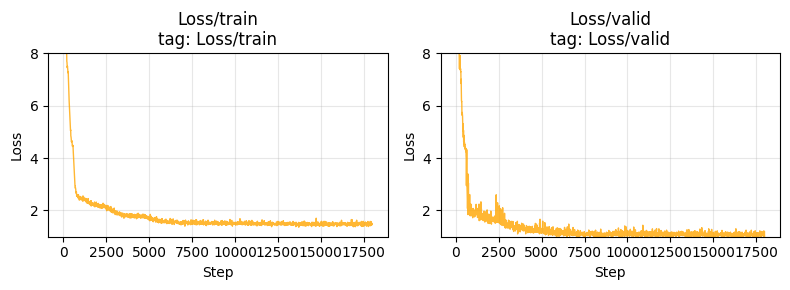


训练统计:
  训练损失: 10.7270 → 1.4800
  验证损失: 9.8857 → 1.0203


In [11]:
import matplotlib.pyplot as plt
import os
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_tensorboard_logs_simple():
    
    # 查找所有日志文件
    log_files = glob.glob('./runs/**/events.out.tfevents.*', recursive=True)
    
    if not log_files:
        print("没有找到tensorboard日志文件")
        return
    
    # 使用最新的日志文件
    latest_log = max(log_files, key=os.path.getmtime)
    
    try:
        # 加载日志
        ea = EventAccumulator(latest_log)
        ea.Reload()
        
        # 提取训练和验证损失
        train_loss_data = ea.Scalars('Loss/train')
        valid_loss_data = ea.Scalars('Loss/valid')
        
        # 提取数据
        train_steps = [x.step for x in train_loss_data]
        train_losses = [x.value for x in train_loss_data]
        
        valid_steps = [x.step for x in valid_loss_data] 
        valid_losses = [x.value for x in valid_loss_data]
        
        # 找到有效训练区间（跳过初始极高损失）
        train_start_idx = next((i for i, loss in enumerate(train_losses) if loss < 20), 0)
        valid_start_idx = next((i for i, loss in enumerate(valid_losses) if loss < 20), 0)
        
        # 截取有效数据
        train_steps_clipped = train_steps[train_start_idx:]
        train_losses_clipped = train_losses[train_start_idx:]
        valid_steps_clipped = valid_steps[valid_start_idx:]
        valid_losses_clipped = valid_losses[valid_start_idx:]
        
        # 只绘制两个图 - 类似示范图的风格
        plt.figure(figsize=(8, 3))
        
        # 训练损失
        plt.subplot(1, 2, 1)
        plt.plot(train_steps_clipped, train_losses_clipped, 'orange', alpha=0.8, linewidth=1)
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Loss/train\ntag: Loss/train', fontsize=12)
        plt.ylim(1, 8)  # 设置Y轴范围
        plt.grid(True, alpha=0.3)
        
        # 验证损失
        plt.subplot(1, 2, 2)
        plt.plot(valid_steps_clipped, valid_losses_clipped, 'orange', alpha=0.8, linewidth=1)
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Loss/valid\ntag: Loss/valid', fontsize=12)
        plt.ylim(1, 8)  # 设置Y轴范围
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 打印简要统计信息
        print(f"\n训练统计:")
        print(f"  训练损失: {train_losses_clipped[0]:.4f} → {train_losses_clipped[-1]:.4f}")
        print(f"  验证损失: {valid_losses_clipped[0]:.4f} → {valid_losses_clipped[-1]:.4f}")
        
    except Exception as e:
        print(f"读取日志文件时出错: {e}")

# 运行简化版函数
plot_tensorboard_logs_simple()

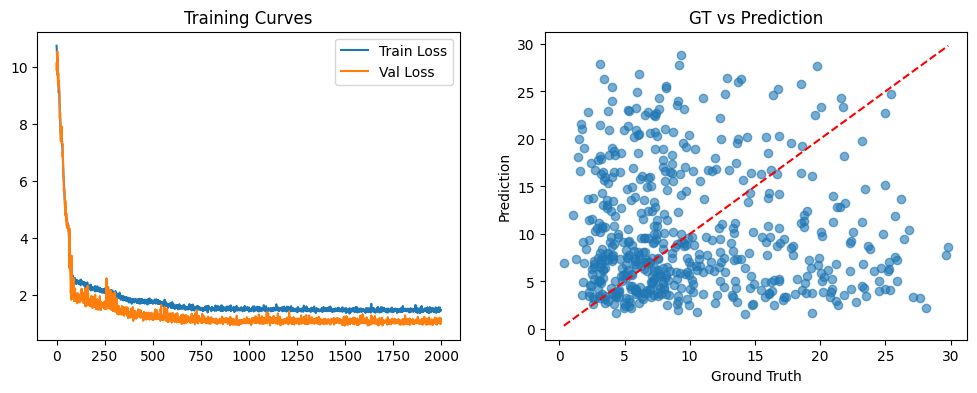

In [12]:
# 1. 画损失曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Training Curves')

# 2. 画预测结果
plt.subplot(1, 2, 2)
model.load_state_dict(torch.load(config['save_path']))
model.eval()
val_preds = []
with torch.no_grad():
    for x, y in valid_loader:
        val_preds.append(model(x.to(device)).cpu().numpy())
val_preds = np.concatenate(val_preds)

plt.scatter(y_valid, val_preds, alpha=0.6)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('GT vs Prediction')
plt.show()

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [13]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
save_pred(preds, 'pred.csv')

100%|██████████| 5/5 [00:00<00:00, 1205.68it/s]


# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)